In [1]:
from tqdm.notebook import tqdm
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date
import os

import warnings
warnings.filterwarnings('ignore')


In [20]:
base_path = 'data/created/'


futures_huobi = pd.read_csv(base_path + 'futures_huobi.tsv', index_col=0, sep='\t')
futures_bitmex = pd.read_csv(base_path + 'futures_bitmex.tsv', index_col=0, sep='\t')
spot = pd.read_csv(base_path + 'spot.tsv', index_col=0, sep='\t')
ccmix_index = pd.read_csv('data/index/CCMIXdata.csv', parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'CCMIX'])
risk_free = pd.read_csv('data/index/risk_free.csv', parse_dates=['DATE'], index_col=['DATE']) 


# Переводим индексы в датаобъекты
futures_huobi.index = pd.to_datetime(futures_huobi.index)

futures_bitmex.index = pd.to_datetime(futures_bitmex.index)

ccmix_index.index = ccmix_index.index.normalize()
ccmix_index['rolling_10'] = ccmix_index['CCMIX'].rolling(10).mean()
ccmix_index['rolling_20'] = ccmix_index['CCMIX'].rolling(20).mean()
ccmix_index['dummy'] = (ccmix_index['rolling_10'] > ccmix_index['rolling_20']).astype(int)
ccmix_index['return'] = ccmix_index['CCMIX'].pct_change().fillna(0)

spot.index = pd.to_datetime(spot.index)

risk_free = risk_free.resample('1d').last().fillna(method='ffill') / 100
risk_free.columns = ['risk_free']
ix = pd.date_range(start=date(2013, 1, 1), end=date(2021, 12, 31), freq='D')
risk_free = risk_free.reindex(ix).fillna(method='ffill')

In [3]:
futures_bch = (futures_bitmex[futures_bitmex['symbol'] == 'BCHF18']['close'] / spot[spot['coin'] == 'BTC']['price']).dropna()
spot_bch = spot[spot['coin'] == 'BCH']['price']

### Расмотрим контанго

Стратегия заключается в использовании арбитража. Если цена фьючерса выше, чем цена спота, то продаем фьючерс и покупаем спот. Выходим из позиции в самом конце, либо раньше, когда контанго сменяется на бэквордацию.

In [245]:
def contract_to_arbitrage(contract, coin, mul=None):
    futures_coin = futures_bitmex[futures_bitmex['symbol'] == contract][['close', 'trades', 'volume', 'carry', 'ar_carry']]
    futures_coin = futures_coin[~futures_coin.index.duplicated()]
    
#     futures_p = futures_bitmex.reset_index().pivot_table(index='index', columns=['coin'])['close']
#     merged = pd.concat([spot_p[coin], futures_p[coin]], axis=1).dropna()

    futures_coin.columns = ['futures', 'trades', 'volume', 'carry', 'ar_carry']
    
    price = spot[spot['coin'] == coin]['price']
    if mul:
        price *= spot[spot['coin'] == mul]['price']

    price = spot_p[coin]
    price.name = 'spot'
    

    return pd.concat([futures_coin, price], axis=1).dropna().iloc[:-1, :]

$$C_t = \frac{F_t - S_t}{F_t}$$

In [246]:
arb = contract_to_arbitrage('BCHH21', 'BCH')
arb

futures  trades  volume     carry  ar_carry        spot
2020-12-12  262.021977    88.0   286.0 -0.010050  0.010152  259.388604
2020-12-13  270.446032    39.0    55.0 -0.010080  0.010183  267.719885
2020-12-14  277.499938   151.0   366.0 -0.008465  0.008537  275.150840
2020-12-15  279.462172   160.0   530.0 -0.011714  0.011852  276.188658
2020-12-16  289.930848   207.0   831.0 -0.005479  0.005509  288.342367
...                ...     ...     ...       ...       ...         ...
2021-03-05  512.125512   810.0  4136.0 -0.006518  0.006560  508.787672
2021-03-06  503.191103   761.0  2640.0 -0.004533  0.004553  500.910264
2021-03-07  502.938722   677.0  1805.0 -0.003413  0.003425  501.222034
2021-03-08  521.854152   397.0  1302.0 -0.008253  0.008322  517.547214
2021-03-09  530.611354   525.0  1316.0 -0.002436  0.002442  529.318644

[88 rows x 6 columns]

In [247]:
# Мартовский фьючерс на эфир

import matplotlib.pyplot as plt



all_batches = {}
for symb in futures_bitmex.symbol.unique():
    try:
        if symb[:3] in ['BCH', 'XBC', 'EOS', 'ETH', 'ADA', 'ZEC', 'XMR', 'LTC', 'GNO']:
            batch = contract_to_arbitrage(symb, symb[:3])
        else:
            batch = contract_to_arbitrage(symb, symb[:3], mul='BTC')
        
#         batch['carry'] = ((batch['futures'] - batch['spot']) / batch['futures'])
        if not batch.empty:
            all_batches.update({symb: batch})
#         plot = ((batch['futures'] - batch['spot']) / batch['futures']).plot(title=symb)
#         plt.hlines(0, xmin=batch.index.min(), xmax=batch.index.max())
#         plt.show()
#         plot.figure.savefig(f'spreads_{symb}.pdf', dpi=1000)
    except:
        pass    

### Описание данных

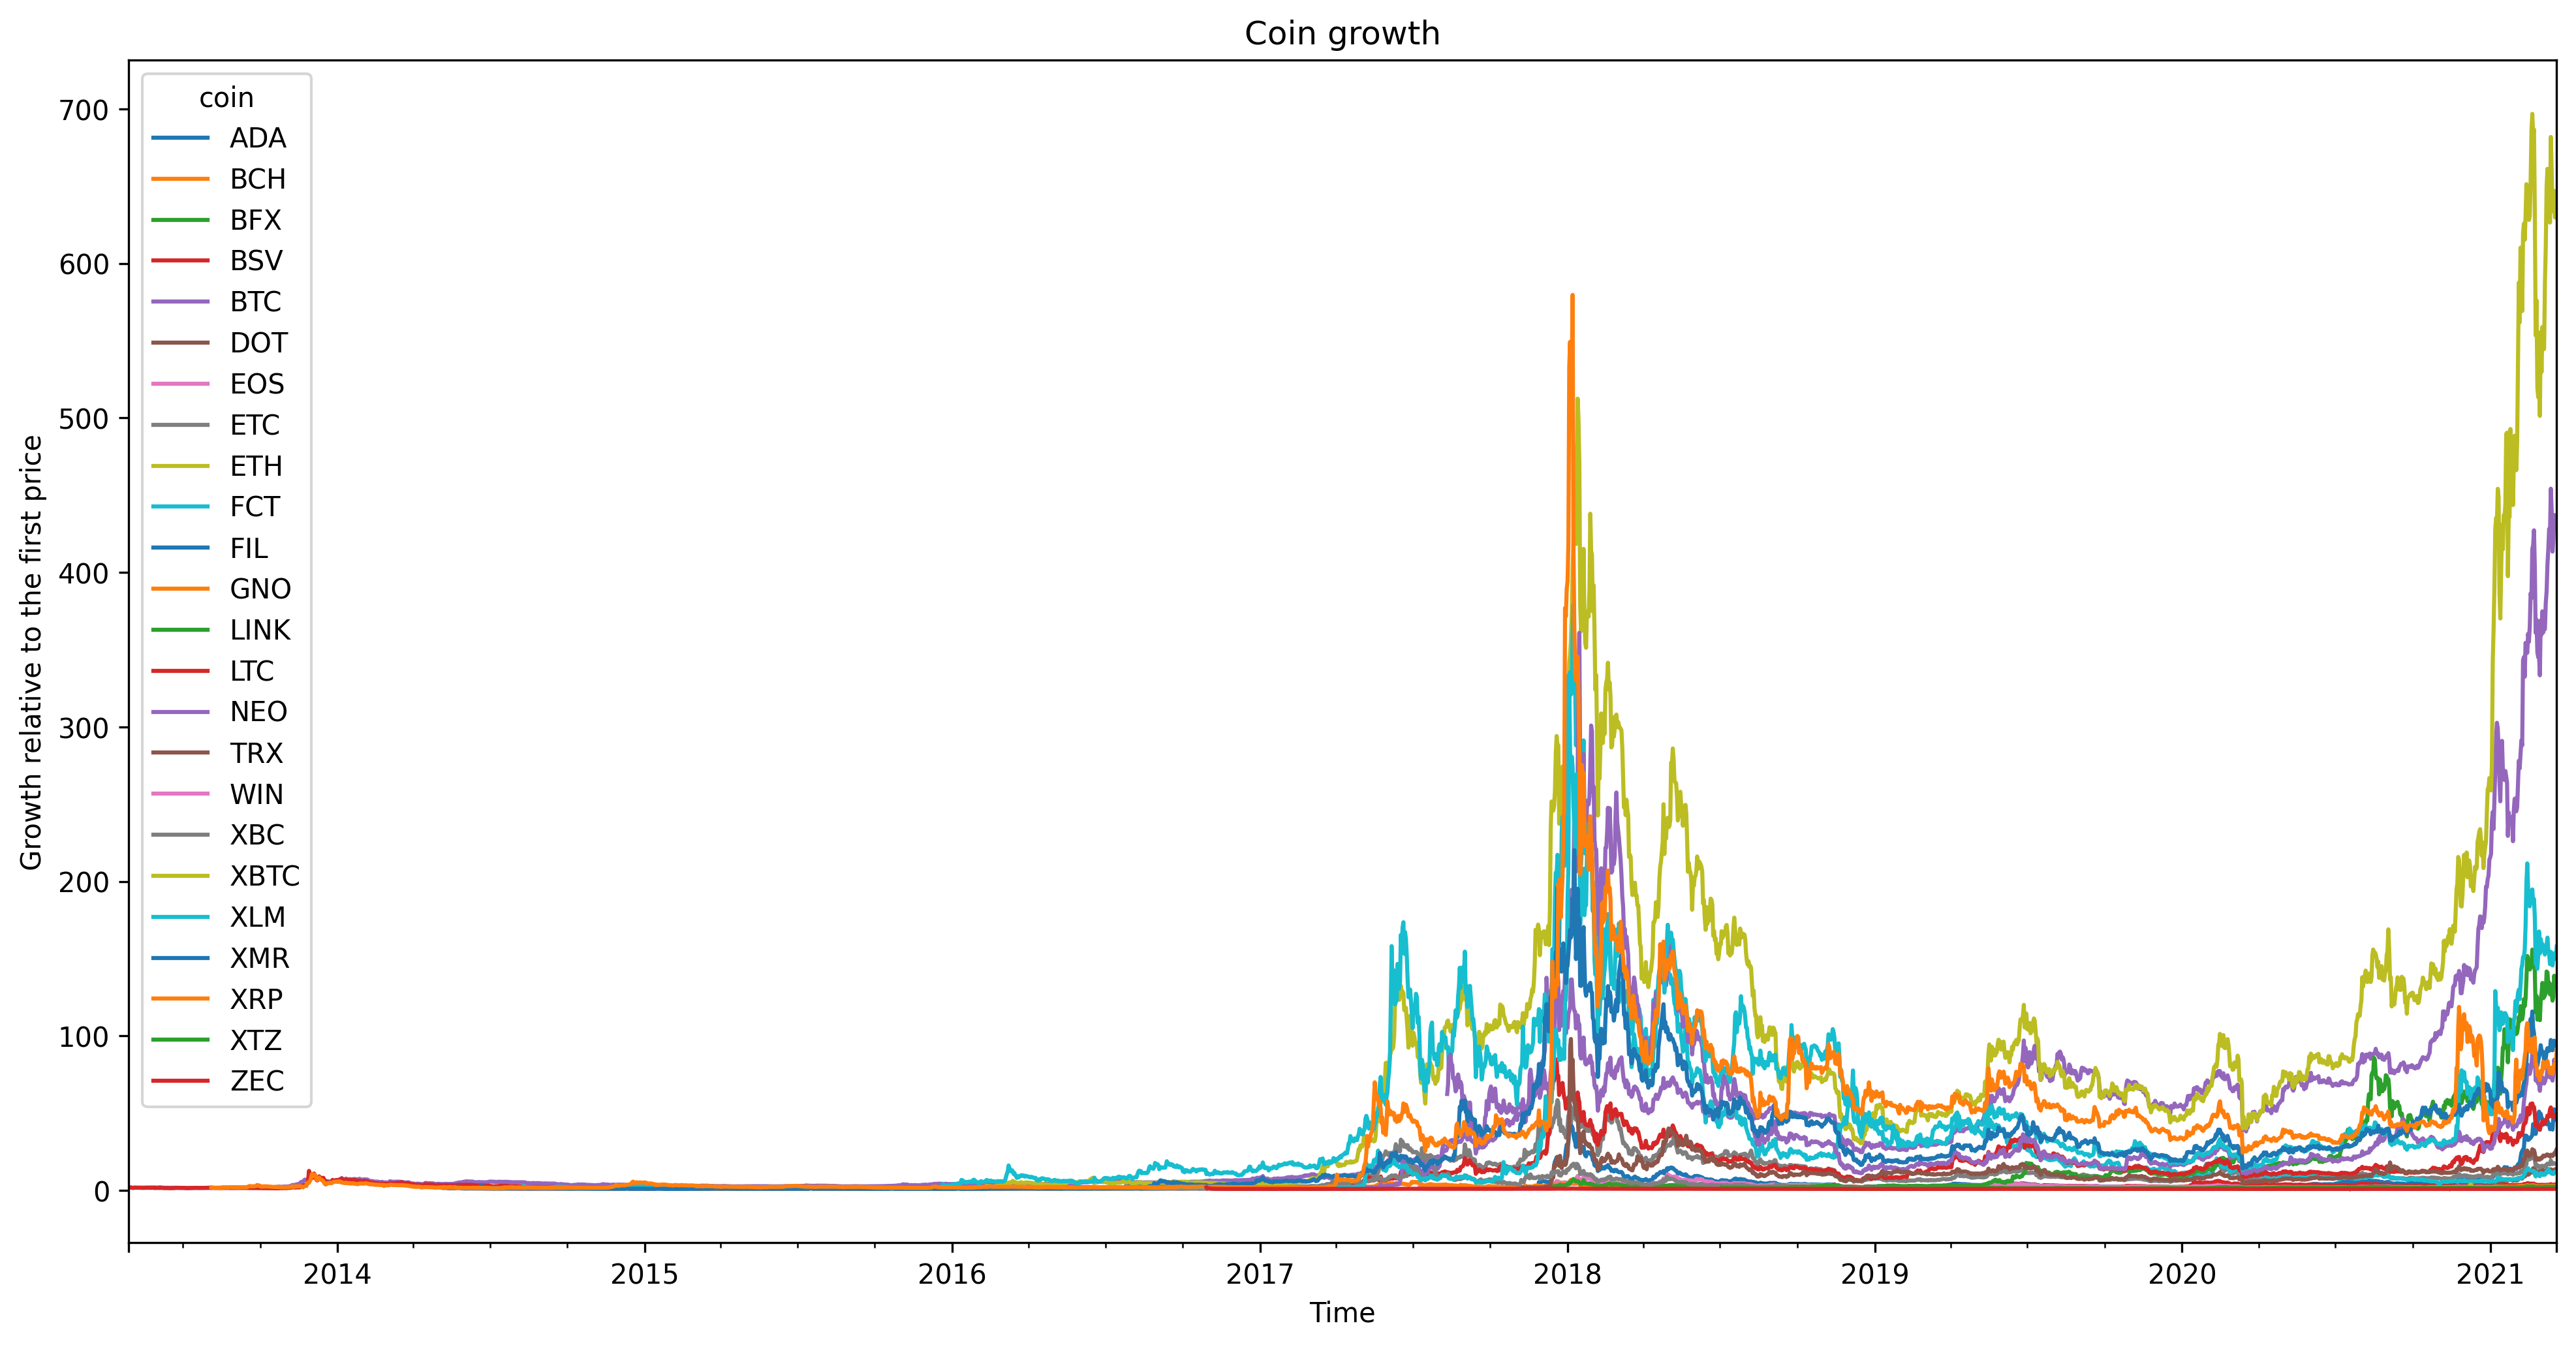

In [199]:
# 24 валюты

fig, ax = plt.subplots(figsize=(16, 8), dpi=300)
all_coins = spot.reset_index().pivot_table(index='index', columns=['coin'])['price']
spot_p = all_coins


(1 + all_coins / all_coins.fillna(method='bfill').iloc[0, :]).plot(ax=ax);
ax.set_title('Coin growth')
ax.set_xlabel('Time')
ax.set_ylabel('Growth relative to the first price')

plt.savefig('imgs/all_spot.png')

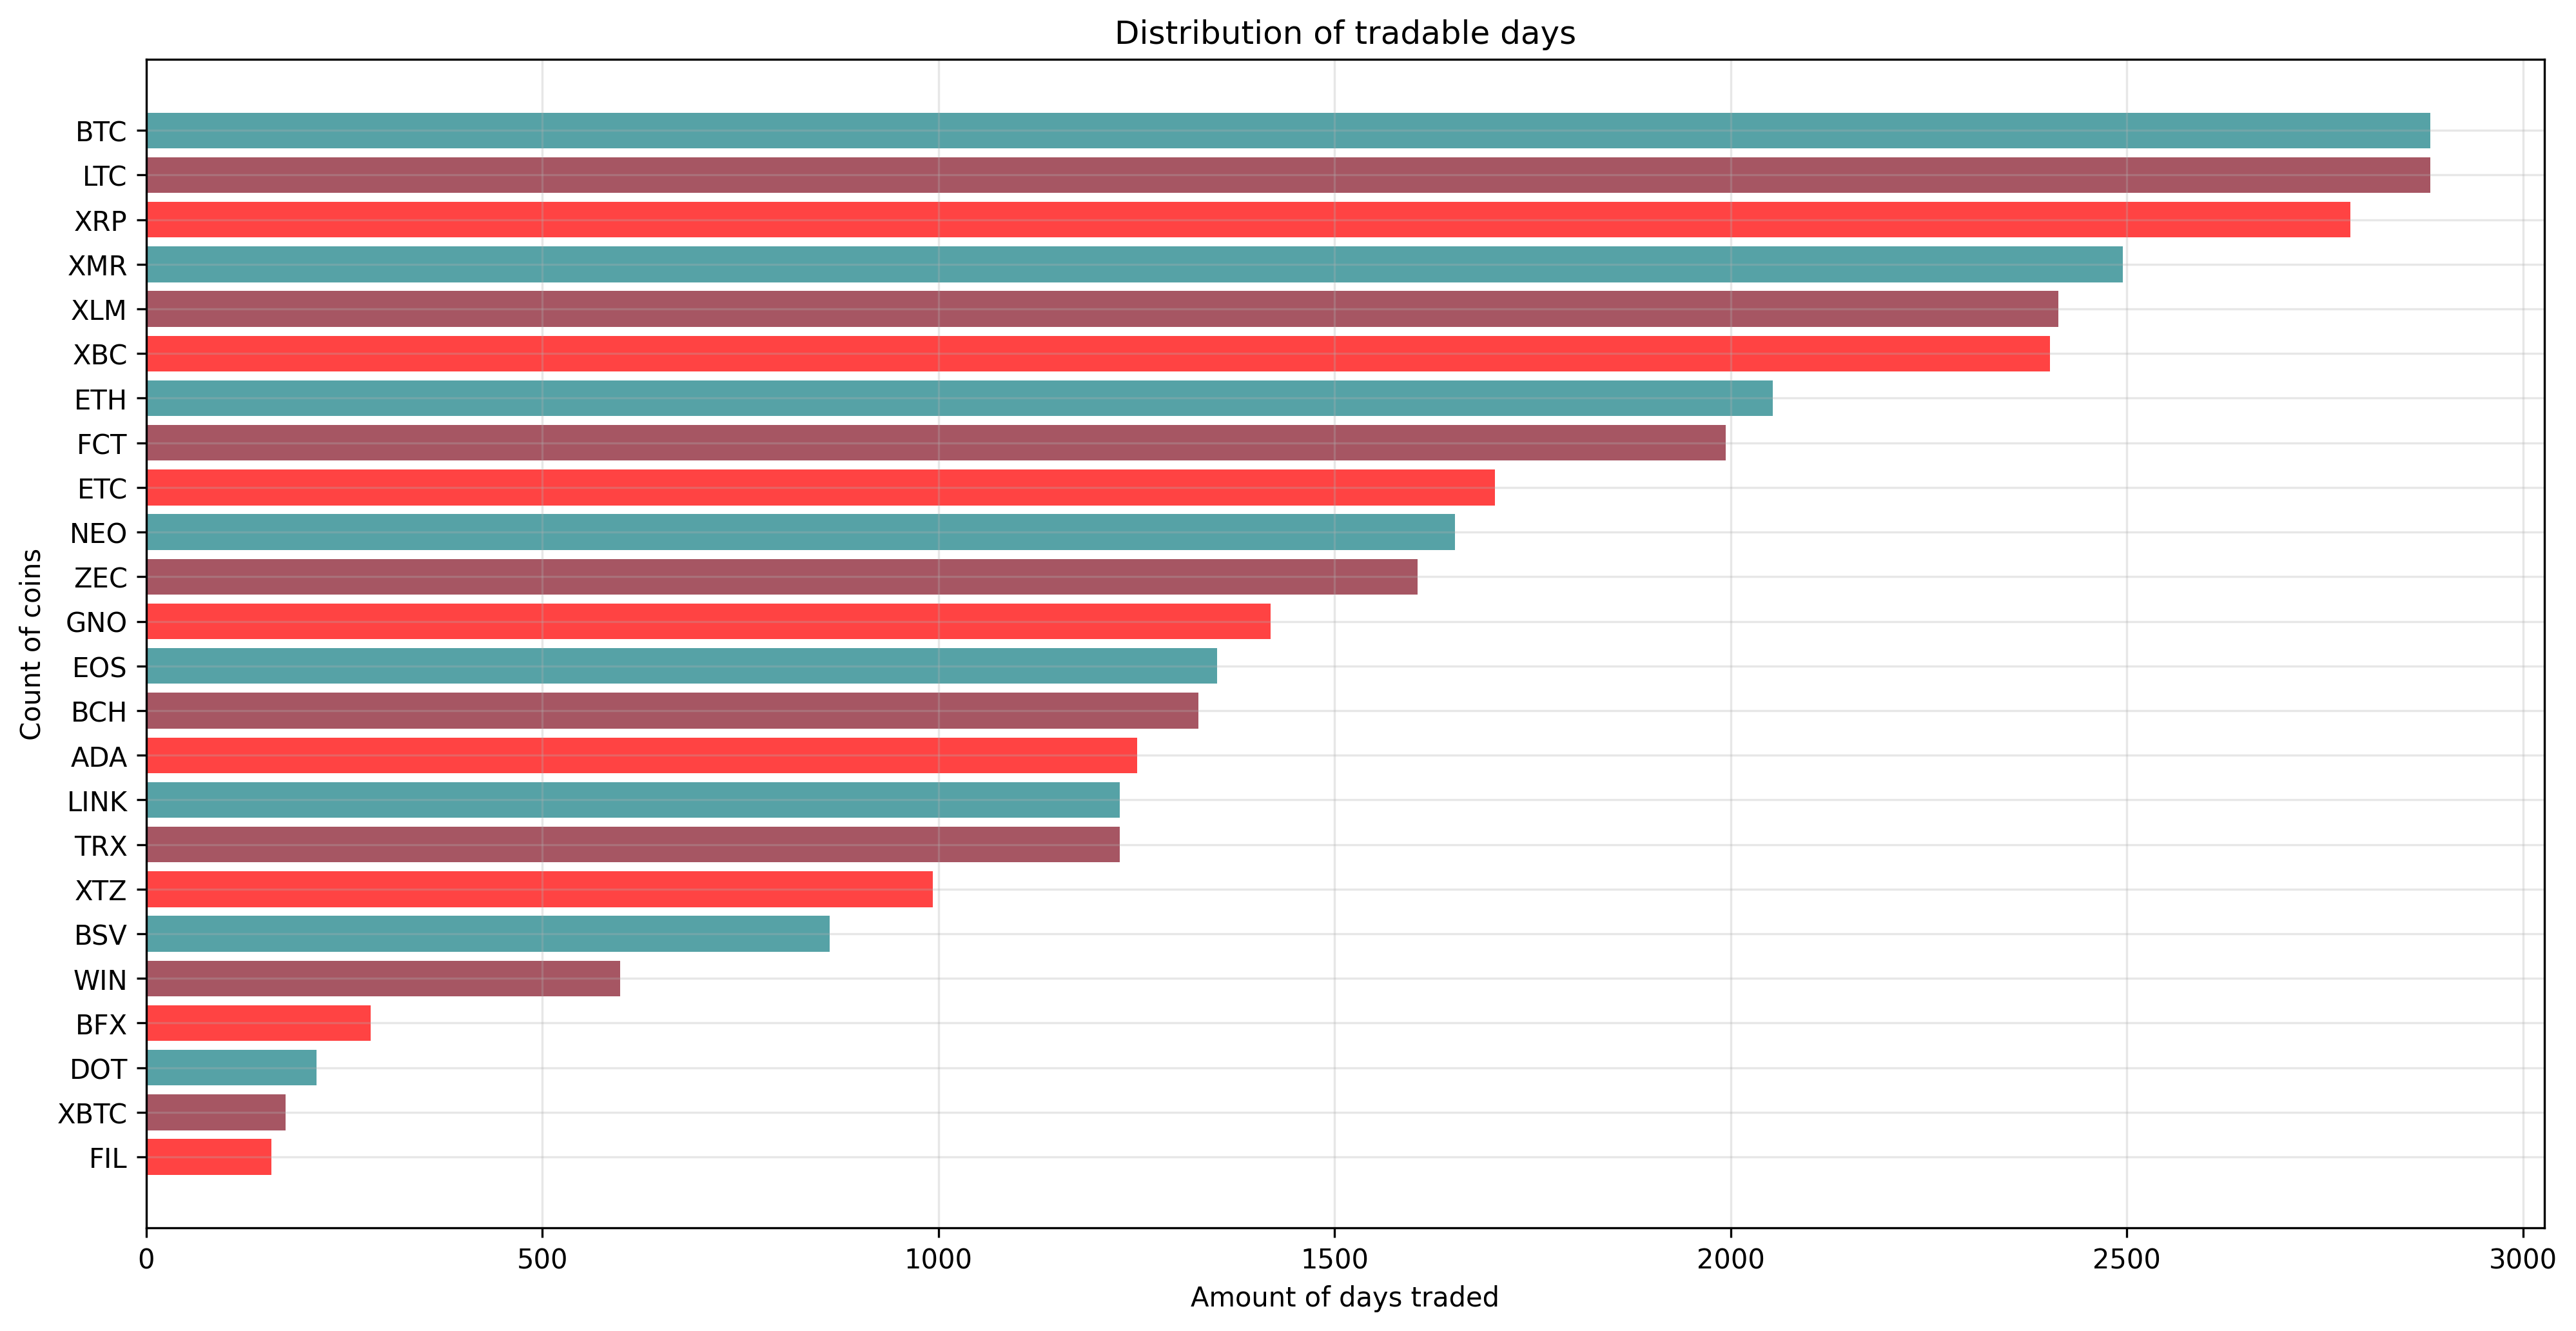

In [200]:

data = spot.groupby('coin').count().sort_values('price')['price']

val = data.values
labs = data.index
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)

# Create horizontal bars
ax.barh(range(len(labs)), val, color=['#FF4343', '#A65663', '#56A2A6'])
 
# Create names on the x-axis
plt.yticks(range(len(labs)), labs);
ax.set_title('Distribution of tradable days')
ax.set_xlabel('Amount of days traded')
ax.grid(alpha=0.3)
ax.set_ylabel('Count of coins');
plt.savefig('imgs/all_spot_tradable.png')



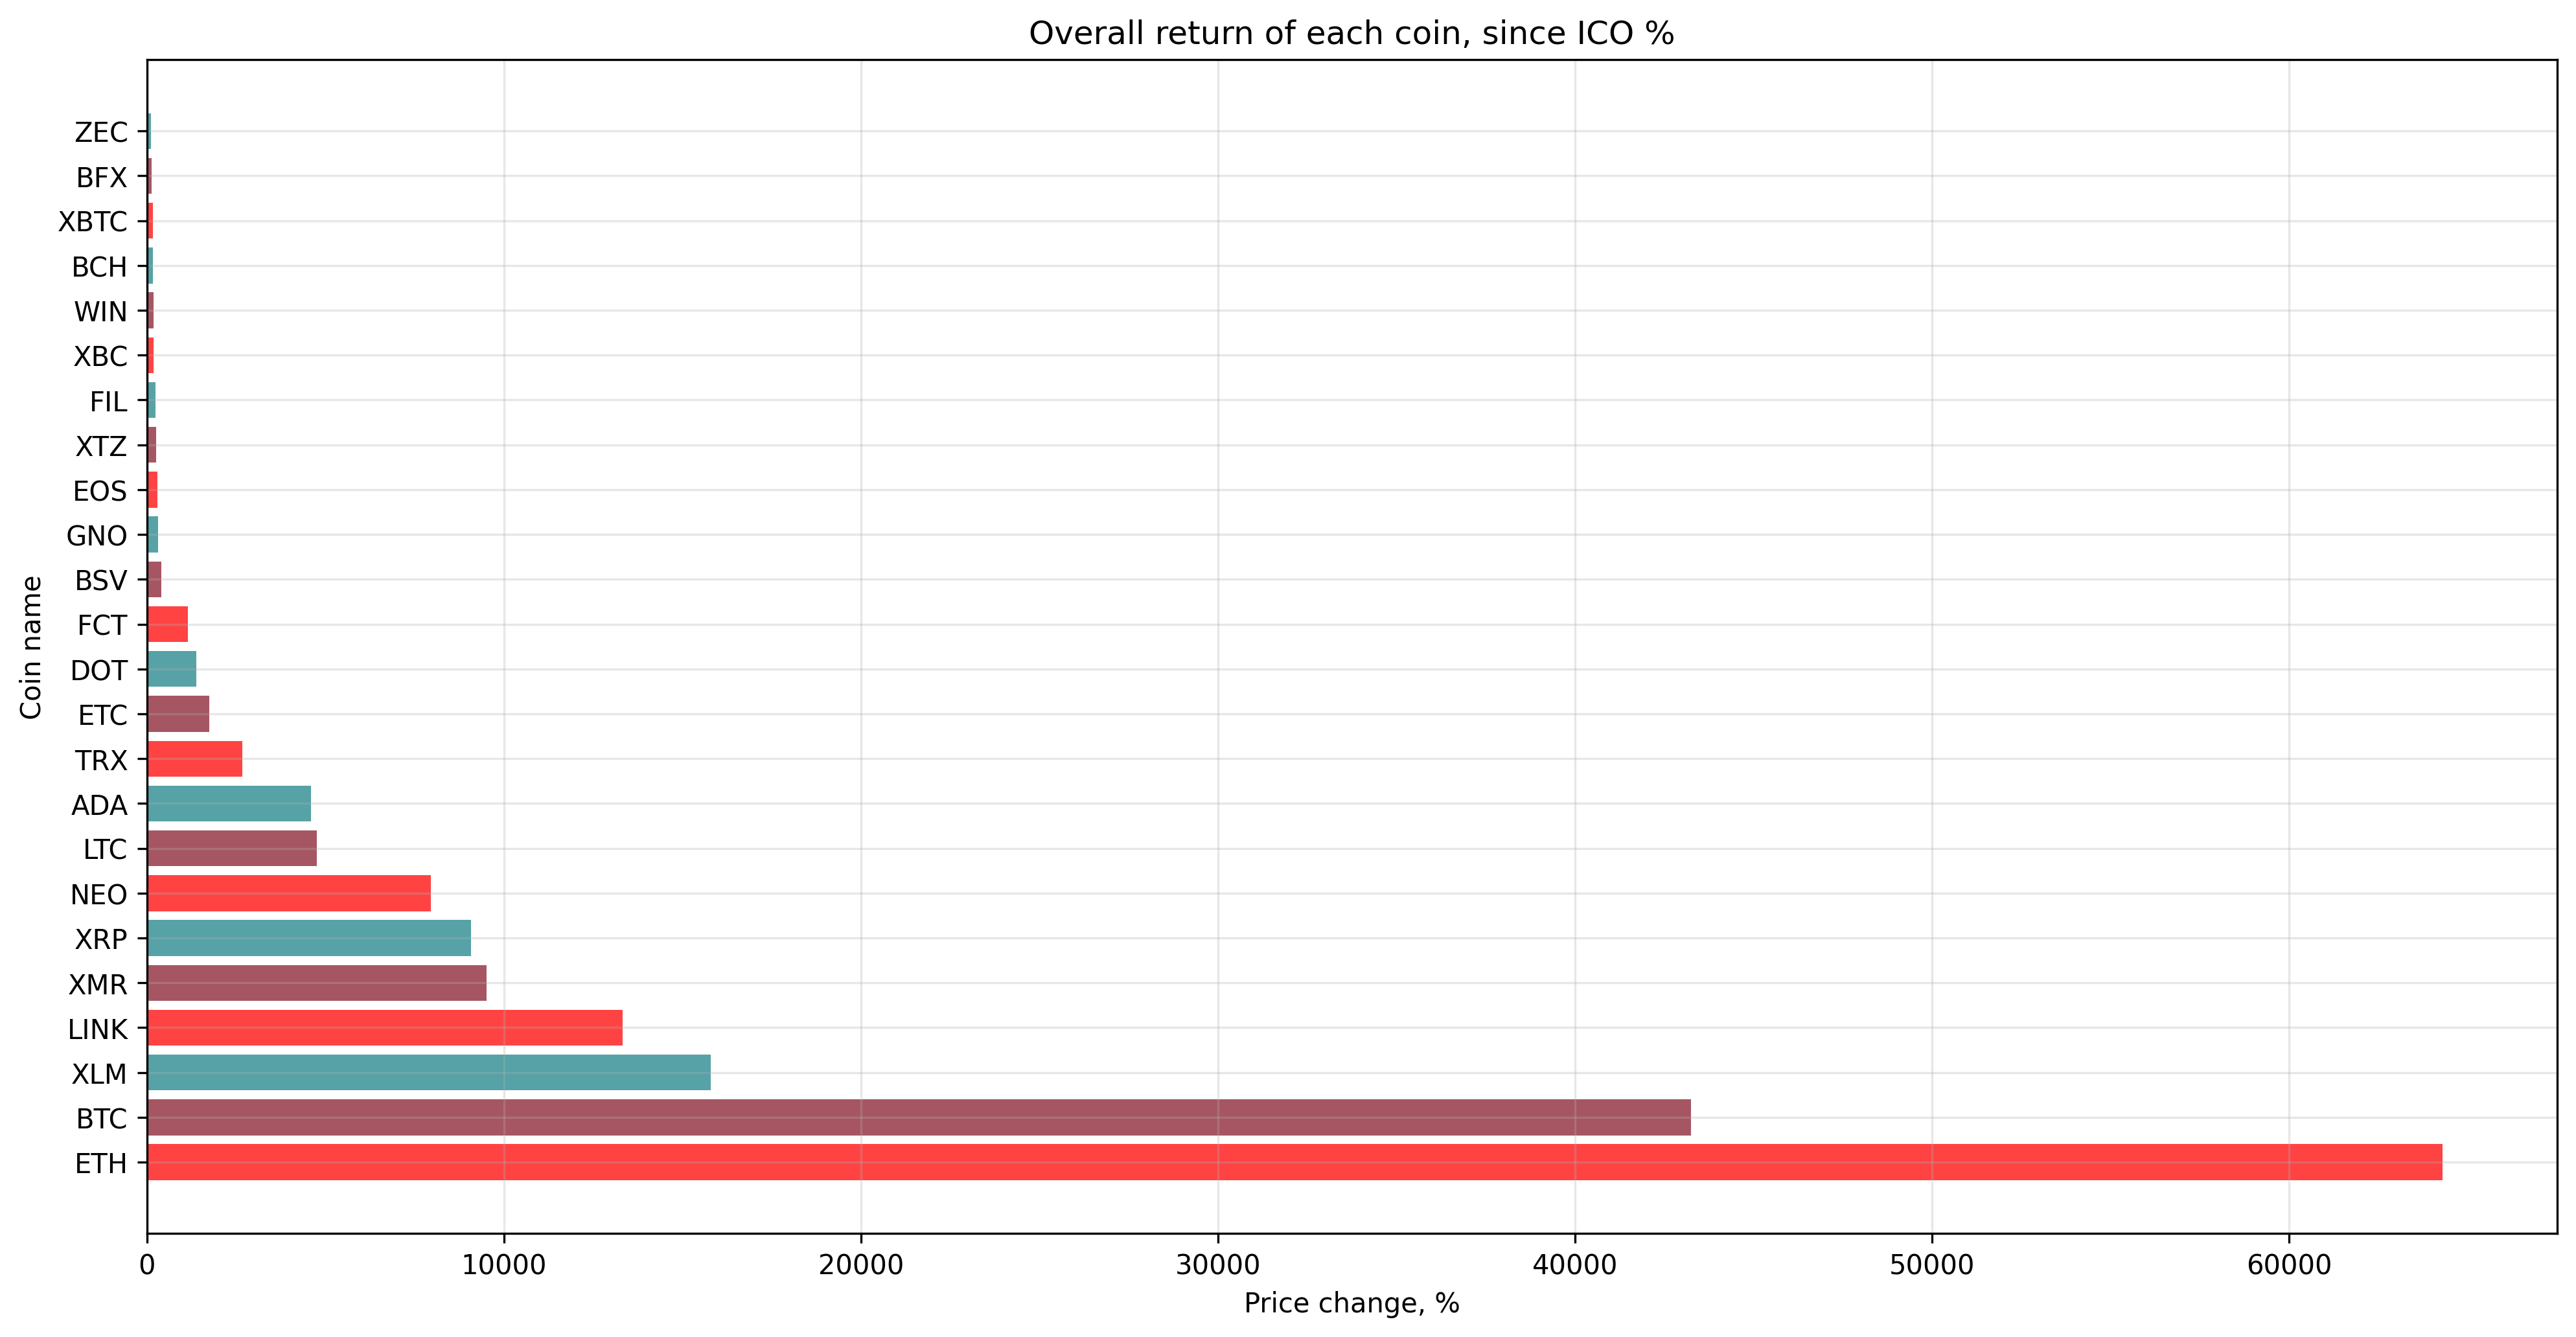

In [201]:
increases = ((1 + all_coins.fillna(method='ffill') / all_coins.fillna(method='bfill').iloc[0, :]).tail(1)).iloc[0, :]



data = increases.sort_values(ascending=False)

val = data.values * 100
labs = data.index
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)

# Create horizontal bars
ax.barh(range(len(labs)), val, color=['#FF4343', '#A65663', '#56A2A6'])
 
# Create names on the x-axis
plt.yticks(range(len(labs)), labs);
ax.set_title('Overall return of each coin, since ICO %')
ax.set_xlabel('Price change, %')
ax.grid(alpha=0.3)
ax.set_ylabel('Coin name');
plt.savefig('imgs/all_spot_return_each.png')


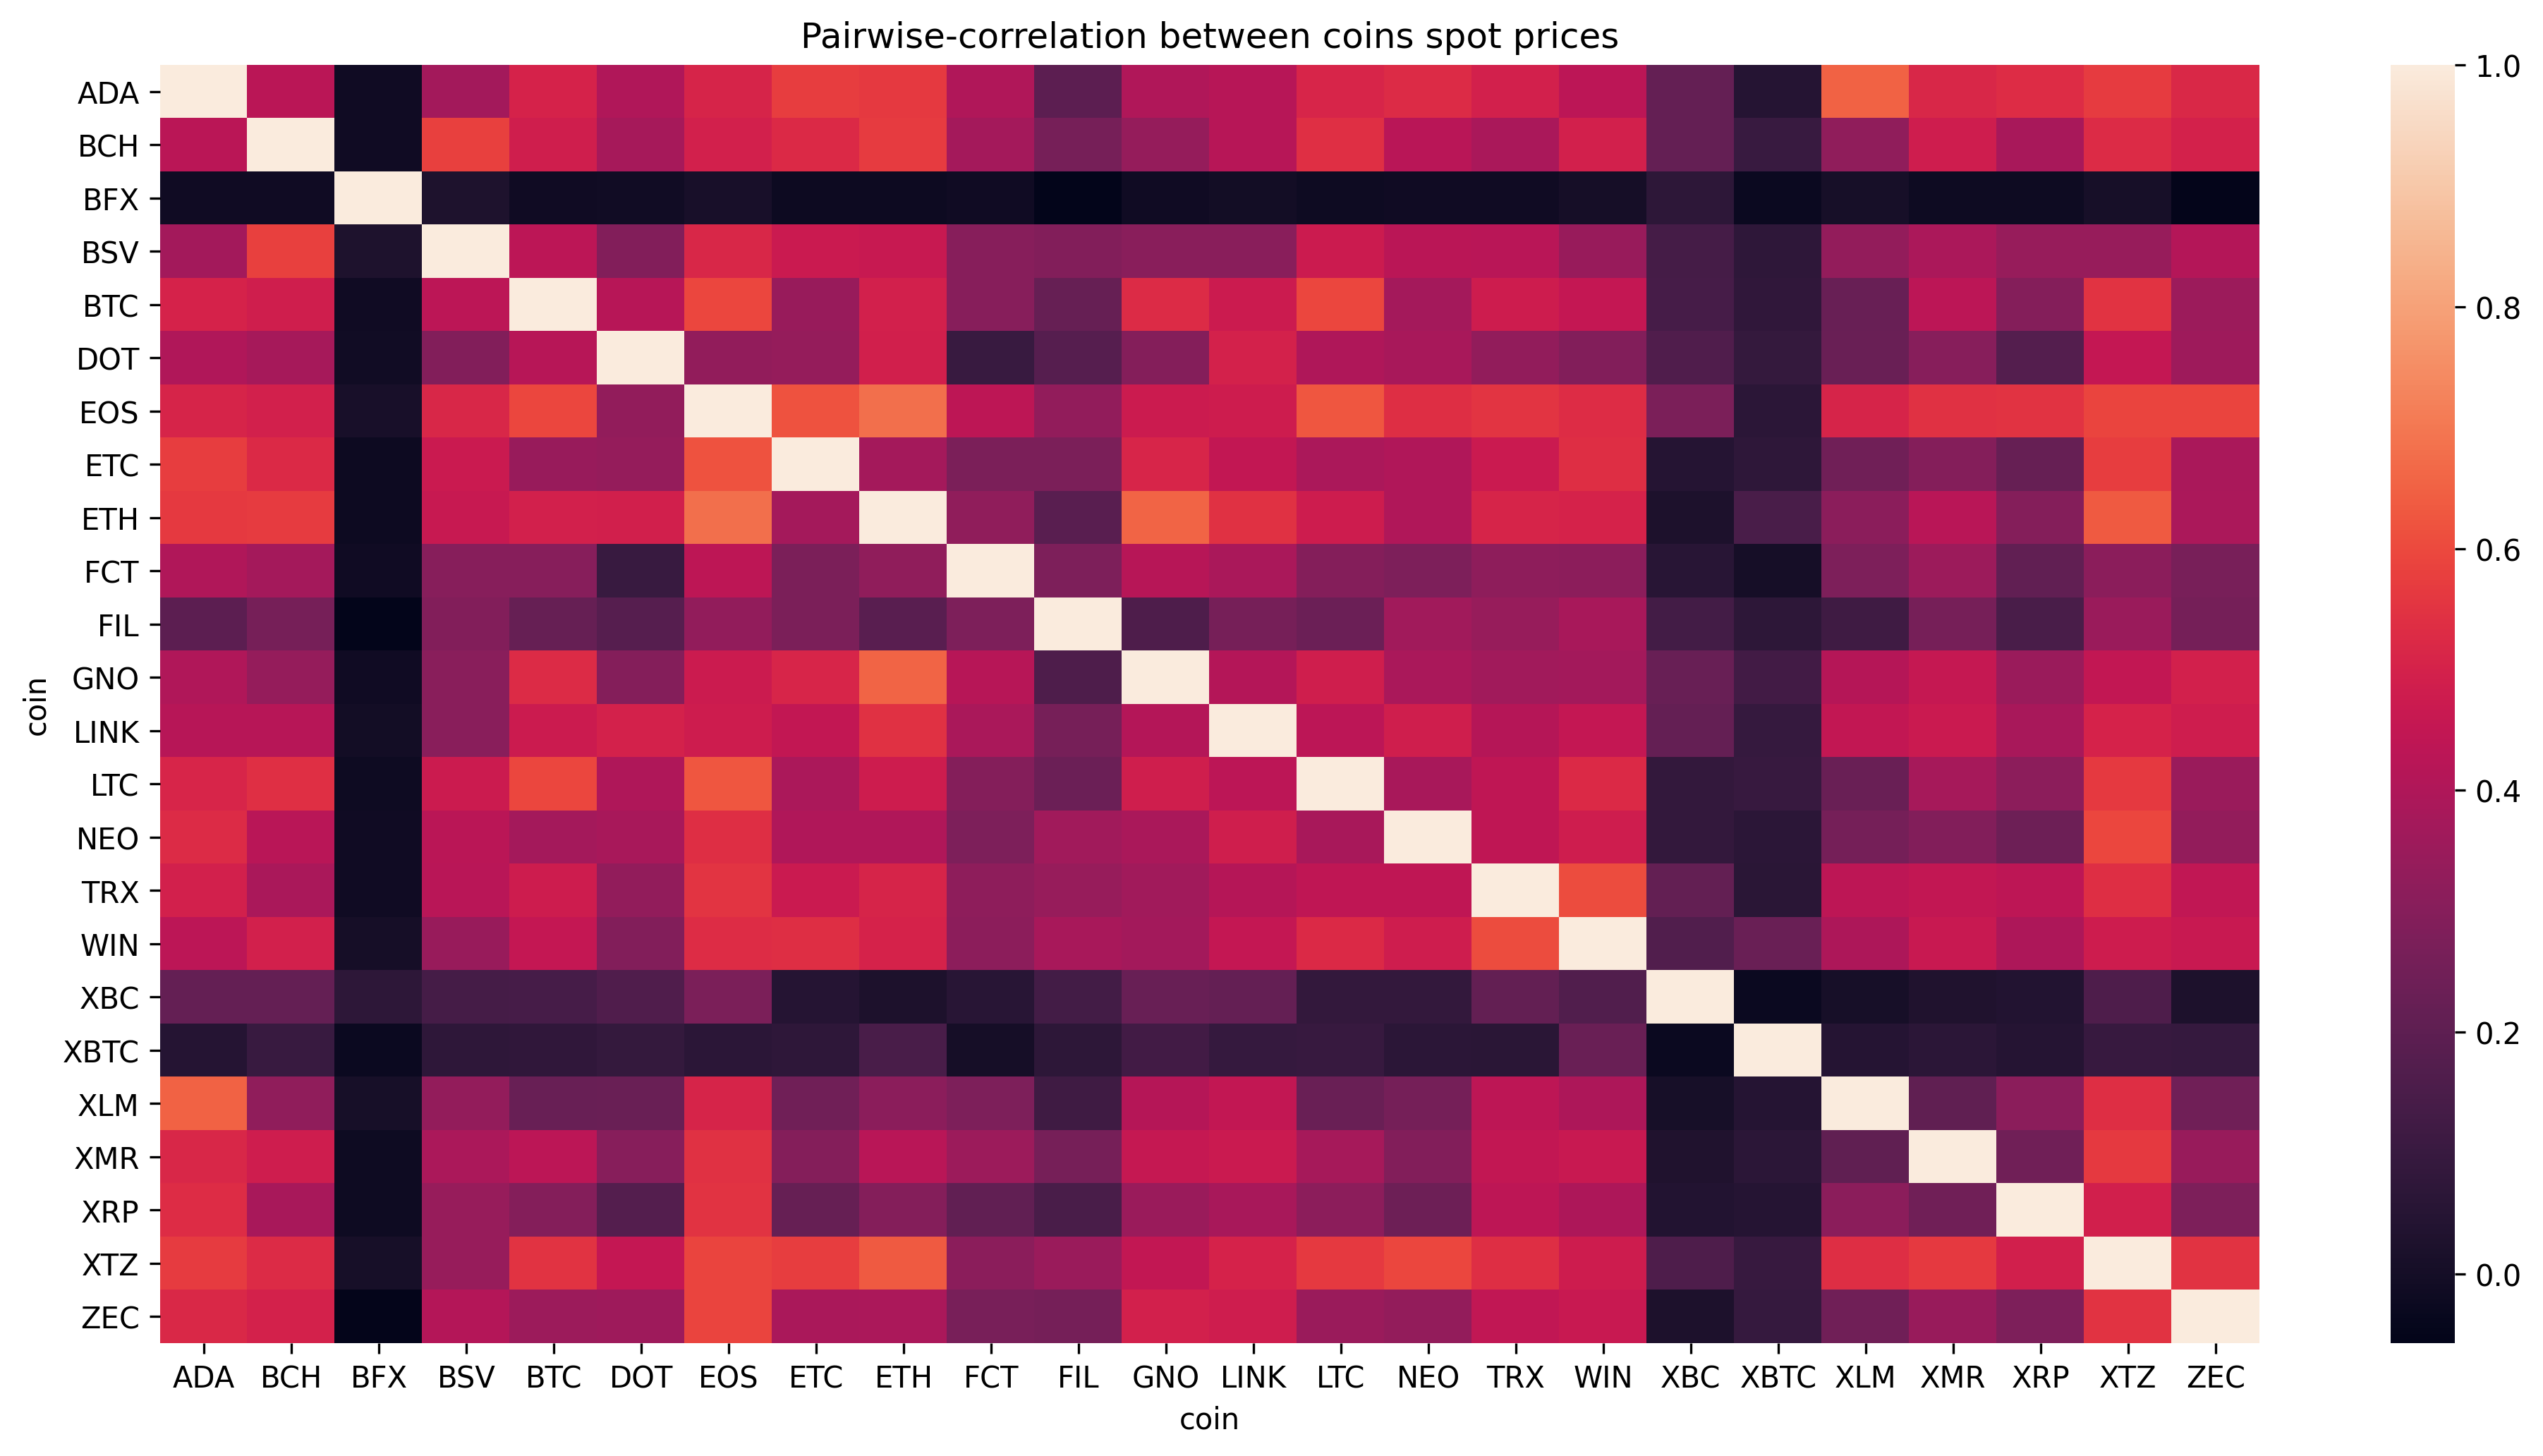

In [202]:
f, ax = plt.subplots(figsize=(16, 8), dpi=300)


corr = all_coins.pct_change().corr()
# corr.style.background_gradient(cmap='coolwarm')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
plt.title('Pairwise-correlation between coins spot prices')
plt.savefig('imgs/pairwise_corr.png')

plt.show()


### Фьючерсы

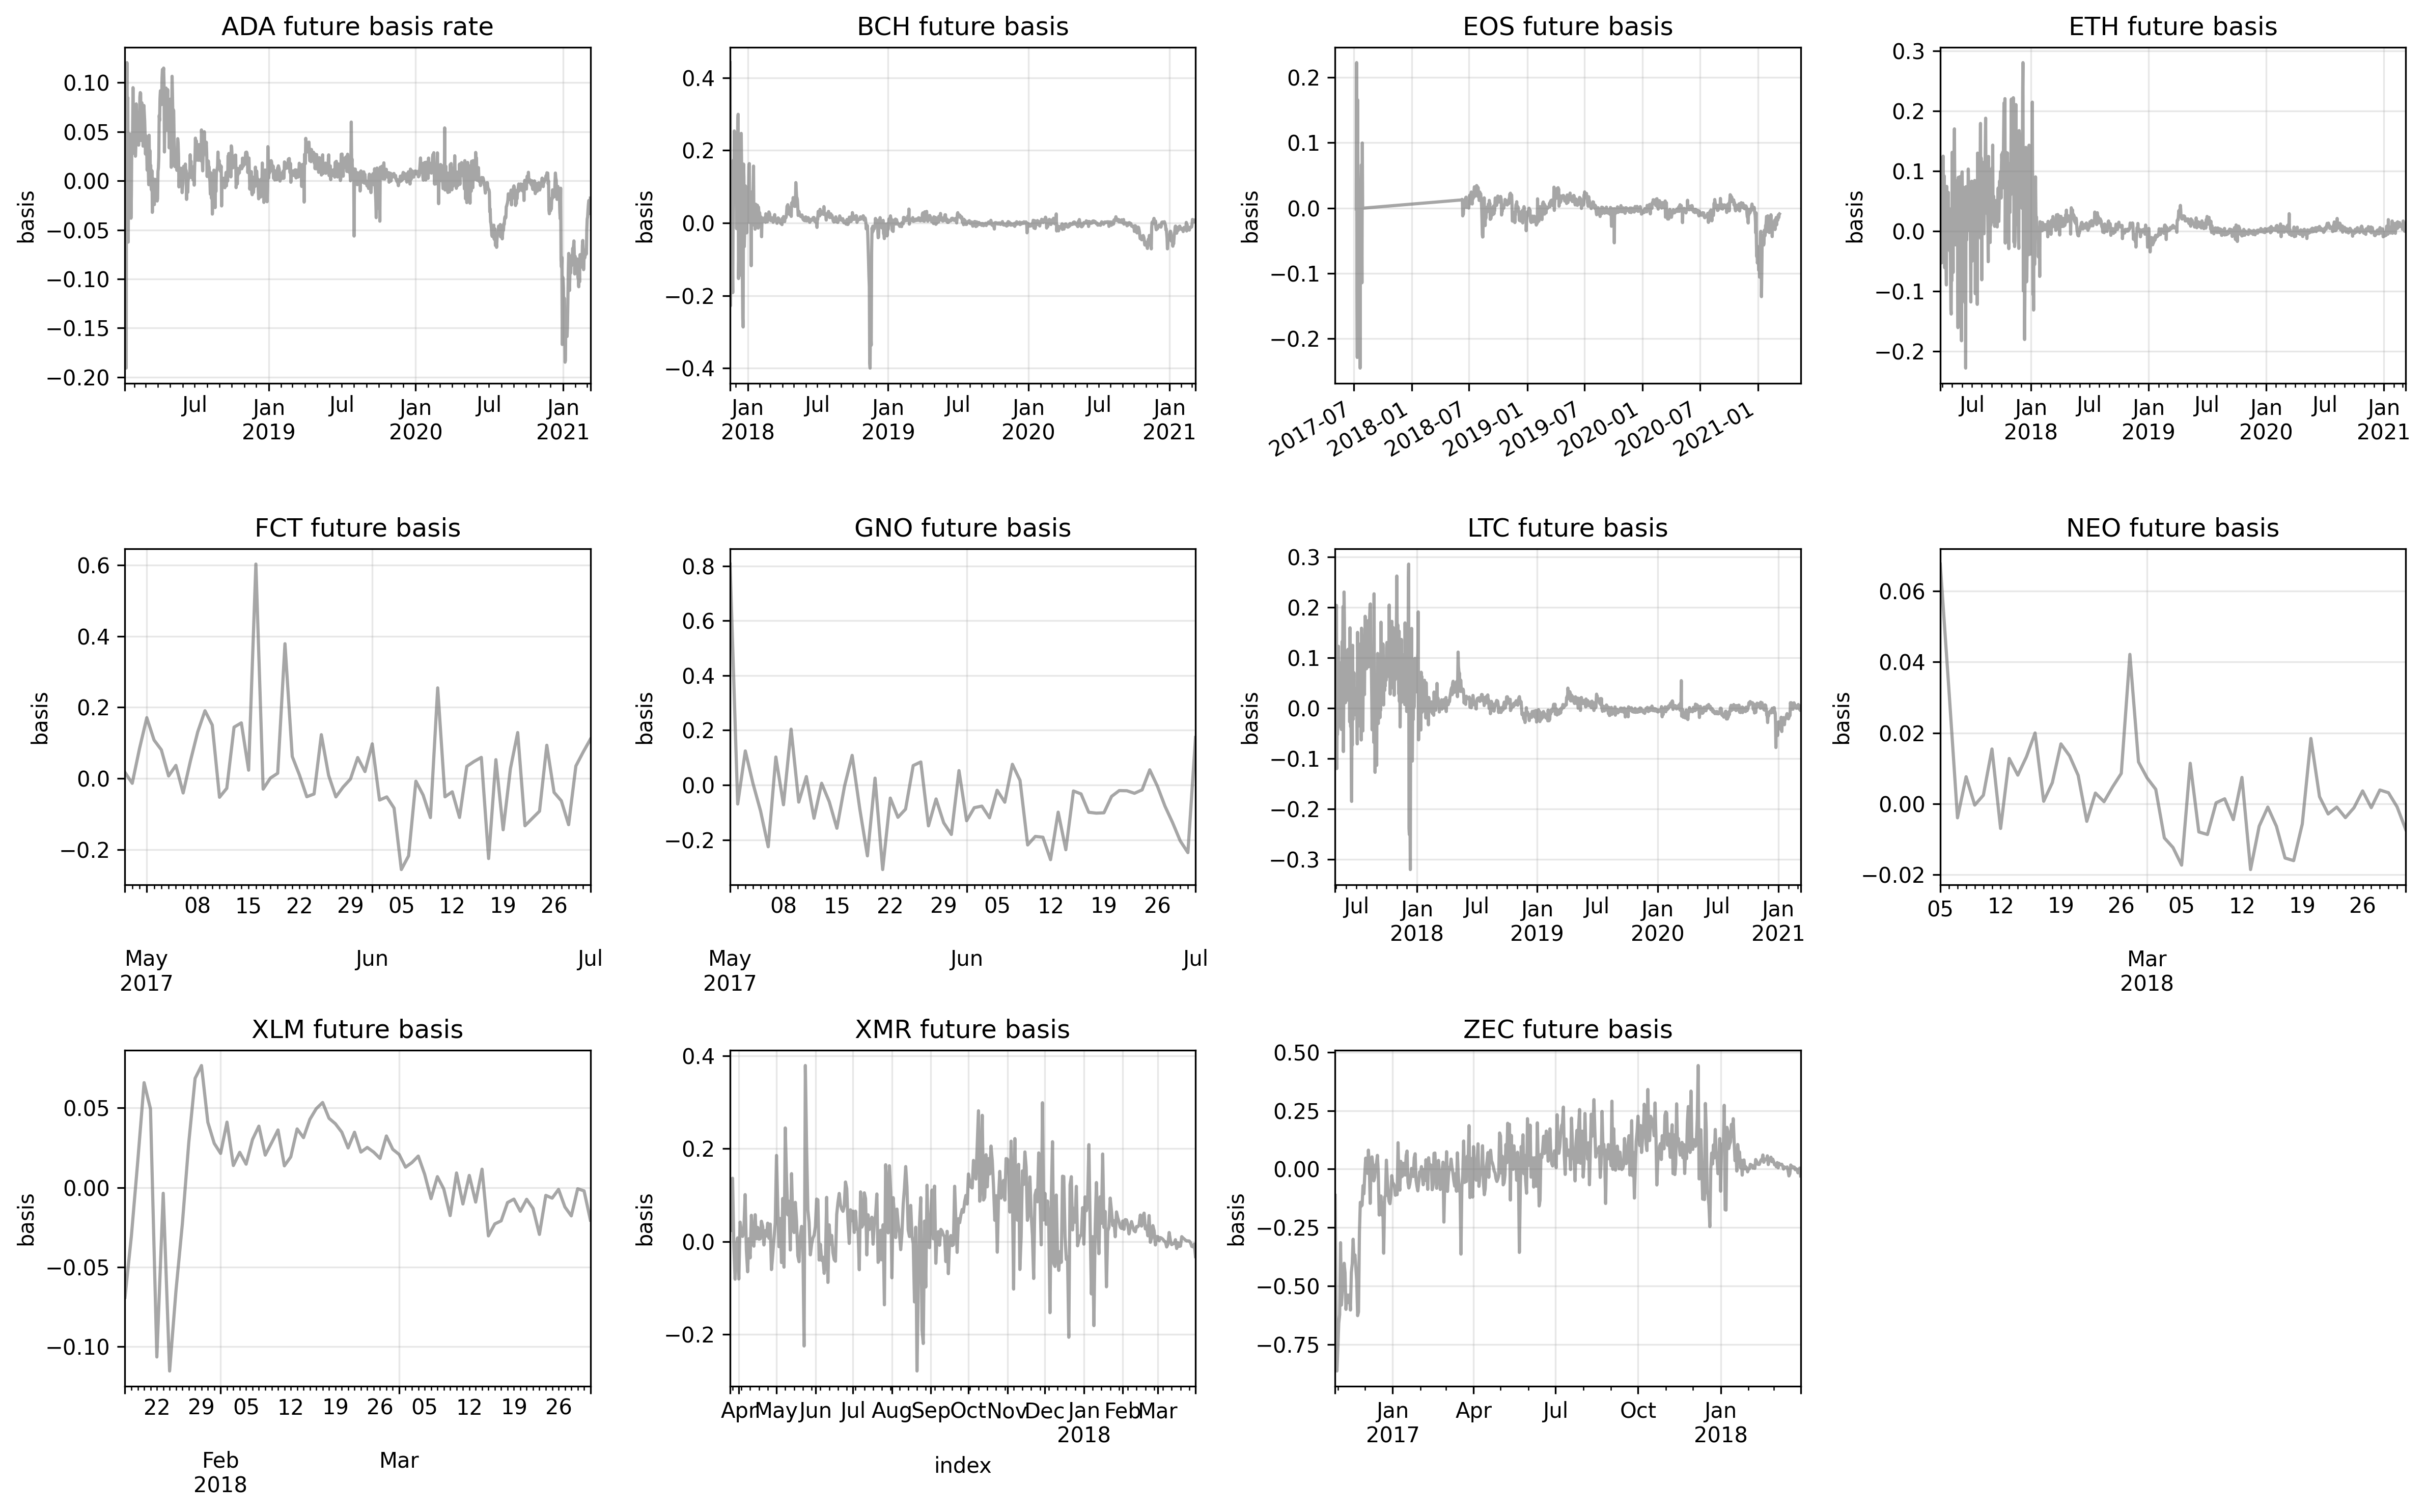

In [203]:
coin = 'ZEC'

def get_carry_plot(coin):
    futures_p = futures_bitmex.reset_index().pivot_table(index='index', columns=['coin'])['close']
    merged = pd.concat([spot_p[coin], futures_p[coin]], axis=1).dropna()
    merged.columns = ['spot', 'futures']
    return ((merged['futures'] - merged['spot']) / merged['spot'])

f, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), dpi=300)

coins = ['ADA', 'BCH', 'EOS', 'ETH', 'FCT', 'GNO', 'LTC', 'NEO', 'XLM', 'XMR', 'ZEC']
get_carry_plot(coins[0]).plot(ax=ax[0, 0], color='grey', alpha=0.7)
ax[0, 0].grid(alpha=0.3)
ax[0, 0].set_title('ADA future basis rate')
ax[0, 0].set_xlabel('')
ax[0, 0].set_ylabel('basis')
get_carry_plot(coins[1]).plot(ax=ax[0, 1], color='grey', alpha=0.7)
ax[0, 1].grid(alpha=0.3)
ax[0, 1].set_title('BCH future basis')
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('basis')
get_carry_plot(coins[2]).plot(ax=ax[0, 2], color='grey', alpha=0.7)
ax[0, 2].grid(alpha=0.3)
ax[0, 2].set_title('EOS future basis')
ax[0, 2].set_xlabel('')
ax[0, 2].set_ylabel('basis')
get_carry_plot(coins[3]).plot(ax=ax[0, 3], color='grey', alpha=0.7)
ax[0, 3].grid(alpha=0.3)
ax[0, 3].set_title('ETH future basis')
ax[0, 3].set_xlabel('')
ax[0, 3].set_ylabel('basis')
get_carry_plot(coins[4]).plot(ax=ax[1, 0], color='grey', alpha=0.7)
ax[1, 0].grid(alpha=0.3)
ax[1, 0].set_title('FCT future basis')
ax[1, 0].set_xlabel('')
ax[1, 0].set_ylabel('basis')
get_carry_plot(coins[5]).plot(ax=ax[1, 1], color='grey', alpha=0.7)
ax[1, 1].grid(alpha=0.3)
ax[1, 1].set_title('GNO future basis')
ax[1, 1].set_xlabel('')
ax[1, 1].set_ylabel('basis')
get_carry_plot(coins[6]).plot(ax=ax[1, 2], color='grey', alpha=0.7)
ax[1, 2].grid(alpha=0.3)
ax[1, 2].set_title('LTC future basis')
ax[1, 2].set_xlabel('')
ax[1, 2].set_ylabel('basis')
get_carry_plot(coins[7]).plot(ax=ax[1, 3], color='grey', alpha=0.7)
ax[1, 3].grid(alpha=0.3)
ax[1, 3].set_title('NEO future basis')
ax[1, 3].set_xlabel('')
ax[1, 3].set_ylabel('basis')
get_carry_plot(coins[8]).plot(ax=ax[2, 0], color='grey', alpha=0.7)
ax[2, 0].grid(alpha=0.3)
ax[2, 0].set_title('XLM future basis')
ax[2, 0].set_xlabel('')
ax[2, 0].set_ylabel('basis')
get_carry_plot(coins[9]).plot(ax=ax[2, 1], color='grey', alpha=0.7)
ax[2, 1].grid(alpha=0.3)
ax[2, 1].set_title('XMR future basis')
ax[2, 1].set_ylabel('basis')
get_carry_plot(coins[10]).plot(ax=ax[2, 2], color='grey', alpha=0.7)
ax[2, 2].grid(alpha=0.3)
ax[2, 2].set_title('ZEC future basis')
ax[2, 2].set_xlabel('')
ax[2, 2].set_ylabel('basis')

ax[-1, -1].axis('off')
plt.tight_layout()
plt.savefig('all_basises.png')


In [239]:

def get_carry_plot(coin):
    futures_p = futures_bitmex.reset_index().pivot_table(index='index', columns=['coin'])['close']
    merged = pd.concat([spot_p[coin], futures_p[coin]], axis=1).dropna()
    merged.columns = ['spot', 'futures']
    return ((merged['futures'] - merged['spot']) / merged['spot'])


get_carry_plot('XLM')

                 XLM       XLM
index                         
2018-01-17  0.490331  0.456502
2018-01-18  0.516349  0.500493
2018-01-19  0.514865  0.523252
2018-01-20  0.551468  0.587828
2018-01-21  0.471387  0.494707
...              ...       ...
2018-03-27  0.228567  0.225775
2018-03-28  0.216699  0.212846
2018-03-29  0.218496  0.218334
2018-03-30  0.190823  0.190431
2018-03-31  0.189412  0.185537

[74 rows x 2 columns]


index
2018-01-17   -0.068993
2018-01-18   -0.030707
2018-01-19    0.016290
2018-01-20    0.065933
2018-01-21    0.049471
                ...   
2018-03-27   -0.012212
2018-03-28   -0.017780
2018-03-29   -0.000740
2018-03-30   -0.002055
2018-03-31   -0.020462
Freq: D, Length: 74, dtype: float64

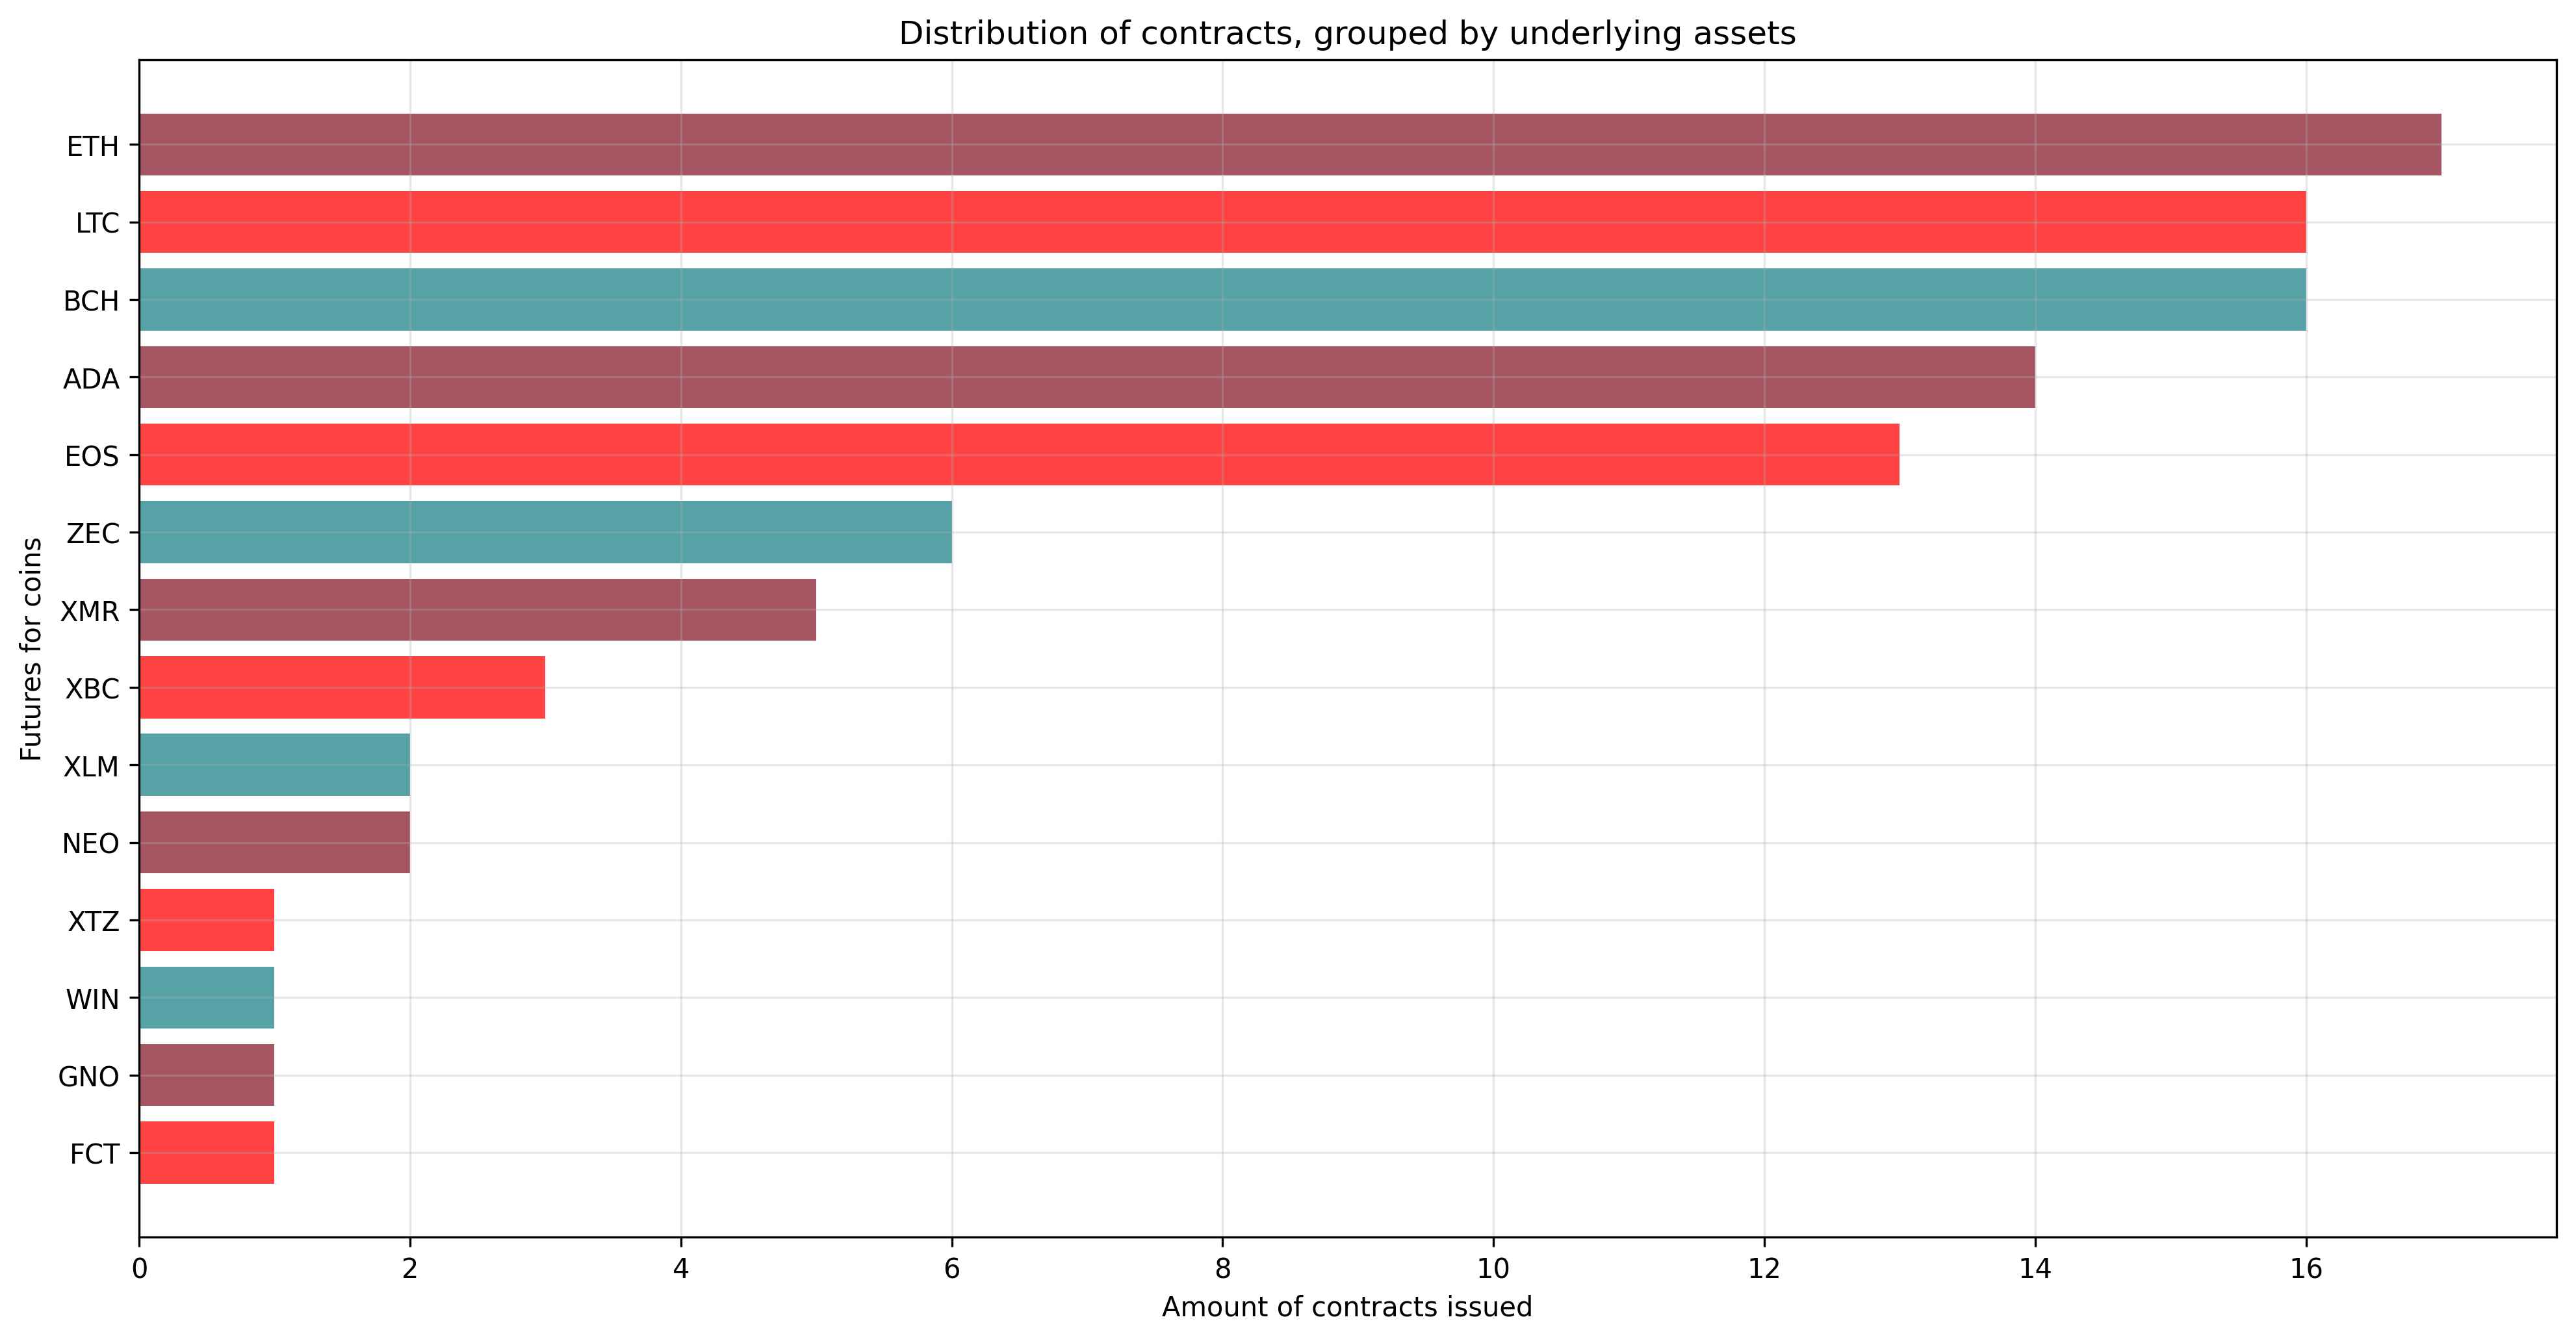

In [204]:
data = futures_bitmex.groupby(['coin', 'symbol']).count().reset_index().groupby('coin').count()['symbol'].sort_values()

val = data.values
labs = data.index
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)

# Create horizontal bars
ax.barh(range(len(labs)), val, color=['#FF4343', '#A65663', '#56A2A6'])
 
# Create names on the x-axis
plt.yticks(range(len(labs)), labs);
ax.set_title('Distribution of contracts, grouped by underlying assets')
ax.set_xlabel('Amount of contracts issued')
ax.grid(alpha=0.3)
ax.set_ylabel('Futures for coins');
plt.savefig('imgs/contracts_distribution.png')

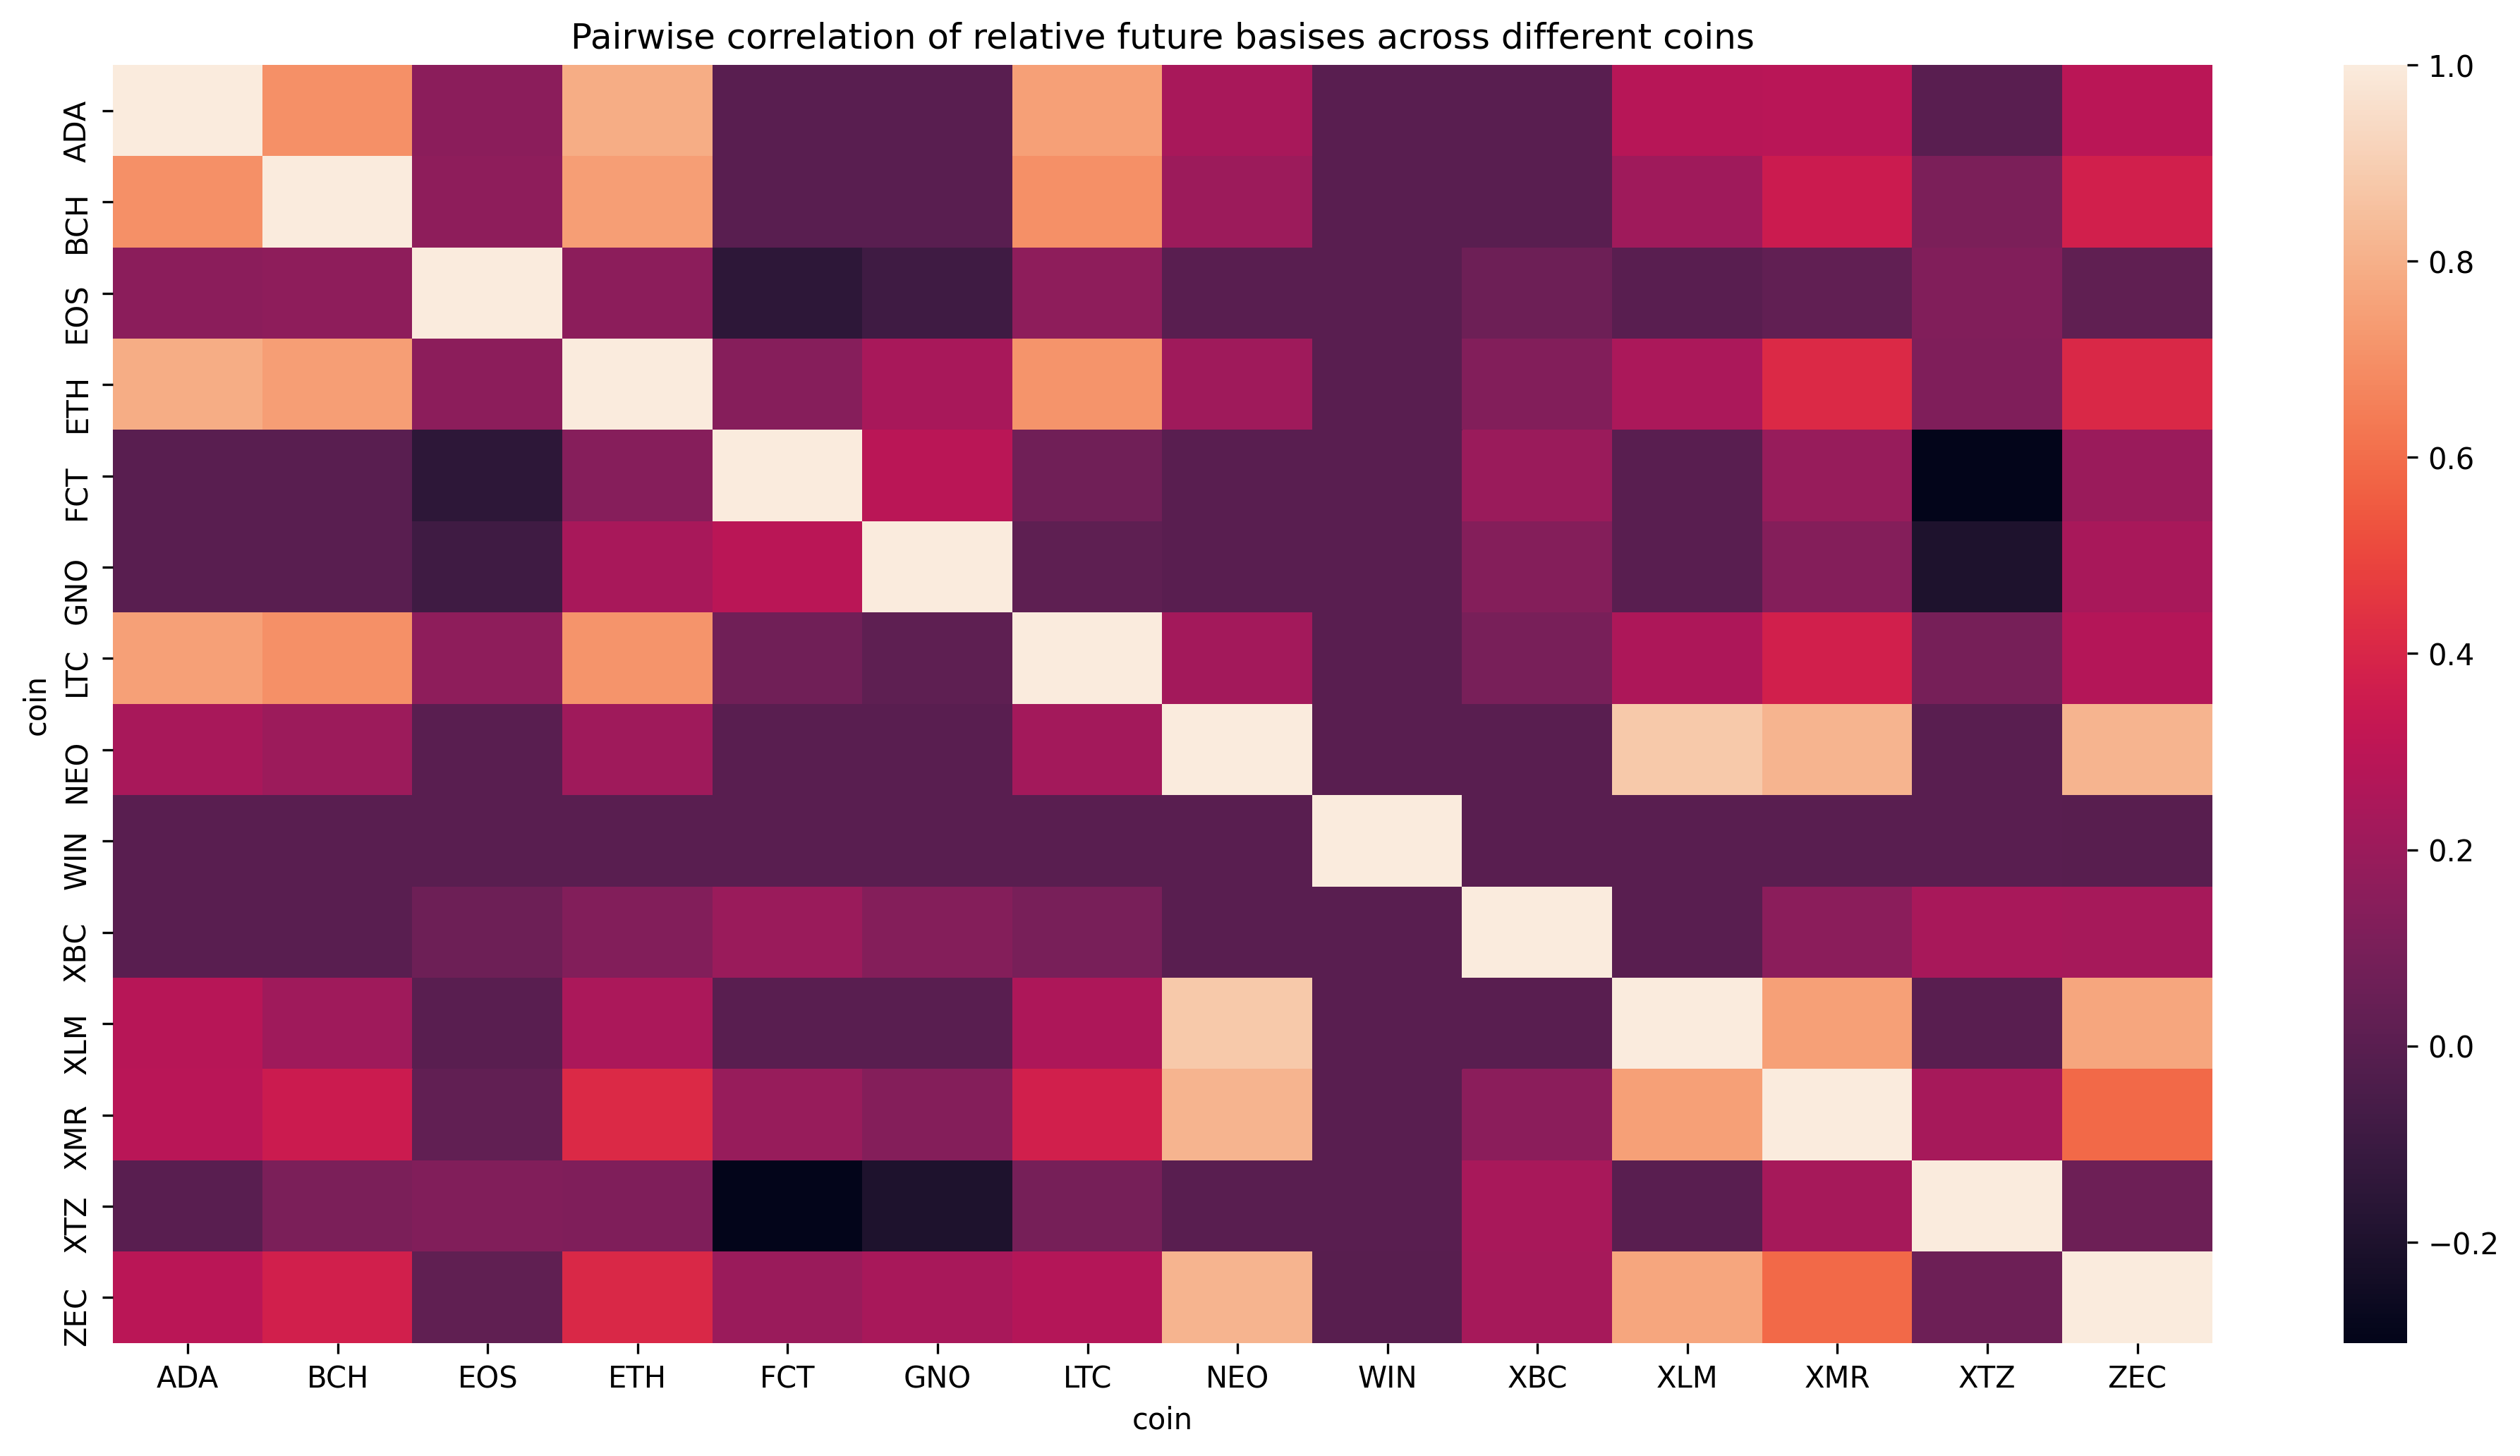

In [205]:
f, ax = plt.subplots(figsize=(16, 8), dpi=300)

corr = futures_bitmex.reset_index().pivot_table(index='index', columns=['coin'])['close'].pct_change().corr().fillna(0)

sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
ax.set_title('Pairwise correlation of relative future basises across different coins')


plt.savefig('imgs/pairwise_corr_basises.png')
plt.show()

### Первый пример

Для начала попробуем реализовать стратегию, когда мы покупаем спот и стараемся как можно быстрее закрыть позиции.

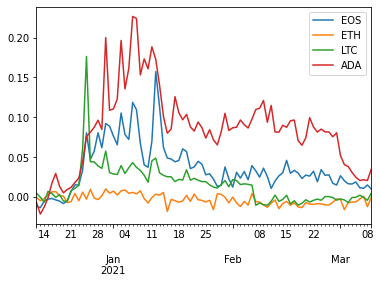

In [206]:
all_batches['EOSH21']['carry'].plot(label='EOS')
all_batches['ETHH21']['carry'].plot(label='ETH')
all_batches['LTCH21']['carry'].plot(label='LTC')
all_batches['ADAH21']['carry'].plot(label='ADA')
plt.legend()

In [248]:
all_batches['ETHH21']

futures  trades   volume     carry  ar_carry         spot
2020-12-12   546.435907    42.0    208.0 -0.000829  0.000830   545.982835
2020-12-13   571.171487   174.0    399.0 -0.004924  0.004949   568.358753
2020-12-14   591.578542   125.0    516.0 -0.002120  0.002124   590.324440
2020-12-15   584.347504   320.0   1287.0  0.002044 -0.002040   585.541895
2020-12-16   585.497081   412.0   2394.0  0.006097 -0.006060   589.066832
...                 ...     ...      ...       ...       ...          ...
2021-03-05  1556.354791  1807.0   5647.0 -0.006332  0.006373  1546.499621
2021-03-06  1543.446660  5228.0  12581.0 -0.002850  0.002858  1539.048429
2021-03-07  1660.776208  1585.0   3974.0  0.000694 -0.000693  1661.927970
2021-03-08  1749.263327  6106.0  13977.0 -0.012463  0.012620  1727.463096
2021-03-09  1839.348037  2500.0   6569.0 -0.000987  0.000988  1837.533031

[88 rows x 6 columns]

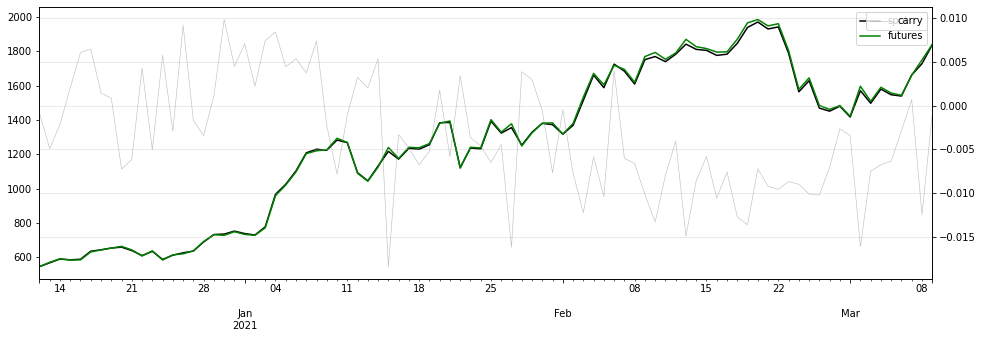

In [249]:
contract = 'ETHH21'

fig, ax = plt.subplots(figsize=(16, 5))
all_batches[contract]['spot'].plot(ax=ax, label='spot', color='black')
all_batches[contract]['futures'].plot(ax=ax, label='futures', color='green')


ax2 = ax.twinx()
all_batches[contract]['carry'].plot(ax=ax2, color='grey', alpha=0.5, lw='0.6')
plt.grid(alpha=0.3)
ax.legend()
ax2.legend()


In [250]:
from dataclasses import dataclass

@dataclass
class ArbitrageOrder:
    contract:      str
    date_start:    str
    date_end:      str
        
    spot_start:    float
    future_start:  float
    signal_start:  int
    carry_start:   float
        
    spot_end:      float
    future_end:    float        
    signal_end:    int
    carry_end:     float
        
    cost_of_capital: float = 0.04 / 365   # american rates
        
    r:             float = None 
    annual_r:      float = None
    daily_r:       float = None
    profit:        float = None
    days_passed:   int = None
    hold_return:   float = None
        
        
    def __post_init__(self):
        self.days_passed = self.date_end - self.date_start
        
        if self.signal_start == 'BUY':
            self.profit = - self.future_start + self.spot_start + self.future_end - self.spot_end - ((1 + self.cost_of_capital) ** self.days_passed.days - 1) * self.spot_start 
            self.r = self.profit / self.spot_start 
            
        elif self.signal_start == 'SELL':
            self.profit = - self.spot_start + self.future_start - self.future_end + self.spot_end - ((1 + self.cost_of_capital) ** self.days_passed.days - 1) * self.future_start 
            self.r = self.profit / self.future_start 
        
        self.daily_r = self.r / self.days_passed.days
        self.annual_r = (self.daily_r + 1) ** 365 - 1
        
        self.hold_return = (1 + all_batches[self.contract]['spot'].loc[self.date_start:self.date_end].pct_change()).prod() - 1 
           
            


In [251]:
def simulate_trading(ex, contract):

    results = []
    same = False

    for date_start, prices_start in ex.iterrows():
        signal_start = prices_start[['BUY', 'SELL']]
        carry_start = prices_start['carry']

        # определяем сигнал
        signal_start = signal_start[signal_start != 0]

        # если сигнал получен и на дату сигнала есть данные
        if signal_start.values and not ex.loc[date_start:, :].empty and len(ex.loc[date_start:, :]) > 5:

            # получаем сам сигнал
            signal_start = signal_start.index[0] # 'SELL' or 'BUY'

            # начинаем ждать досрочного закрытия арбитража
            for date_end, prices_end in ex.loc[date_start:, :].iterrows():

                same = False
                signal_end = prices_end[['BUY', 'SELL']]
                signal_end = signal_end[signal_end != 0]
                carry_end = prices_end['carry']
                
                # Если есть сигнал
                if signal_end.values and not prices_end.empty:
                    signal_end = signal_end.index[0]

                    # Если полученный сигнал на противоположную сделку 
                    if signal_end != signal_start:

                        # Исполняем сделку досрочно
                        results.append(
                            ArbitrageOrder(
                                contract=contract,
                                date_start=date_start,
                                spot_start=prices_start['spot'],
                                future_start=prices_start['futures'],
                                signal_start=signal_start,
                                carry_start=carry_start,
                                date_end=date_end,
                                spot_end=prices_end['spot'],
                                future_end=prices_end['futures'],
                                signal_end=signal_end,
                                carry_end=carry_end
                            )
                        )
                        same = True

                        break
            if not same:
                # Если не удалось выйти раньше конца контракта, закрываемся по рынку:
                results.append(
                    ArbitrageOrder(
                        contract=contract,
                        date_start=date_start,
                        spot_start=prices_start['spot'],
                        future_start=prices_start['futures'],
                        signal_start=signal_start,
                        date_end=date_end,
                        spot_end=0,
                        future_end=0,
                        signal_end='SETTLEMENT',
                        carry_start=carry_start,
                        carry_end=carry_end
                    )
                )
    return results

In [252]:
THRESH_BUY = 0.0075
THRESH_SELL = -0.0075 

def generate_orders(contract, thresh_buy, thresh_sell):
    buy_orders = all_batches[contract][all_batches[contract]['carry'] >= thresh_buy]
    buy_orders = all_batches[contract][all_batches[contract]['carry'] <= thresh_sell]


    all_batches[contract]['BUY'] = np.where(all_batches[contract]['carry'] >= thresh_buy, 1, 0)
    all_batches[contract]['SELL'] = np.where(all_batches[contract]['carry'] <= thresh_sell, -1, 0)
    return all_batches


simulations = {}
for contract in tqdm(list(all_batches.keys())):
    generate_orders(contract, THRESH_BUY, THRESH_SELL)
    ex = all_batches[contract]
    simulation_result = simulate_trading(ex, contract)
    simulations.update({contract: simulation_result})
    

  0%|          | 0/96 [00:00<?, ?it/s]

In [253]:
simulations.keys()

dict_keys(['BCHF18', 'ETHH18', 'LTCH18', 'XMRH18', 'ZECH18', 'ADAF18', 'XLMF18', 'ADAH18', 'BCHH18', 'XLMH18', 'NEOG18', 'NEOH18', 'ADAM18', 'BCHM18', 'ETHM18', 'LTCM18', 'EOSM18', 'ADAU18', 'BCHU18', 'EOSU18', 'ETHU18', 'LTCU18', 'ADAZ18', 'BCHZ18', 'EOSZ18', 'ETHZ18', 'LTCZ18', 'ADAH19', 'BCHH19', 'EOSH19', 'ETHH19', 'LTCH19', 'ADAM19', 'BCHM19', 'EOSM19', 'ETHM19', 'LTCM19', 'ADAU19', 'BCHU19', 'EOSU19', 'ETHU19', 'LTCU19', 'ADAZ19', 'BCHZ19', 'EOSZ19', 'ETHZ19', 'LTCZ19', 'ADAH20', 'BCHH20', 'EOSH20', 'ETHH20', 'LTCH20', 'ADAM20', 'BCHM20', 'EOSM20', 'ETHM20', 'LTCM20', 'ADAU20', 'BCHU20', 'EOSU20', 'ETHU20', 'LTCU20', 'ADAZ20', 'BCHZ20', 'EOSZ20', 'ETHZ20', 'LTCZ20', 'ADAH21', 'BCHH21', 'EOSH21', 'ETHH21', 'LTCH21', 'ZECZ16', 'XBCZ16', 'XBCH17', 'ZECH17', 'XBCM17', 'ZECM17', 'ETHJ17', 'XMRJ17', 'GNOM17', 'ETHM17', 'FCTM17', 'LTCM17', 'XMRM17', 'ETHU17', 'LTCU17', 'XMRU17', 'ZECU17', 'EOSN17', 'ETHZ17', 'LTCZ17', 'XMRZ17', 'ZECZ17', 'BCHX17', 'BCHZ17'])

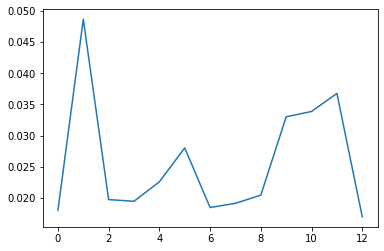

In [267]:
pd.DataFrame(simulations['NEOH18'])['r'].plot()

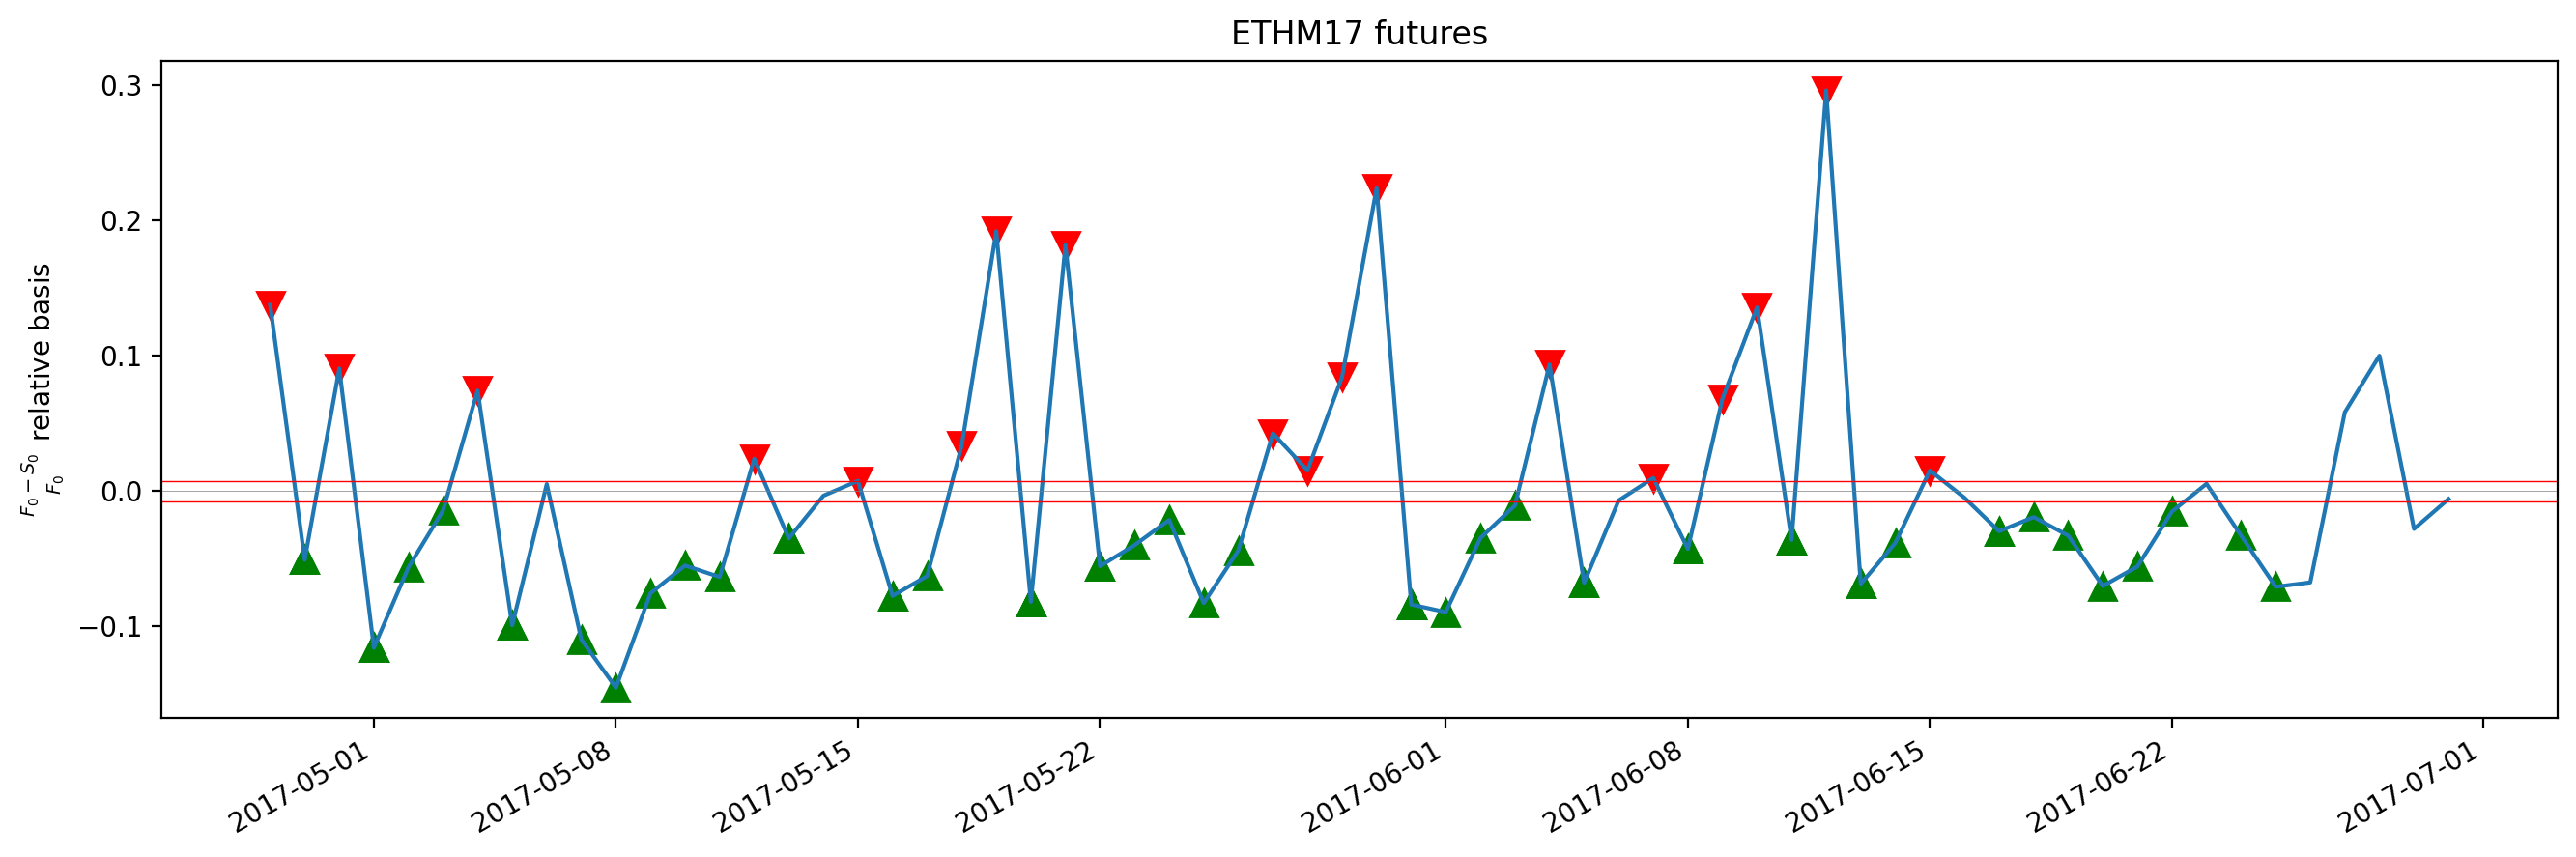

In [307]:
f, ax = plt.subplots(figsize=(16, 5), dpi=200)

SYMBOL = 'ETHM17'



simulations_pd = pd.DataFrame(simulations[SYMBOL])


# Plot the buy signals
ax.plot(simulations_pd[simulations_pd['signal_start'] == 'BUY']['date_start'], 
             simulations_pd[simulations_pd['signal_start'] == 'BUY']['carry_start'],
             'v', markersize=10, color='red')

ax.plot(simulations_pd[simulations_pd['signal_start'] == 'SELL']['date_start'], 
             simulations_pd[simulations_pd['signal_start'] == 'SELL']['carry_start'],
             '^', markersize=10, color='green')

ax.plot(simulations_pd[simulations_pd['signal_end'] == 'SELL']['date_end'], 
            simulations_pd[simulations_pd['signal_end'] == 'SELL']['carry_end'],
             '^', markersize=10, color='green')

all_batches[SYMBOL]['carry'].plot(ax=ax)
plt.axhline(y=THRESH_BUY, color='r', linestyle='-', lw=0.5);
plt.axhline(y=0.0, color='gray', linestyle='-', lw=0.25);
plt.axhline(y=THRESH_SELL, color='r', linestyle='-', lw=0.5);

ax.set_title(f'{SYMBOL} futures')
ax.set_ylabel(r'$\frac{F_0 - S_0}{F_0}$ relative basis');
plt.savefig('imgs/cash_and_carry_trade_17.png')

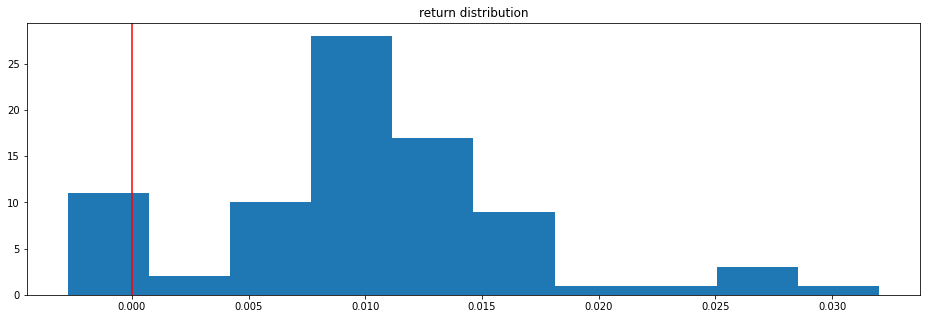

In [270]:
simulations_pd['r'].hist(figsize=(16, 5), grid = False);
plt.title('return distribution')
plt.axvline(0, color='r');


In [308]:
@dataclass
class MeanTest:
    symbol: str
    returns: float
    index: float
        
    description: str = None
        
    mean_estimation: float = None
    mean_std: float = None
    mean_p_value: float = None
        
    independent_estimation: float = None
    independent_std: float = None
    independent_p_value: float = None
    year: int = None
        
    results: str = None
        
    def __post_init__(self):
        self.results = sm.OLS(self.returns, sm.add_constant(self.index)).fit()
        self.mean_estimation = self.results.params['const']
        self.mean_std = np.sqrt(self.results.cov_params()['const'])['const']
        self.mean_p_value = self.results.pvalues['const']
        self.year = self.symbol[-2:]
        
        if 'excess' in self.results.params.index:
            self.independent_estimation = self.results.params['excess']
            self.independent_std = np.sqrt(self.results.cov_params()['excess'])['excess']
            self.independent_p_value = self.results.pvalues['excess']
        
        if 'CCMIX' in self.results.params.index:
            self.independent_estimation = self.results.params['CCMIX']
            self.independent_std = np.sqrt(self.results.cov_params()['CCMIX'])['CCMIX']
            self.independent_p_value = self.results.pvalues['CCMIX']
          
        
@dataclass
class DMBeta:
    returns: None
    market: None
    symbol: str
        
    alpha: None = None
    beta: None = None
    upside_market_beta: None = None
        
    alpha_p: None = None
    beta_p: None = None
    upside_market_beta_p: None = None
    year: None = None
    
    
    def __post_init__(self):
        self.results = sm.OLS(self.returns, sm.add_constant(self.market)).fit()
        self.alpha, self.beta, self.upside_market_beta = self.results.params
        self.alpha_p, self.beta_p, self.upside_market_beta_p = self.results.pvalues
        self.year = self.symbol[-2:]


In [309]:
# Percentage winning trades
def get_percentage_winning_trades(symbol):
    r_data = pd.DataFrame(simulations[symbol])['r'] 
    return r_data[r_data >= 0].count() / (r_data[r_data < 0].count() + r_data[r_data >= 0].count())

# Net Profit
def get_net_profit(symbol):
    return pd.DataFrame(simulations[symbol])['profit'].sum()

# Average return per trade
def get_average_return_per_trade(symbol):
    return pd.DataFrame(simulations[symbol])['r'].mean()
    
# Average profit per trade
def get_average_profit_per_trade(symbol):
    return pd.DataFrame(simulations[symbol])['profit'].mean()
    
# Average profit per day
def get_average_return_per_day(symbol):
    return (pd.DataFrame(simulations[symbol])['r'] / pd.DataFrame(simulations[symbol])['days_passed'].dt.days).mean()
    
    
@dataclass
class PerformanceStats:
    symbol: str
    returns: float 
    risk_free: float 
    
    sharpe: float = None
    winning_trades: int = None
    net_profit: float = None
    average_return_per_trade: float = None
    average_profit_per_trade: float = None
    average_return_per_day: float = None
    year: int = None
        
        
    def __post_init__(self):
        self.winning_trades = get_percentage_winning_trades(self.symbol)
        self.net_profit = get_net_profit(self.symbol)
        self.average_return_per_trade = get_average_return_per_trade(self.symbol)
        self.average_profit_per_trade = get_average_profit_per_trade(self.symbol)
        self.year = self.symbol[-2:]
        self.sharpe = np.mean(self.returns - self.risk_free) / np.std(self.returns - self.risk_free)
        

get_percentage_winning_trades('ADAH21')

symbol = 'ADAH21'
pd.DataFrame(simulations[symbol])['days_passed']


0     3 days
1     2 days
2    83 days
3    82 days
4    81 days
       ...  
75    9 days
76    8 days
77    7 days
78    6 days
79    5 days
Name: days_passed, Length: 80, dtype: timedelta64[ns]

In [310]:

all_data = []
for symbol in tqdm(all_batches.keys()):
    if symbol not in ['XBCM17', 'XBCZ16', 'XBCH17']:
        dates = pd.DataFrame(simulations[symbol])['date_start']
        risk_free_ = risk_free.loc[dates]['risk_free']
        strat_return = pd.DataFrame(simulations[symbol])['r'].values
        all_data.append(
            PerformanceStats(
                symbol=symbol,
                returns=strat_return,
                risk_free=risk_free_
            ))
    
    

  0%|          | 0/96 [00:00<?, ?it/s]

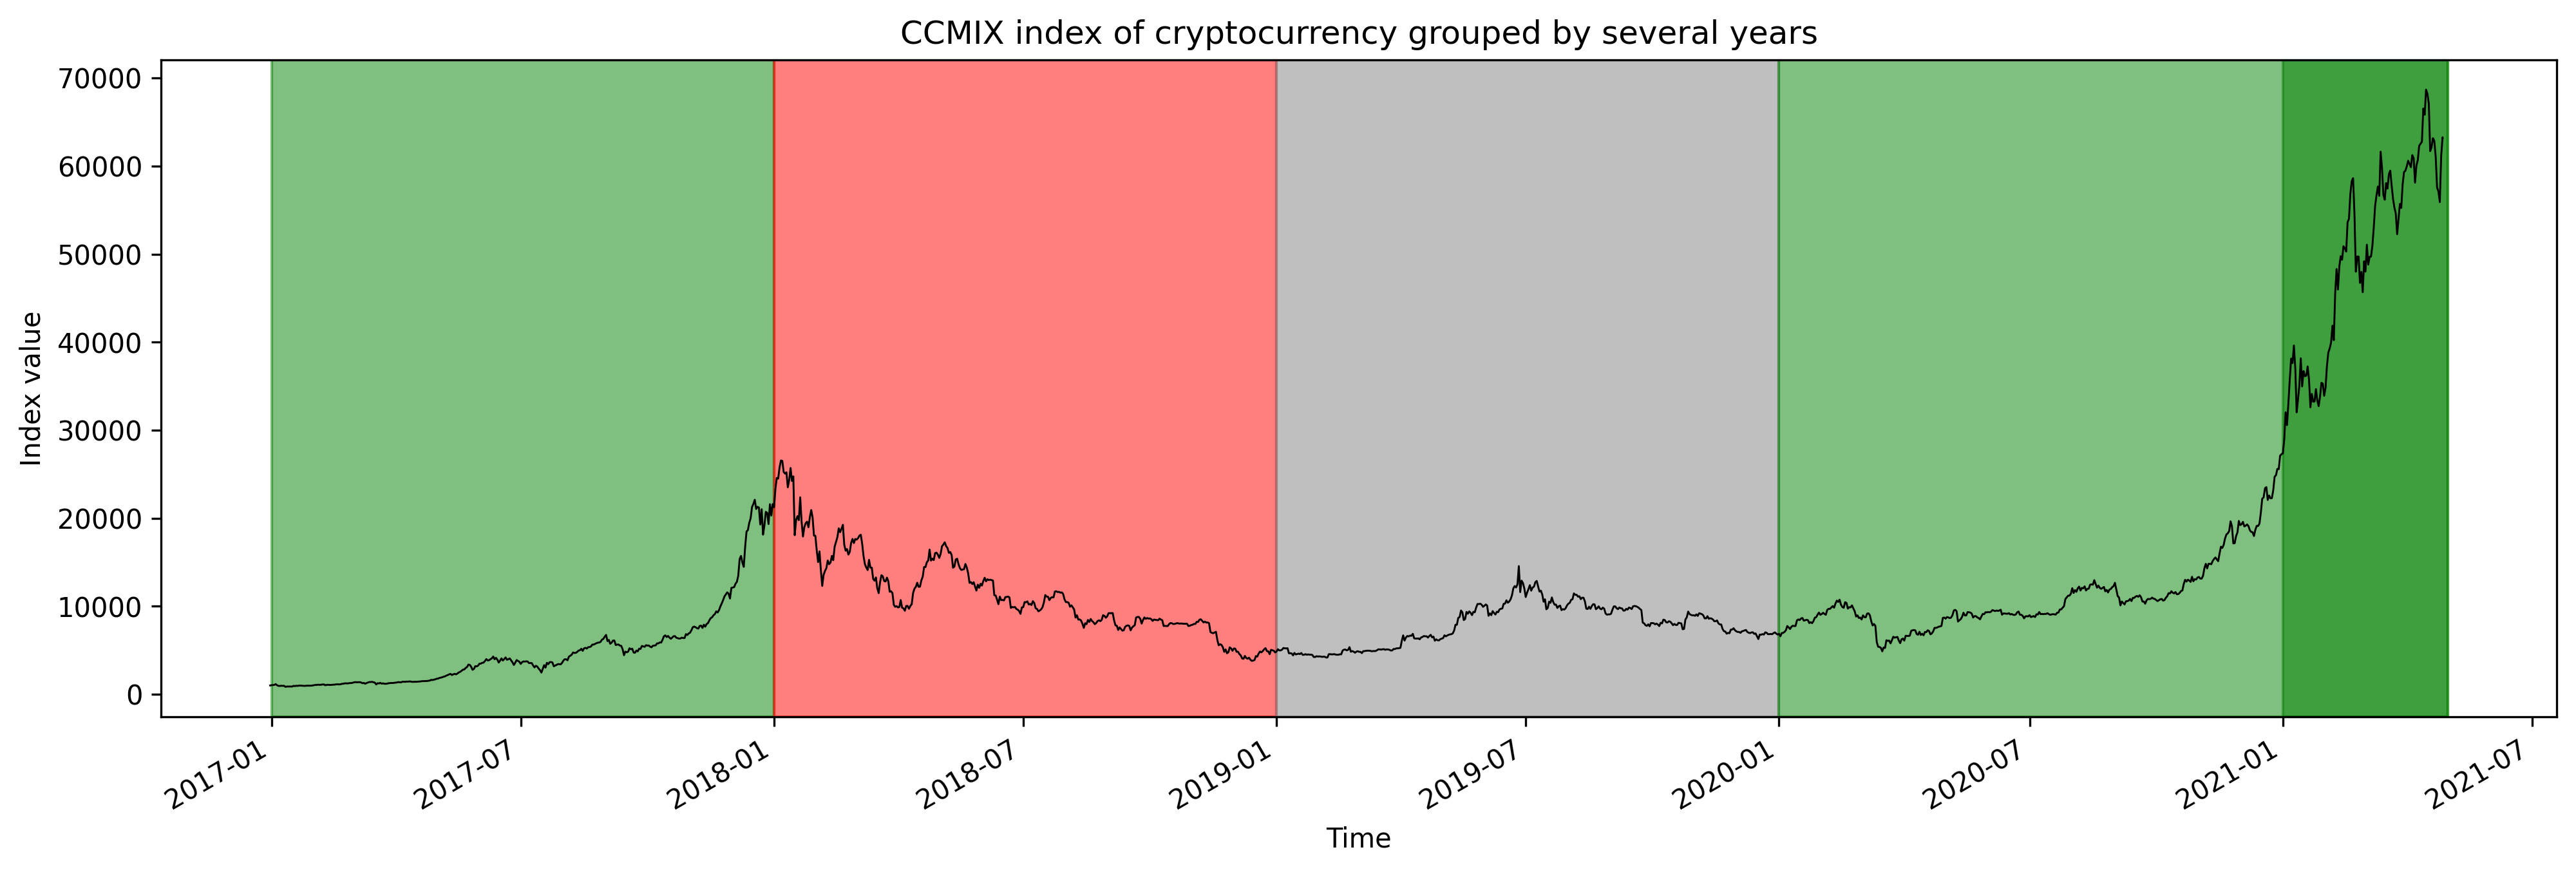

In [311]:
f, ax = plt.subplots(figsize=(16,5), dpi=300)
ccmix_index['CCMIX'].plot(ax=ax, c='black', lw='0.7')
ax.set_title('CCMIX index of cryptocurrency grouped by several years')
ax.set_ylabel('Index value')
ax.set_xlabel('Time')

ax.axvspan('2017-01-01', '2018-01-01', alpha=0.5, color='green')
ax.axvspan('2018-01-01', '2019-01-01', alpha=0.5, color='red')
ax.axvspan('2019-01-01', '2020-01-01', alpha=0.5, color='grey')
ax.axvspan('2020-01-01', '2021-05-01', alpha=0.5, color='green')
ax.axvspan('2021-01-01', '2021-05-01', alpha=0.5, color='green');

plt.savefig('imgs/CCMIX_over_years.png')

### Важные выводы по симуляциям

In [390]:
pd.DataFrame(all_data).groupby('year').mean()[['sharpe', 'winning_trades', 'average_return_per_trade']]



sharpe  winning_trades  average_return_per_trade
year                                                    
16    1.321817        1.000000                  0.314574
17    1.789733        1.000000                  0.152527
18    0.561409        0.994604                  0.046879
19   -1.136554        0.945855                  0.016673
20    1.897906        0.967018                  0.018371
21    1.728116        1.000000                  0.037676

### Buy and hold сравнение

In [313]:
all_results = []

for symbol in tqdm(all_batches.keys()):
    if symbol not in ['XBCM17', 'XBCZ16', 'XBCH17']:
# symbol = 'ETHH21'
        try:
            dates = pd.DataFrame(simulations[symbol])['date_start']
            risk_free_ = risk_free.loc[dates]['risk_free']
            strat_return = pd.DataFrame(simulations[symbol])['r'].values
            market_return = ccmix_index.loc[dates]['CCMIX'].pct_change().fillna(0)


            # market_return = all_batches[symbol].loc[pd.DataFrame(simulations[symbol])['date_start']]['spot'].pct_change().fillna(0)

            results = MeanTest(returns=strat_return,
                     index=market_return,
                     symbol=symbol,
                     year=symbol[-2:]) 

            all_results.append(results)
        except:
            print(symbol)

# Если альфа значимая, то у нас больше чем доходность отдельного коина
# Если бета незначимая, то у нас доходность не зависит от доходности коина

  0%|          | 0/96 [00:00<?, ?it/s]

ZECZ16
ZECH17


In [314]:
all_simulations = pd.DataFrame(all_results)
all_simulations['coin'] = all_simulations.symbol.str[:3]

# All contracts had positive significant return over market return
all_simulations[(all_simulations['mean_p_value'] < 0.05) & (all_simulations['mean_estimation'] > 0)]

# Contracts with significant beta mostly from 2020
all_simulations[(all_simulations['independent_p_value'] < 0.05)]['year'].value_counts()

20    4
17    3
19    1
18    1
Name: year, dtype: int64

In [322]:
res = all_simulations.groupby(['year', 'coin']).mean()
res.columns = ['alpha', 'alpha_std', 'alpha_p_value', 'beta', 'beta_std', 'beta_p_value']
res = round(res, 3)
res = res.astype(str)
res['alpha'] = res['alpha'].str.cat(res['alpha_p_value'], ' (')
res['alpha'] = res['alpha'] + ')'

res['beta'] = res['beta'].str.cat(res['beta_p_value'], ' (')
res['beta'] = res['beta'] + ')'

res = res[['alpha', 'beta']]

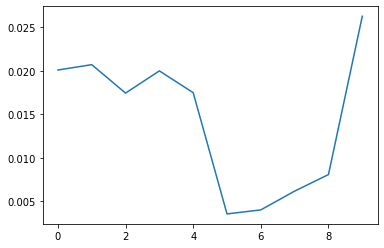

In [323]:
plt.plot(all_simulations[all_simulations['symbol'] == 'ETHH20']['returns'].iloc[0])

In [324]:
res

alpha            beta
year coin                               
17   BCH     0.33 (0.02)  -7.328 (0.543)
     EOS     0.185 (0.0)  -0.034 (0.932)
     ETH     0.107 (0.0)   0.147 (0.433)
     FCT      0.19 (0.0)   0.095 (0.783)
     GNO     0.193 (0.0)  -0.118 (0.641)
     LTC      0.15 (0.0)   0.405 (0.305)
     XMR     0.121 (0.0)   0.334 (0.311)
     ZEC     0.149 (0.0)   0.202 (0.211)
18   ADA     0.065 (0.0)   0.031 (0.314)
     BCH     0.047 (0.0)  -0.074 (0.655)
     EOS     0.024 (0.0)  -0.018 (0.493)
     ETH     0.026 (0.0)     0.023 (0.5)
     LTC     0.034 (0.0)   0.019 (0.347)
     NEO   0.027 (0.019)  -0.111 (0.424)
     XLM   0.073 (0.009)  -0.013 (0.724)
     XMR     0.097 (0.0)  -0.043 (0.741)
     ZEC     0.104 (0.0)   0.131 (0.361)
19   ADA     0.029 (0.0)  -0.001 (0.755)
     BCH    0.013 (0.06)  -0.015 (0.602)
     EOS    0.015 (0.03)  -0.023 (0.483)
     ETH   0.014 (0.002)  -0.005 (0.497)
     LTC   0.012 (0.003)  -0.004 (0.573)
20   ADA     0.026 (0.0)   0.034 (0.288)
     BCH     0.021 (0.0)   0.015 (0.289)
     EOS     0.019 (0.0)   0.007 (0.108)
     ETH   0.011 (0.003)  -0.012 (0.579)
     LTC     0.015 (0.0)   0.004 (0.219)
21   ADA     0.078 (0.0)   0.076 (0.359)
     BCH     0.029 (0.0)   0.022 (0.555)
     EOS     0.035 (0.0)   0.077 (0.119)
     ETH      0.01 (0.0)  -0.008 (0.557)
     LTC     0.034 (0.0)   0.011 (0.847)

In [317]:
res.loc['21', :]

alpha          beta
coin                           
ADA   0.078 (0.0)   0.076 (0.0)
BCH   0.029 (0.0)   0.022 (0.0)
EOS   0.035 (0.0)   0.077 (0.0)
ETH    0.01 (0.0)  -0.008 (0.0)
LTC   0.034 (0.0)   0.011 (0.0)

### Coin beta/alpha

In [1862]:
symbol = 'ETHH21'

all_results = []
for symbol in tqdm(all_batches.keys()):
    if symbol not in ['XBCM17', 'XBCZ16', 'XBCH17']:

        try:
            dates = pd.DataFrame(simulations[symbol])['date_start']
            strat_return = pd.DataFrame(simulations[symbol])['r'].values
            market_return = ccmix_index.loc[dates]['CCMIX'].pct_change().fillna(0)
            risk_free_ = risk_free.loc[dates]['risk_free']

            excess_return = market_return - risk_free_
            excess_return.name = 'excess'


            results = MeanTest(returns=strat_return - risk_free_,
                     index=excess_return,
                     symbol=symbol,
                     year=2021) 
            all_results.append(results)
        except:
            print(symbol)

# доходность над рынком

results.results.summary()

  0%|          | 0/96 [00:00<?, ?it/s]

ZECZ16
ZECH17


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              risk_free   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                 0.0004896
Date:                Fri, 30 Apr 2021   Prob (F-statistic):              0.982
Time:                        17:50:52   Log-Likelihood:                 16.758
No. Observations:                  32   AIC:                            -29.52
Df Residuals:                      30   BIC:                            -26.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2294      0.026      8.697      0.000       0.176       0.283
excess        -0.0097      0.438     -0.022      0.982      -0.904       0.884
==============================================================================
Omnibus:                        4.691   Durbin-Watson:                   0.942
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                3.932
Skew:                           0.858   Prob(JB):                        0.140
Kurtosis:                       2.963   Cond. No.                         16.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1870]:
all_simulations = pd.DataFrame(all_results)
all_simulations['coin'] = all_simulations.symbol.str[:3]


# More than half of the contracts had significant positive alpha
all_simulations[(all_simulations['mean_p_value'] < 0.05)]['year'].value_counts()

# Contracts with significant beta mostly from 2020
all_simulations[(all_simulations['independent_p_value'] > 0.05)]['year'].value_counts()

79

In [2084]:
res = all_simulations.groupby(['year', 'coin']).mean()
res
res.columns = ['alpha', 'alpha_std', 'alpha_p_value', 'beta', 'beta_std', 'beta_p_value']
res = round(res, 3)
res = res.astype(str)
res['alpha'] = res['alpha'].str.cat(res['alpha_std'], ' (')
res['alpha'] = res['alpha'] + ')'

res['beta'] = res['beta'].str.cat(res['beta_std'], ' (')
res['beta'] = res['beta'] + ')'

res = res[['alpha', 'beta']]
res.reset_index().coin.unique()

array(['EOS', 'ETH', 'FCT', 'GNO', 'LTC', 'XMR', 'ZEC', 'ADA', 'BCH',
       'NEO', 'XLM'], dtype=object)

In [2085]:
res

alpha           beta
year coin                               
17   EOS    0.176 (0.104)  0.001 (0.805)
     ETH     0.087 (0.19)  0.029 (0.404)
     FCT    0.184 (0.235)  0.056 (0.627)
     GNO   0.067 (-0.097)  0.415 (0.817)
     LTC    0.111 (0.332)   0.198 (0.29)
     XMR     0.09 (0.321)   0.102 (0.32)
     ZEC    0.174 (0.249)    0.0 (0.146)
18   ADA    0.038 (0.072)  0.018 (0.394)
     BCH   0.038 (-0.111)   0.001 (0.54)
     EOS   0.016 (-0.021)    0.0 (0.584)
     ETH    0.013 (0.037)  0.001 (0.429)
     LTC    0.019 (0.014)    0.0 (0.438)
     NEO   0.022 (-0.067)    0.0 (0.463)
     XLM    0.07 (-0.032)  0.007 (0.538)
     XMR   0.041 (-0.022)    0.0 (0.838)
     ZEC    0.044 (0.208)  0.002 (0.198)
19   ADA    0.021 (0.009)    0.0 (0.498)
     BCH     0.01 (0.005)    0.0 (0.654)
     EOS     0.016 (-0.0)    0.0 (0.614)
     ETH    0.011 (0.014)    0.0 (0.525)
     LTC   0.011 (-0.006)    0.0 (0.426)
20   ADA     0.013 (0.02)    0.0 (0.214)
     BCH    0.009 (0.011)  0.012 (0.332)
     EOS    0.011 (0.009)    0.0 (0.184)
     ETH    0.006 (0.003)    0.0 (0.469)
     LTC     0.009 (0.02)    0.0 (0.043)
21   ADA    0.067 (0.105)     0.0 (0.31)
     BCH    0.014 (0.034)  0.002 (0.351)
     EOS     0.018 (0.11)  0.009 (0.062)
     ETH    0.011 (0.009)    0.0 (0.409)
     LTC    0.023 (0.062)   0.002 (0.31)

### Downside risk beta

In [387]:
symbol = 'ETHH21'
all_results = []
for symbol in tqdm(all_batches.keys()):
    if symbol not in ['XBCM17', 'XBCZ16', 'XBCH17']:
    
        try:
            dates = pd.DataFrame(simulations[symbol])['date_start']
            strat_return = pd.DataFrame(simulations[symbol])['r'].values
            market_return = ccmix_index.loc[dates][['return', 'dummy']].values
            risk_free_ = risk_free.loc[dates]['risk_free']

            # excess_return = market_return - risk_free_
            # excess_return.name = 'excess'


            results = DMBeta(
                returns=strat_return,
                market=market_return,
                symbol=symbol
            ) 
            all_results.append(results)
        except:
            print(symbol)

# доходность над рынком

results.results.summary()

  0%|          | 0/96 [00:00<?, ?it/s]

ETHZ20
ZECZ16
ZECH17
BCHX17
BCHZ17


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.815
Date:                Wed, 05 May 2021   Prob (F-statistic):             0.0256
Time:                        03:04:06   Log-Likelihood:                 106.18
No. Observations:                  95   AIC:                            -206.4
Df Residuals:                      92   BIC:                            -198.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2164      0.028      7.609      0.000       0.160       0.273
x1             0.4242      0.197      2.154      0.034       0.033       0.815
x2            -0.0572      0.030     -1.918      0.058      -0.116       0.002
==============================================================================
Omnibus:                       12.112   Durbin-Watson:                   1.192
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.741
Skew:                           0.789   Prob(JB):                      0.00171
Kurtosis:                       3.855   Cond. No.                         32.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [388]:
all_simulations = pd.DataFrame(all_results)
all_simulations['coin'] = all_simulations.symbol.str[:3]

all_simulations[all_simulations['upside_market_beta_p'] < 0.05].sort_values('upside_market_beta', ascending=False)

# The majority contracts had positive significant influence of upside_market_beta
# all_simulations[(all_simulations['upside_market_beta_p'] < 0.05) & (all_simulations['upside_market_beta'] > 0)]['year'].value_counts()



returns  \
5   [0.2909632667165609, 0.29239052955150424, 0.29...   
74  [0.49427031105114555, 0.17544473161230564, 0.2...   
4   [0.12395098392676585, 0.21219975071954508, 0.2...   
3   [0.1964433535296262, 0.08881025785099046, 0.20...   
86  [0.19200439994846363, 0.0834126560832544, 0.12...   
2   [0.27138929624977426, 0.19419768694218684, 0.0...   
81  [0.1510352143636465, 0.1589208595872117, 0.186...   
1   [0.17548206669635816, 0.05348694310305421, 0.1...   
84  [0.05186115125828226, 0.043987546023800665, 0....   
82  [0.11638574679707628, 0.19384888278760556, 0.1...   
13  [0.0013806185199092555, 0.0029717701563825045,...   
15  [0.014889436622910163, -1.1422721342066498e-05...   
68  [0.02630057208246416, 0.028027465297421658, 0....   
57  [-0.00022781364651062682, 0.004401292845537472...   
63  [0.02199073167256371, 0.018455524197765572, 0....   
7   [0.06390049446892793, 0.05282389937853893, 0.0...   
67  [0.019258908098609185, 0.019077605007947328, 0...   
50  [0.020104801837790835, 0.02071995060202193, 0....   
26  [0.013801961615175485, 0.013657864578823887, 0...   
48  [0.026097222205284303, 0.02527328912607145, 0....   
14  [0.04265519217648075, 0.019795979543790934, 0....   
61  [-0.0026430411980372112, 0.0027429810217176713...   
38  [0.017555899577726068, 0.01658045254096938, 0....   
20  [-0.0024026342664754193, 0.004321566389731841,...   
29  [0.03814979460636436, 0.026865032406095814, 0....   
53  [0.03772320054120909, 0.026206082156274065, 0....   
55  [0.017186515627105527, 0.01872152051806888, 0....   
37  [0.058967648785714505, 0.062385094126393294, 0...   
44  [-0.0016291578310936854, -0.003488297982304997...   

                                               market  symbol     alpha  \
5   [[-0.007672817536511167, 1.0], [0.006075684137...  ADAF18  0.079514   
74  [[0.043748453753990724, 1.0], [0.0024605938157...  GNOM17  0.087073   
4   [[0.016943121167078967, 1.0], [0.0216656027239...  ZECH18  0.055782   
3   [[0.06362572748545015, 1.0], [0.01694312116707...  XMRH18  0.053933   
86  [[0.012131139850188433, 0.0], [-0.083625927513...  XMRZ17  0.117911   
2   [[0.06362572748545015, 1.0], [0.02166560272393...  LTCH18  0.044054   
81  [[-0.06004681840935189, 1.0], [0.0440478148388...  XMRU17  0.094896   
1   [[0.06362572748545015, 1.0], [0.01694312116707...  ETHH18  0.025998   
84  [[0.013927599951381264, 0.0], [0.0806133584662...  ETHZ17  0.093131   
82  [[0.06668411616128567, 1.0], [-0.0600468184093...  ZECU17  0.126869   
13  [[-0.022449437362144442, 0.0], [-0.01461478552...  BCHM18  0.011088   
15  [[-0.022449437362144442, 0.0], [0.004049112204...  LTCM18  0.015883   
68  [[0.039085055890628606, 1.0], [0.0241102470289...  EOSH21  0.018007   
57  [[0.006415351551052106, 0.0], [0.0272604835498...  ADAU20  0.014070   
63  [[-0.022668311264820384, 0.0], [0.013433898862...  BCHZ20  0.024714   
7   [[-0.03227913784266878, 0.0], [0.0594851704706...  ADAH18  0.043602   
67  [[0.039085055890628606, 1.0], [0.0241102470289...  BCHH21  0.019688   
50  [[0.015518750863981134, 1.0], [-0.011355611732...  ETHH20  0.006463   
26  [[0.007332229236246102, 0.0], [0.0004189926642...  LTCZ18  0.014329   
48  [[0.012519762362095399, 1.0], [0.0549475877316...  BCHH20  0.014673   
14  [[-0.022449437362144442, 0.0], [0.007927394446...  ETHM18  0.017986   
61  [[-0.003414117142054307, 0.0], [0.006415351551...  LTCU20  0.002200   
38  [[0.05418564601938747, 0.0], [0.00267661161013...  BCHU19  0.014845   
20  [[0.00367581234096348, 0.0], [-0.0086860316250...  ETHU18  0.005670   
29  [[-0.012166768921343829, 0.0], [0.080185298038...  EOSH19  0.030391   
53  [[-0.0060036321696936845, 0.0], [-0.0172033598...  BCHM20  0.023436   
55  [[-0.0060036321696936845, 0.0], [-0.0111278793...  ETHM20  0.018823   
37  [[0.05418564601938747, 0.0], [0.00267661161013...  ADAU19  0.060866   
44  [[0.024481721610465135, 1.0], [0.0330778681452...  EOSZ19  0.020324   

        beta  upside_market_beta       alpha_p    beta_p  \
5   0.095116            

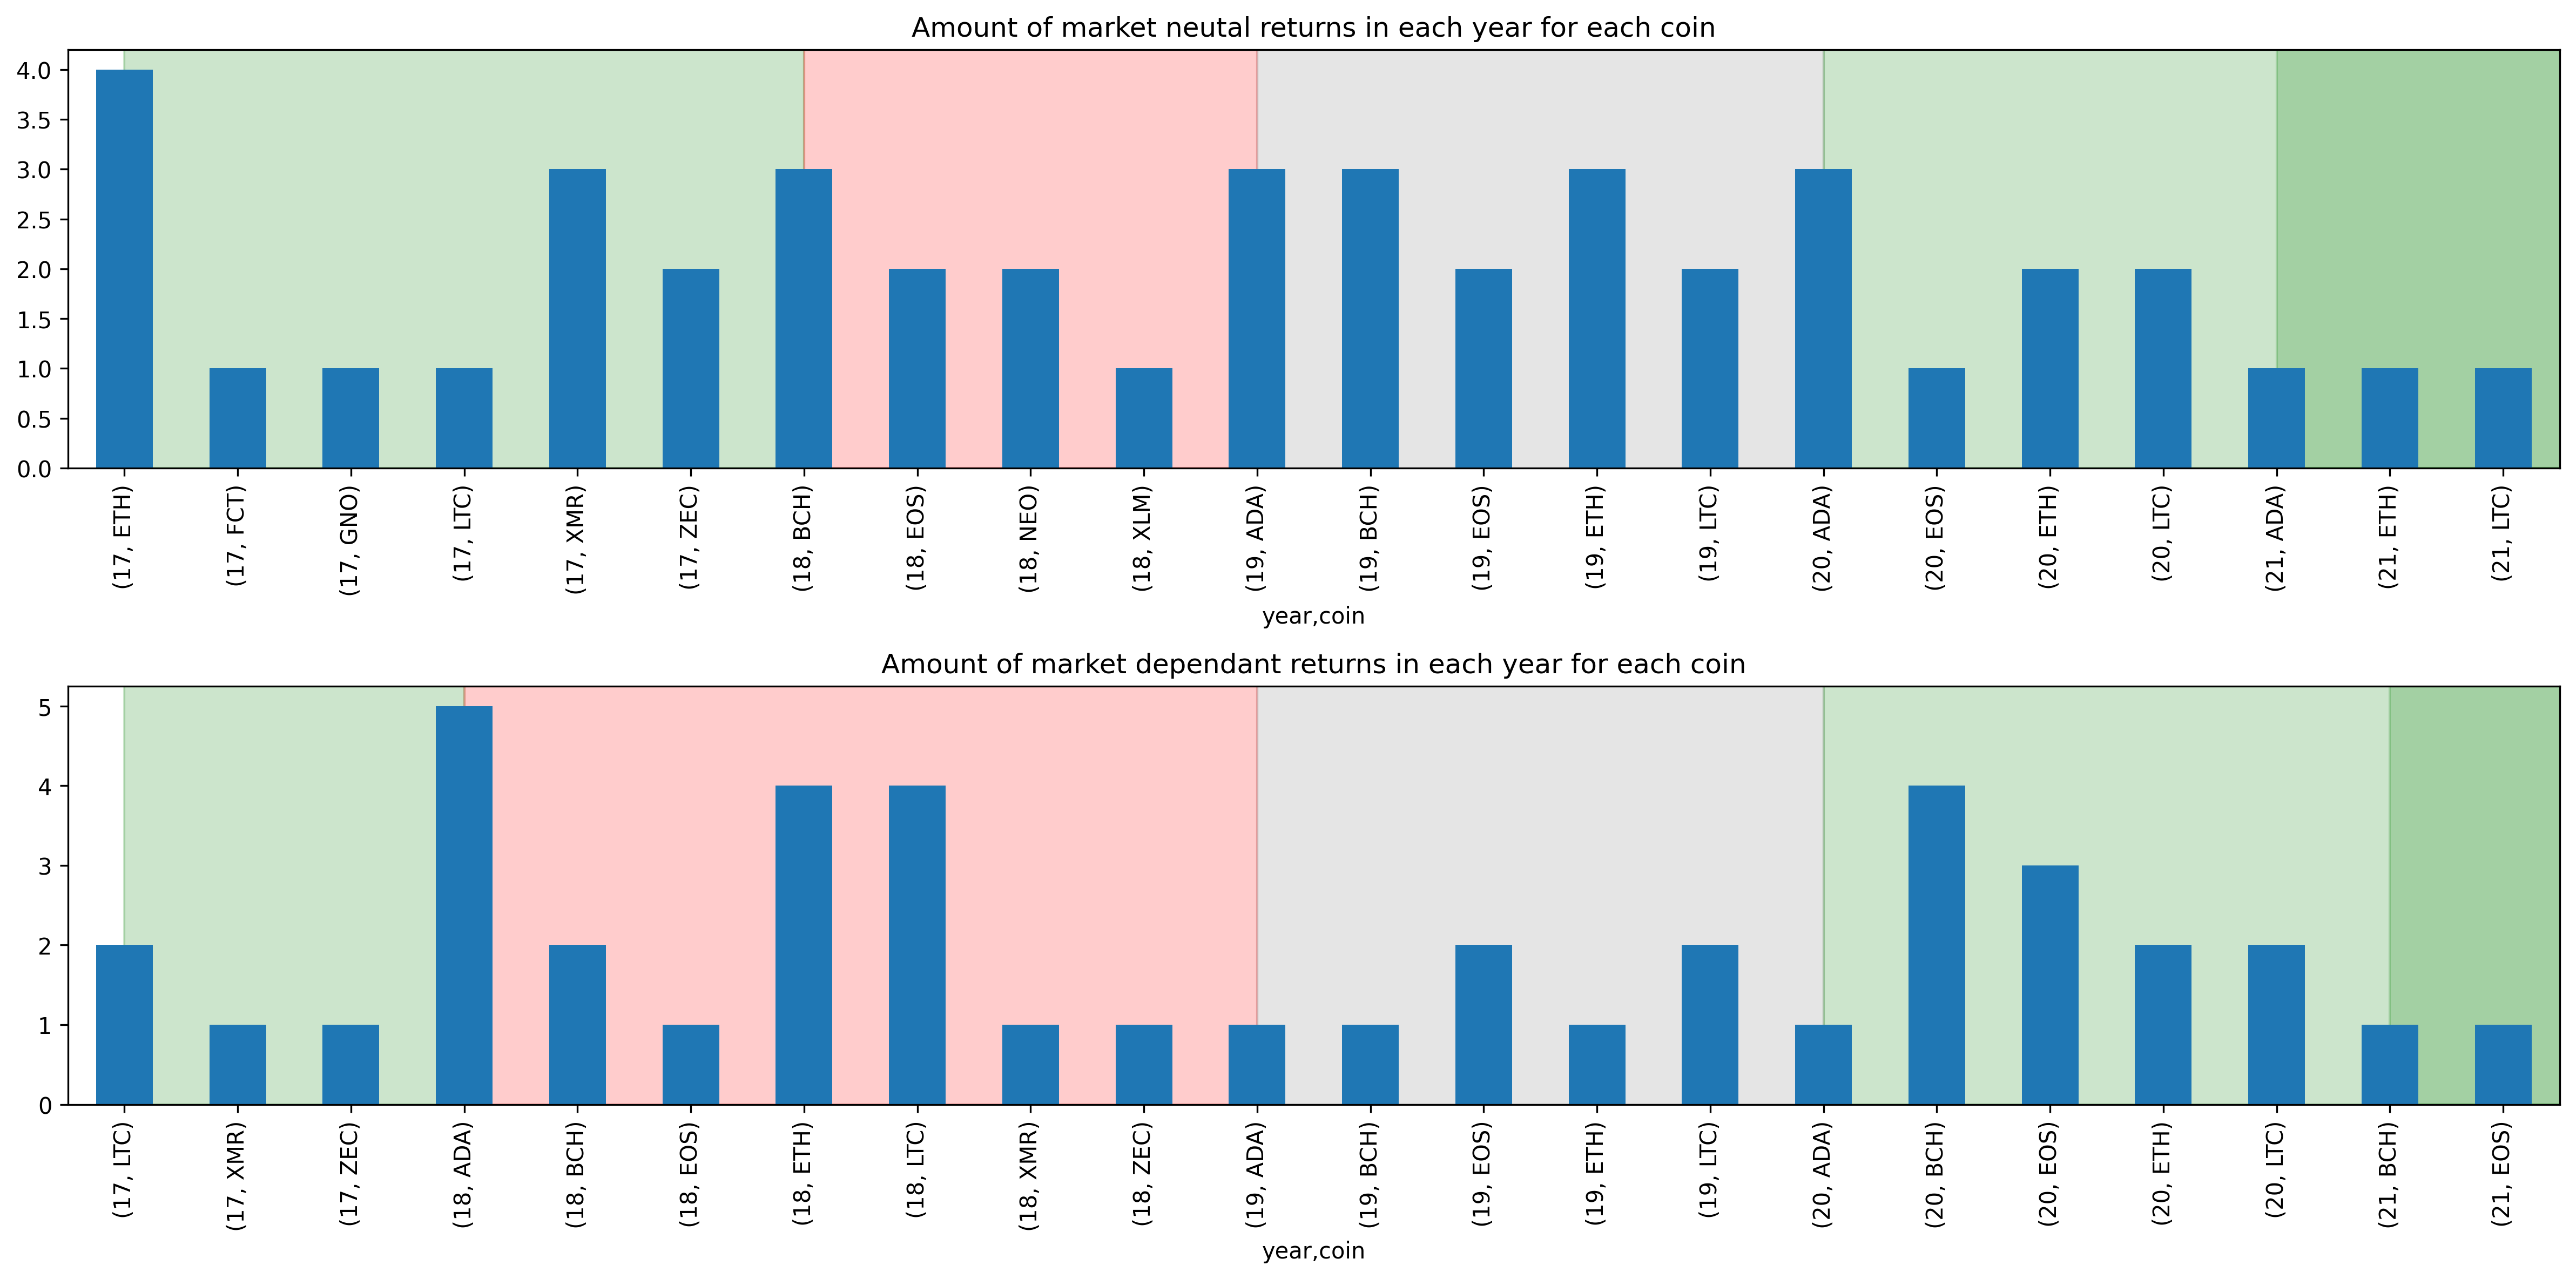

In [1930]:
# 44 contracts which were market neutral to any movements
f, ax = plt.subplots(nrows=2, figsize=(16, 8), dpi=300)
ax[0].set_title('Amount of market neutal returns in each year for each coin')
ax[0].axvspan(0, 6, alpha=0.2, color='green')
ax[0].axvspan(6, 10, alpha=0.2, color='red')
ax[0].axvspan(10, 15, alpha=0.2, color='grey')
ax[0].axvspan(15, 22, alpha=0.2, color='green')
ax[0].axvspan(19, 22, alpha=0.2, color='green')

ax[1].axvspan(0, 3, alpha=0.2, color='green')
ax[1].axvspan(3, 10, alpha=0.2, color='red')
ax[1].axvspan(10, 15, alpha=0.2, color='grey')
ax[1].axvspan(15, 22, alpha=0.2, color='green')
ax[1].axvspan(20, 22, alpha=0.2, color='green')
all_simulations[(all_simulations['upside_market_beta_p'] > 0.05)].groupby(['year', 'coin']).count()['returns'].plot.bar(ax=ax[0])
ax[1].set_title('Amount of market dependant returns in each year for each coin')
all_simulations[(all_simulations['upside_market_beta_p'] < 0.05)].groupby(['year', 'coin']).count()['returns'].plot.bar(ax=ax[1])
plt.tight_layout()

# ax.axvspan('2019-01-01', '2020-01-01', alpha=0.5, color='grey')
# ax.axvspan('2020-01-01', '2021-05-01', alpha=0.5, color='green')
# ax.axvspan('2021-01-01', '2021-05-01', alpha=0.5, color='green');
plt.savefig('imgs/market_neutrality.png')


In [389]:
res = round(all_simulations.groupby(['year', 'coin']).mean(), 3)
res
# res.columns = ['alpha', 'alpha_std', 'alpha_p_value', 'beta', 'beta_std', 'beta_p_value']
# res = round(res, 3)
# res = res.astype(str)
# res['alpha'] = res['alpha'].str.cat(res['alpha_std'], ' (')
# res['alpha'] = res['alpha'] + ')'

# res['beta'] = res['beta'].str.cat(res['beta_std'], ' (')
# res['beta'] = res['beta'] + ')'

# res = res[['alpha', 'beta']]
# res

alpha   beta  upside_market_beta  alpha_p  beta_p  \
year coin                                                      
17   EOS   0.186 -0.140               0.000    0.000   0.681   
     ETH   0.091  0.184               0.018    0.008   0.347   
     FCT   0.167  0.200               0.023    0.020   0.590   
     GNO   0.087 -0.135               0.112    0.090   0.604   
     LTC   0.096  0.337               0.063    0.180   0.401   
     XMR   0.091  0.279               0.040    0.032   0.271   
     ZEC   0.159  0.176              -0.006    0.000   0.078   
18   ADA   0.046  0.070               0.033    0.014   0.388   
     BCH   0.039 -0.101               0.015    0.000   0.378   
     EOS   0.023 -0.004               0.003    0.000   0.568   
     ETH   0.018  0.028               0.016    0.000   0.435   
     LTC   0.024  0.034               0.023    0.000   0.480   
     NEO   0.024 -0.095               0.003    0.003   0.366   
     XLM   0.073 -0.030               0.004    0.008   0.531   
     XMR   0.054 -0.009               0.087    0.000   0.935   
     ZEC   0.056  0.163               0.100    0.000   0.231   
19   ADA   0.031 -0.007              -0.004    0.000   0.552   
     BCH   0.012  0.073               0.001    0.047   0.541   
     EOS   0.018  0.063              -0.006    0.002   0.433   
     ETH   0.014  0.086              -0.001    0.003   0.412   
     LTC   0.012 -0.003               0.000    0.003   0.758   
20   ADA   0.023  0.016               0.006    0.000   0.430   
     BCH   0.018  0.026               0.004    0.001   0.346   
     EOS   0.020 -0.002              -0.001    0.000   0.206   
     ETH   0.008 -0.059               0.000    0.358   0.443   
     LTC   0.016  0.009              -0.001    0.003   0.195   
21   ADA   0.062  0.100               0.019    0.000   0.223   
     BCH   0.020  0.033               0.012    0.000   0.387   
     EOS   0.018  0.101               0.021    0.003   0.050   
     ETH   0.009  0.011               0.001    0.002   0.588   
     LTC   0.027  0.050               0.008    0.000   0.398   

           upside_market_beta_p  
year coin                        
17   EOS                    NaN  
     ETH                  0.487  
     FCT                  0.756  
     GNO                  0.038  
     LTC                  0.060  
     XMR                  0.374  
     ZEC                  0.281  
18   ADA                  0.084  
     BCH                  0.184  
     EOS                  0.279  
     ETH                  0.066  
     LTC                  0.117  
     NEO                  0.489  
     XLM                  0.083  
     XMR                  0.000  
     ZEC                  0.000  
19   ADA                  0.347  
     BCH                  0.417  
     EOS                  0.105  
     ETH                  0.682  
     LTC                  0.239  
20   ADA                  0.622  
     BCH                  0.203  
     EOS                  0.203  
     ETH                  0.067  
     LTC                  0.306  
21   ADA                  0.078  
     BCH                  0.024  
     EOS                  0.002  
     ETH                  0.598  
     LTC                  0.304

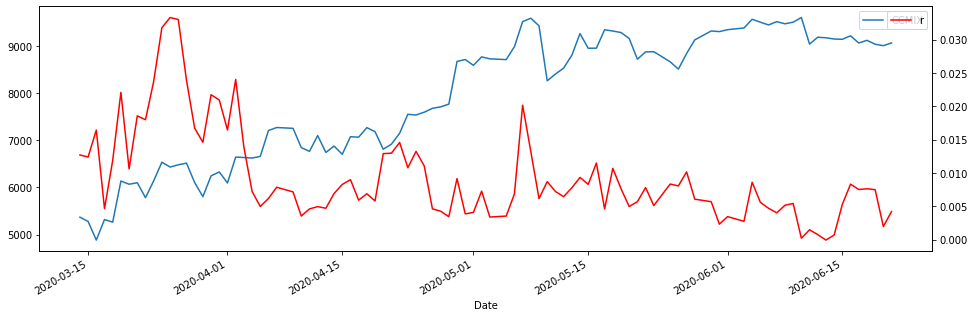

In [1931]:
# How downside market beta coincides with strategy returns?

f, ax = plt.subplots(figsize=(16, 5))

ax2 = ax.twinx()
dates = pd.DataFrame(simulations['LTCM20'])[['date_start', 'r']].set_index('date_start').index
ccmix_index['CCMIX'].loc[dates].plot(ax=ax, legend='return')
pd.DataFrame(simulations['LTCM20'])[['date_start', 'r']].set_index('date_start').plot(ax=ax2, color='r', legend='return')

ax.legend();

### Performance stats 

In [784]:
all_results = []
for symbol in tqdm(all_batches.keys()):
    try:
        dates = pd.DataFrame(simulations[symbol])['date_start']
        risk_free_ = risk_free.loc[dates]['risk_free']
        strat_return = pd.DataFrame(simulations[symbol])['r'].values
        results = PerformanceStats(
            symbol=symbol,
            risk_free=risk_free_,
            returns=strat_return
        ) 
        all_results.append(results)
    except Exception as e:
        print(symbol, e)


  0%|          | 0/96 [00:00<?, ?it/s]

In [811]:
res = pd.DataFrame(all_results)
res = res[~res['symbol'].isin(['XBCZ16', 'XBCH17', 'XBCM17'])]

In [815]:
res.groupby('year').mean()

sharpe  winning_trades    net_profit  average_return_per_trade  \
year                                                                     
16    0.716646        1.000000  4.744349e+06                  0.727983   
17    1.464044        1.000000  2.162021e+07                  0.164906   
18    0.214490        0.991896  1.515977e+07                  0.042548   
19   -1.301538        0.991283  8.039672e+05                  0.013924   
20    0.967281        0.988618  1.118509e+06                  0.010843   
21    1.467089        0.995181  1.581533e+07                  0.037007   

      average_profit_per_trade  average_return_per_day  
year                                                    
16                81799.126695                0.079172  
17               576849.805093                0.091361  
18               284194.694959                0.016783  
19                 8723.879898                0.002582  
20                12161.705356                0.002882  
21               193915.408192                0.002982

    1. Проверить биржу другую
    2. Сравнить доходность с другими факторами
    3. SR, beta, dd, downside risk beta, skew, kurtosis
    4. Доделать шорт
    5. Смотреть на короткие периоды падения, как отыгрывала
    6. SMB, разные спецификации
    7. Объединение нескольких портфелей по керри
    8. Риски между рынков

### Выбор конфигурации стратегии

Для начала определимся с тем, как будем реализовывать стратегию. Мы знаем, что наша стратегия состоит из следующих шагов:
    
    1. Выбор фактора, по которому будем осуществлять сортировку
    2. Выбор длительности периода, за который мы будем отслеживать изменение фактора (день, неделя, месяц) и функция аггрегации (среднее, минимальное, максимальное)
    3. Количество `k` лидеров на покупку и лузеров на продажу
    
Попробуем следующую конфигурацию:

    1. Керри-фактор для фьючерсов с биржи хуоби
    2. 1 неделя
    3. 25%

In [817]:
# Для каждого дня, из наших позиций:

    # Достаем керри фактор для всех бумаг из конкретной биржи
    # Сортируем показатели и покупаем 50%

### 1 week

In [1356]:
next(iter(res.iterrows()))

(0,
 symbol                             ETH
 date_entry         2018-12-16 00:00:00
 price_entry                  83.833582
 carry_entry                  -0.056385
 price_exit                  108.778177
 date_exit          2019-02-03 00:00:00
 cost_of_capital                0.00011
 profit                       24.360471
 returns                       0.290581
 rf                              0.0237
 Name: 0, dtype: object)

In [1932]:
@dataclass 
class Portfel:
    holdings: pd.DataFrame
    sharpe: None = None
    multiplier: None = None
    winning_rate: None = None
    avg_return: float = None
    avg_return_per_day: float = None
        
    def __post_init__(self):
        self.sharpe = (self.holdings['returns'] - self.holdings['rf']).mean() / (self.holdings['returns'] - self.holdings['rf']).std()
        self.multiplier = (1 + self.holdings['returns'].reset_index().groupby('index').mean()).prod().iloc[0]
        self.winning_rate = (self.holdings['returns'] > 0).mean()
        
        for _, deal in self.holdings.iterrows():
            days = (deal.date_exit - deal.date_entry).days
            self.avg_return_per_day = deal.returns / days
            
        
@dataclass
class Order:
    symbol: str
    date_entry:  str
    price_entry: str
    carry_entry: str
    price_exit:  str = None
    date_exit:   str = None
    cost_of_capital: float = 0.04 / 365
    profit: str = None
    returns: float = None 
    rf: float = None

        
    def __post_init__(self):
        self.price_exit = spot_data.loc[self.date_entry:].head(2)[self.symbol].iloc[-1]
        self.date_exit = spot_data.loc[self.date_entry:].head(2).iloc[-1].name
        self.profit = self.price_exit - self.price_entry - self.cost_of_capital * self.price_exit * (self.date_exit - self.date_entry).days
        self.returns = self.profit / self.price_entry    
        self.rf = risk_free.loc[self.date_entry].iloc[0]
                                                                                                     
                                                                                                     

2019-08-18 00:00:00
coin
ADA          NaN
BCH     0.056516
BSV     0.077554
BTC     0.048552
DOT          NaN
EOS     0.049149
ETC          NaN
ETH     0.084711
FIL          NaN
LINK         NaN
LTC     0.060485
Name: 2019-08-18 00:00:00, dtype: float64
2019-08-25 00:00:00
coin
ADA          NaN
BCH     0.012888
BSV     0.010950
BTC     0.019616
DOT          NaN
EOS    -0.014671
ETC          NaN
ETH    -0.008280
FIL          NaN
LINK         NaN
LTC     0.007277
Name: 2019-08-25 00:00:00, dtype: float64
2019-09-01 00:00:00
coin
ADA          NaN
BCH     0.023876
BSV     0.022372
BTC     0.029399
DOT          NaN
EOS    -0.015064
ETC          NaN
ETH     0.003644
FIL          NaN
LINK         NaN
LTC     0.022921
Name: 2019-09-01 00:00:00, dtype: float64
2019-09-08 00:00:00
coin
ADA          NaN
BCH     0.017494
BSV    -0.016010
BTC    -0.009316
DOT          NaN
EOS     0.085518
ETC          NaN
ETH     0.024011
FIL          NaN
LINK         NaN
LTC     0.015598
Name: 2019-09-08 00:00:00,

2020-11-15 00:00:00
coin
ADA     0.004527
BCH    -0.017865
BSV     0.014377
BTC     0.023885
DOT     0.019871
EOS     0.019960
ETC     0.077175
ETH    -0.005661
FIL          NaN
LINK    0.011481
LTC     0.119620
Name: 2020-11-15 00:00:00, dtype: float64
2020-11-22 00:00:00
coin
ADA     0.129779
BCH    -0.023758
BSV    -0.042100
BTC    -0.018760
DOT    -0.002073
EOS    -0.009659
ETC    -0.054647
ETH     0.079303
FIL          NaN
LINK   -0.036426
LTC    -0.006129
Name: 2020-11-22 00:00:00, dtype: float64
2020-11-29 00:00:00
coin
ADA     0.017626
BCH     0.081134
BSV     0.059815
BTC     0.095552
DOT     0.069575
EOS     0.057430
ETC     0.042161
ETH     0.115557
FIL          NaN
LINK    0.069858
LTC     0.163647
Name: 2020-11-29 00:00:00, dtype: float64
2020-12-06 00:00:00
coin
ADA    -0.022921
BCH    -0.005602
BSV     0.018210
BTC     0.006606
DOT    -0.015718
EOS    -0.001457
ETC     0.003986
ETH    -0.000278
FIL          NaN
LINK    0.006240
LTC     0.021322
Name: 2020-12-06 00:00:00,

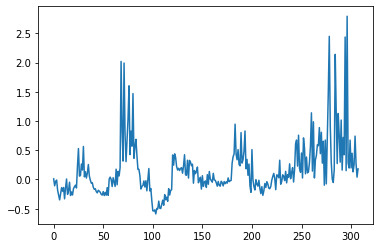

In [2063]:
def simulate_trades(F_TYPE, REBALANCE, FEE, K):

    carry_data = pivot(futures_huobi[futures_huobi['length'] == F_TYPE]).resample(REBALANCE).last()['ar_carry']
    spot_data = spot.reset_index().pivot_table(index=['index'], columns=['coin'])['price'].reindex(index=carry_data.index, columns=carry_data.columns)


    holdings = []
    for day, week in carry_data.iterrows():
        if len(week.dropna()) < 1.5 * K:
            continue
        print(day)
        print(week)
        coins_to_buy = week.nlargest(K)

        if coins_to_buy.any():
            for coin, carry in coins_to_buy.iteritems():
                holdings.append(
                    Order(
                        symbol=coin,
                        date_entry=day,
                        price_entry=spot_data.loc[day][coin],
                        carry_entry=carry))

    simulations = pd.DataFrame(holdings).dropna()
    return simulations

res = simulate_trades('week', 'w', 0.1, 4).reset_index()
res['returns'].plot()

2019-08-18 00:00:00
coin
ADA          NaN
BCH     0.056516
BSV     0.077554
BTC     0.048552
DOT          NaN
EOS     0.049149
ETC          NaN
ETH     0.084711
FIL          NaN
LINK         NaN
LTC     0.060485
Name: 2019-08-18 00:00:00, dtype: float64
2019-08-25 00:00:00
coin
ADA          NaN
BCH     0.012888
BSV     0.010950
BTC     0.019616
DOT          NaN
EOS    -0.014671
ETC          NaN
ETH    -0.008280
FIL          NaN
LINK         NaN
LTC     0.007277
Name: 2019-08-25 00:00:00, dtype: float64
2019-09-01 00:00:00
coin
ADA          NaN
BCH     0.023876
BSV     0.022372
BTC     0.029399
DOT          NaN
EOS    -0.015064
ETC          NaN
ETH     0.003644
FIL          NaN
LINK         NaN
LTC     0.022921
Name: 2019-09-01 00:00:00, dtype: float64
2019-09-08 00:00:00
coin
ADA          NaN
BCH     0.017494
BSV    -0.016010
BTC    -0.009316
DOT          NaN
EOS     0.085518
ETC          NaN
ETH     0.024011
FIL          NaN
LINK         NaN
LTC     0.015598
Name: 2019-09-08 00:00:00,

2020-04-12 00:00:00
coin
ADA          NaN
BCH    -0.055236
BSV     0.006570
BTC    -0.017563
DOT          NaN
EOS    -0.046248
ETC    -0.031465
ETH    -0.028459
FIL          NaN
LINK         NaN
LTC    -0.049134
Name: 2020-04-12 00:00:00, dtype: float64
2020-04-19 00:00:00
coin
ADA          NaN
BCH    -0.055874
BSV    -0.052763
BTC    -0.023100
DOT          NaN
EOS    -0.028106
ETC    -0.034474
ETH    -0.041858
FIL          NaN
LINK         NaN
LTC    -0.050172
Name: 2020-04-19 00:00:00, dtype: float64
2020-04-26 00:00:00
coin
ADA          NaN
BCH    -0.005801
BSV    -0.005477
BTC     0.017912
DOT          NaN
EOS    -0.000041
ETC     0.042041
ETH    -0.007713
FIL          NaN
LINK         NaN
LTC    -0.016002
Name: 2020-04-26 00:00:00, dtype: float64
2020-05-03 00:00:00
coin
ADA          NaN
BCH    -0.053852
BSV    -0.040732
BTC    -0.011328
DOT          NaN
EOS    -0.054111
ETC    -0.020834
ETH    -0.036655
FIL          NaN
LINK         NaN
LTC    -0.040721
Name: 2020-05-03 00:00:00,

2020-12-20 00:00:00
coin
ADA    -0.072423
BCH     0.014699
BSV    -0.012456
BTC    -0.029079
DOT    -0.077689
EOS    -0.020633
ETC    -0.027164
ETH    -0.066656
FIL    -0.064464
LINK   -0.081003
LTC    -0.108182
Name: 2020-12-20 00:00:00, dtype: float64
2020-12-27 00:00:00
coin
ADA     0.038818
BCH     0.134995
BSV     0.032513
BTC     0.019686
DOT     0.210939
EOS     0.086086
ETC     0.025882
ETH     0.150095
FIL    -0.039620
LINK    0.120654
LTC     0.011709
Name: 2020-12-27 00:00:00, dtype: float64
2021-01-03 00:00:00
coin
ADA     0.210248
BCH     0.143215
BSV     0.028340
BTC    -0.008753
DOT     0.036432
EOS     0.056214
ETC     0.213136
ETH     0.343602
FIL    -0.028053
LINK    0.132905
LTC     0.114738
Name: 2021-01-03 00:00:00, dtype: float64
2021-01-10 00:00:00
coin
ADA    -0.251515
BCH    -0.242635
BSV    -0.387862
BTC    -0.212632
DOT    -0.199573
EOS    -0.311145
ETC    -0.114905
ETH    -0.236958
FIL    -0.052383
LINK   -0.239920
LTC    -0.298453
Name: 2021-01-10 00:00:00,

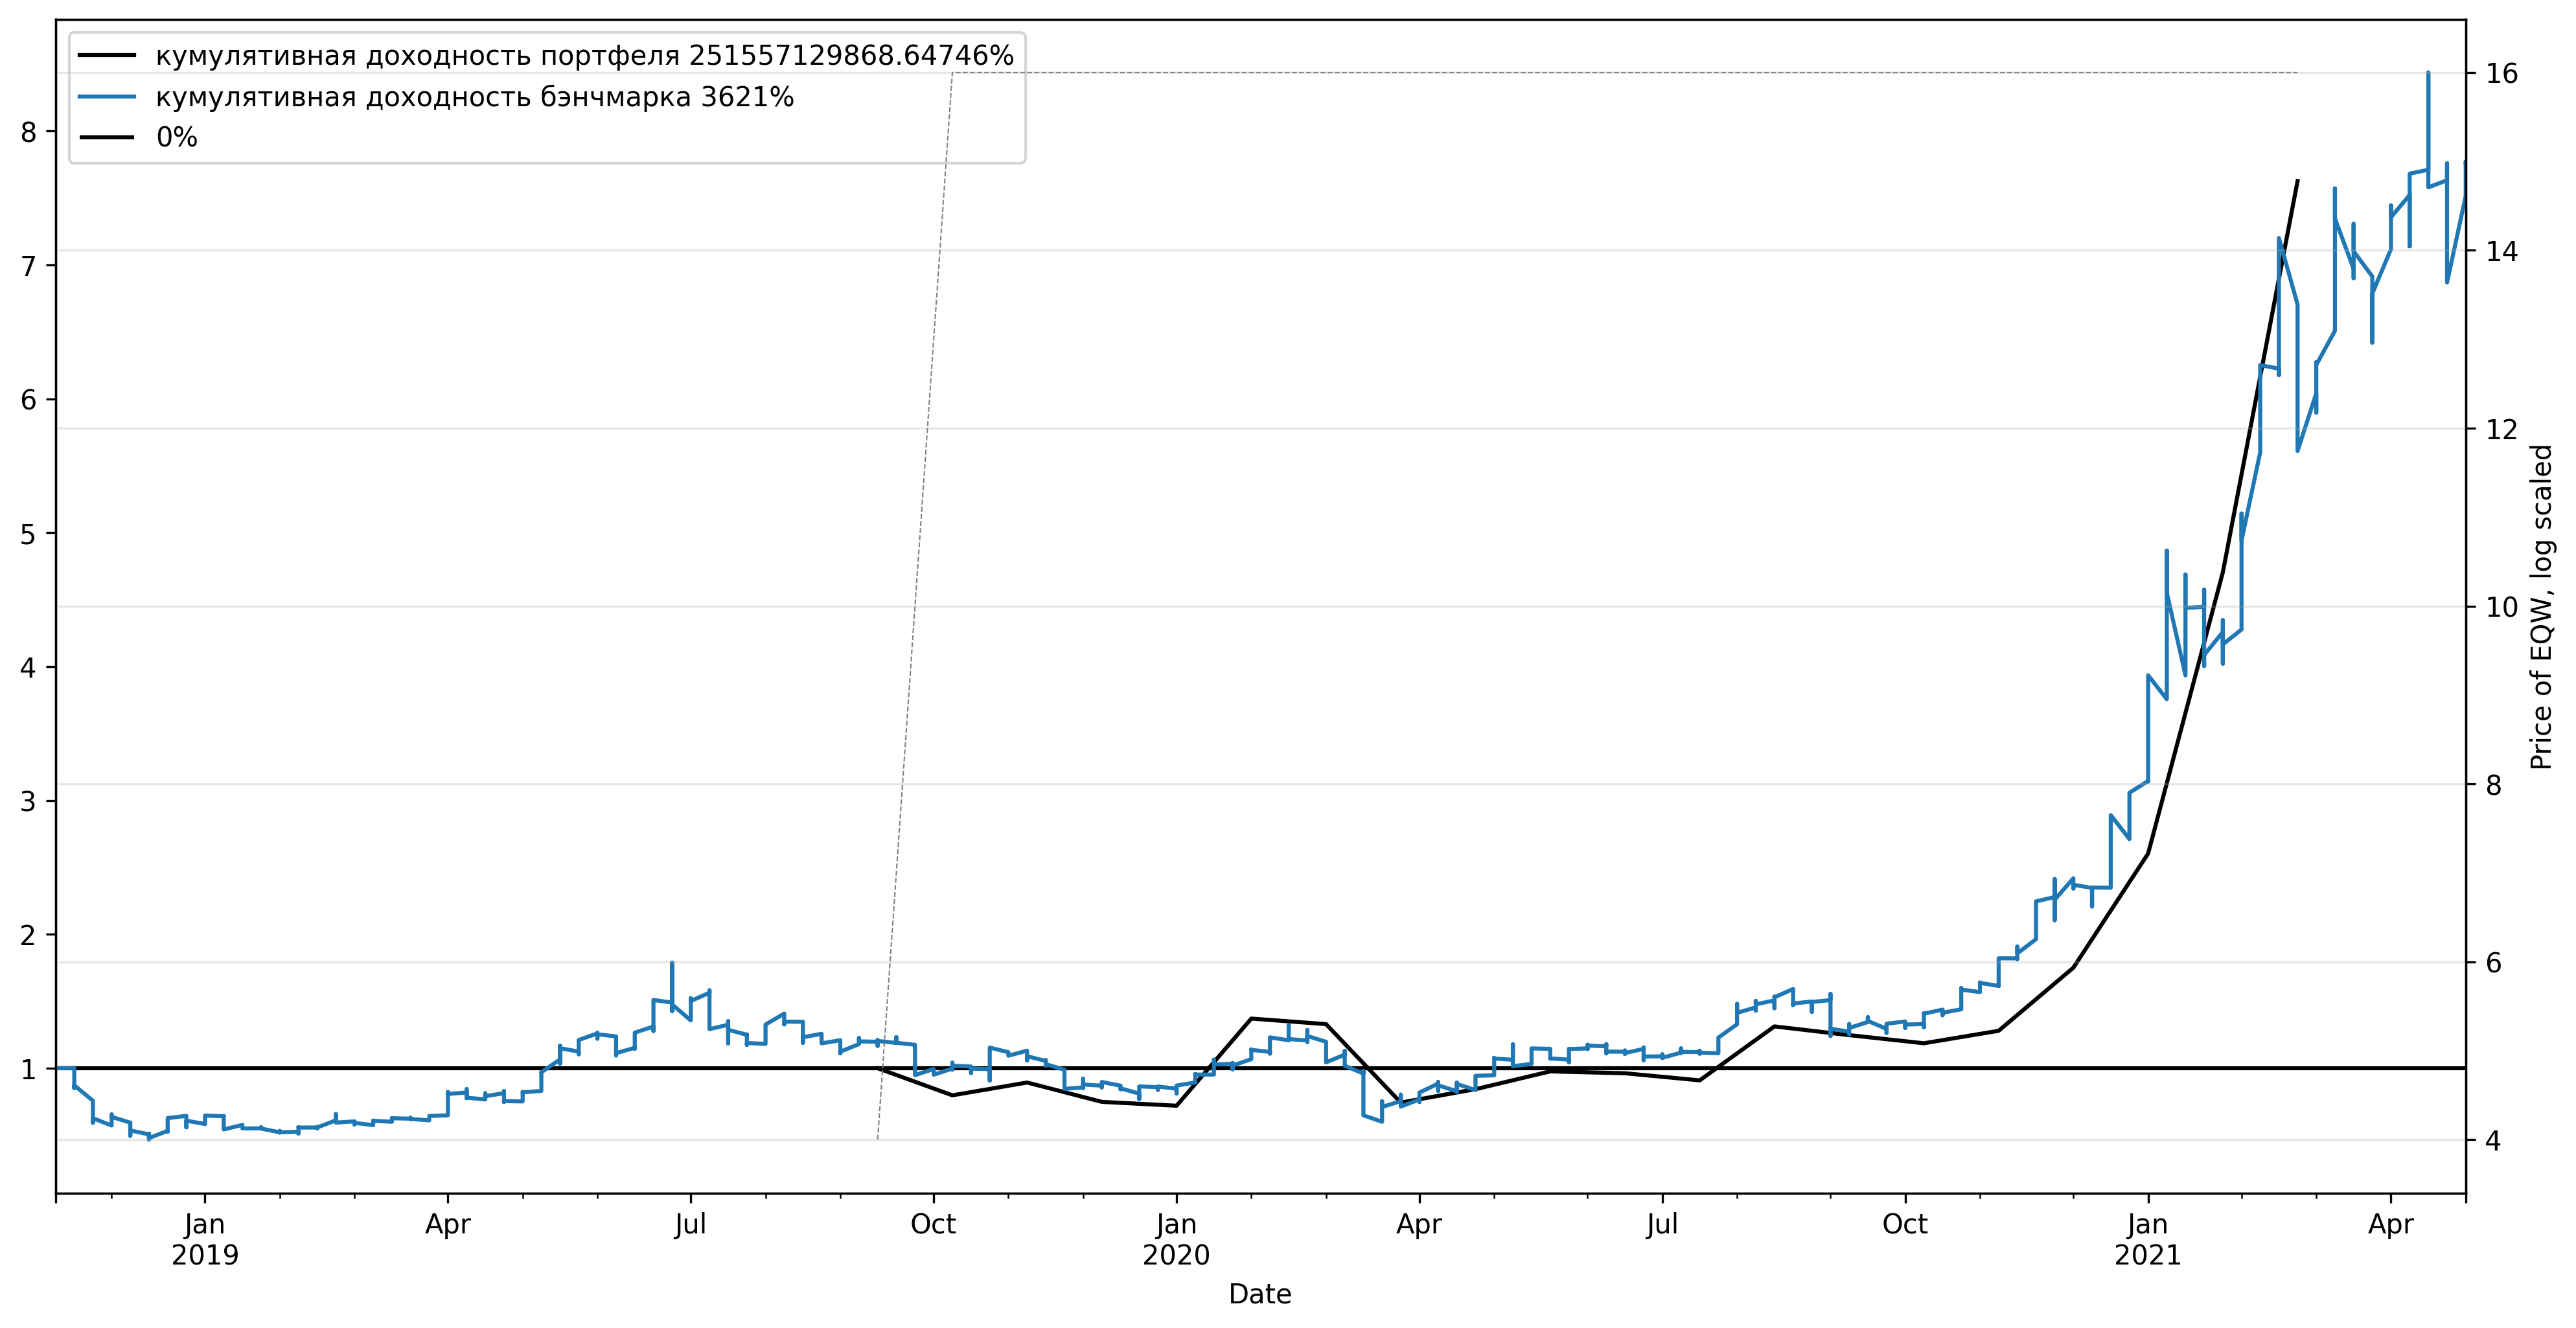

In [2064]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)

res = simulate_trades('week', 'w', 0.1, 4).reset_index()
bench_cum_return = (1 + ccmix_index['return'].loc['2018-11-11':]).cumprod() / (1 + ccmix_index['return'].loc['2018-11-11':]).cumprod().iloc[0]
ax2 = ax.twinx()

res.groupby('date_exit').count()['index'].plot(ax=ax2, lw=0.5, c='grey', ls='dashed')
((1 + res.groupby('date_exit').mean()['returns']).cumprod() / (1 + res.groupby('date_exit').mean()['returns']).cumprod().iloc[0]).plot(ax=ax,
                                                                                                                                         color='black',
                                                                                                                                         label=f'кумулятивная доходность портфеля {(1 + res["returns"]).prod()}%');
bench_cum_return.plot(ax=ax, label=f'кумулятивная доходность бэнчмарка {return_bench}%');
ax.hlines(1, xmin=bench_cum_return.index[0], xmax=bench_cum_return.index[-1], color='black', label='0%')
# ax.set_yscale('log')
ax.legend()
plt.ylabel('Price of EQW, log scaled')
plt.grid(alpha=0.3)

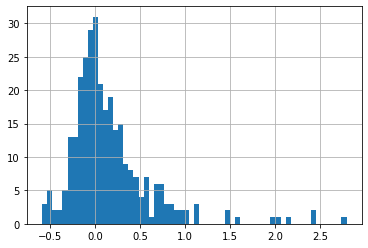

In [2065]:
res['returns'].hist(bins=60)

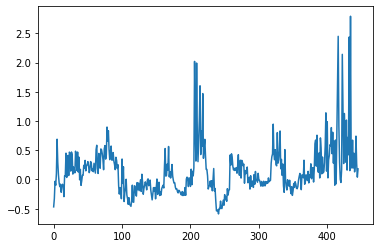

In [2048]:
res['returns'].plot()

In [2050]:
res.groupby('date_entry').apply(lambda x: x.symbol)

date_entry     
2018-11-11  0      BTC
2018-11-18  1      BTC
2018-11-25  2      BTC
2018-12-02  3      BTC
2018-12-09  4      BTC
                  ... 
2021-01-24  441    LTC
2021-01-31  442    FIL
            443    EOS
            444    BSV
            445    BCH
Name: symbol, Length: 446, dtype: object

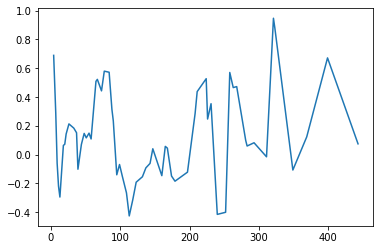

In [2042]:
res[res['symbol'] == 'ETH']['returns'].plot()

In [2030]:
def pivot(df, column='carry'):
    pivoted = df.reset_index().pivot(index='index', columns=['coin'])
    return pivoted


def main(futures, NLARGEST, REBALANCE):
    
    carry         = select_futures(futures, REBALANCE)
    selected_spot = select_spot(carry)
    
    signals       = init_signals(carry, REBALANCE)
    signals       = generate_signals(signals, carry, NLARGEST)
    orders        = generate_orders(signals)
    results       = generate_results(orders, selected_spot)
    
    return {'carry': carry,
            'spot': selected_spot,
            'signals': signals,
            'orders': orders,
            'results': results}
    

def select_futures(futures, REBALANCE):
    return pivot(futures[futures['length'] == '1week']).resample(REBALANCE).mean()


def select_spot(carry, spot=spot):
    return pivot(spot, 'price').reindex(index=carry.index, columns=carry.columns)
    
    
def init_signals(carry, REBALANCE):
    return pd.DataFrame(index=carry.index,
                        columns=carry.columns).resample(REBALANCE).last()


def generate_signals(signals, carry, NLARGEST):
    
    for date, week in signals.iterrows():
        choosen_coins = choose_coins_to_buy(date, carry, NLARGEST)
        week[week.index] = 0
        week[choosen_coins['sell']] = 1


    return signals
    

def choose_coins_to_buy(date, carry, NLARGEST):
    carry_for_a_day = carry.loc[date, :]
    to_buy  = carry_for_a_day.nlargest(NLARGEST).index
    
    n_smallest_series = carry_for_a_day[carry_for_a_day < -0.0015].nsmallest(NLARGEST)
    
    to_sell = [i for i in n_smallest_series.index]
    
    return {'buy': to_buy, 'sell': to_sell}
    

def generate_orders(signals):
    
    orders = signals.diff(1)

    orders.iloc[0, :] = signals.iloc[0, :]
    return orders


def generate_results(orders, selected_spot):
    return -1 * orders * selected_spot



In [2031]:
NLARGEST = 1
REBALANCE = '1w'
result = main(futures_huobi, NLARGEST, REBALANCE)

everyday_portfolio_value  = (result['signals'].resample('1d').last().fillna(method='ffill') * pivot(spot, 'price').pct_change()).dropna(axis=1, how='all').dropna(axis=0, how='all')
# everyday_portfolio_value.pct_change().mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8), dpi=300)
bench_cum_return = (1 + pivot(spot, 'price').iloc[-841:].pct_change().mean(axis=1)).cumprod()

return_portfel = round((1 + everyday_portfolio_value.mean(axis=1)).cumprod().iloc[-1] * 100)
return_bench   = round(bench_cum_return.iloc[-1] * 100)

plt.plot((1 + everyday_portfolio_value.mean(axis=1)).cumprod(), label=f'кумулятивная доходность портфеля {return_portfel}%');
plt.plot(bench_cum_return, label=f'кумулятивная доходность бэнчмарка {return_bench}%');
plt.hlines(1, xmin=everyday_portfolio_value.index[0], xmax=everyday_portfolio_value.index[-1], color='black', label='0%')
plt.yscale('log')
plt.legend()
plt.ylabel('Price of EQW, log scaled')
plt.grid(alpha=0.3)

IndexError: single positional indexer is out-of-bounds

### Влияние количества лидеров на перфоманс

Стратегия керри предполагает выбор определенных гиперпараметров, среди которых - количество лидеров и лузеров, по результатам сортировки по фактору керри.

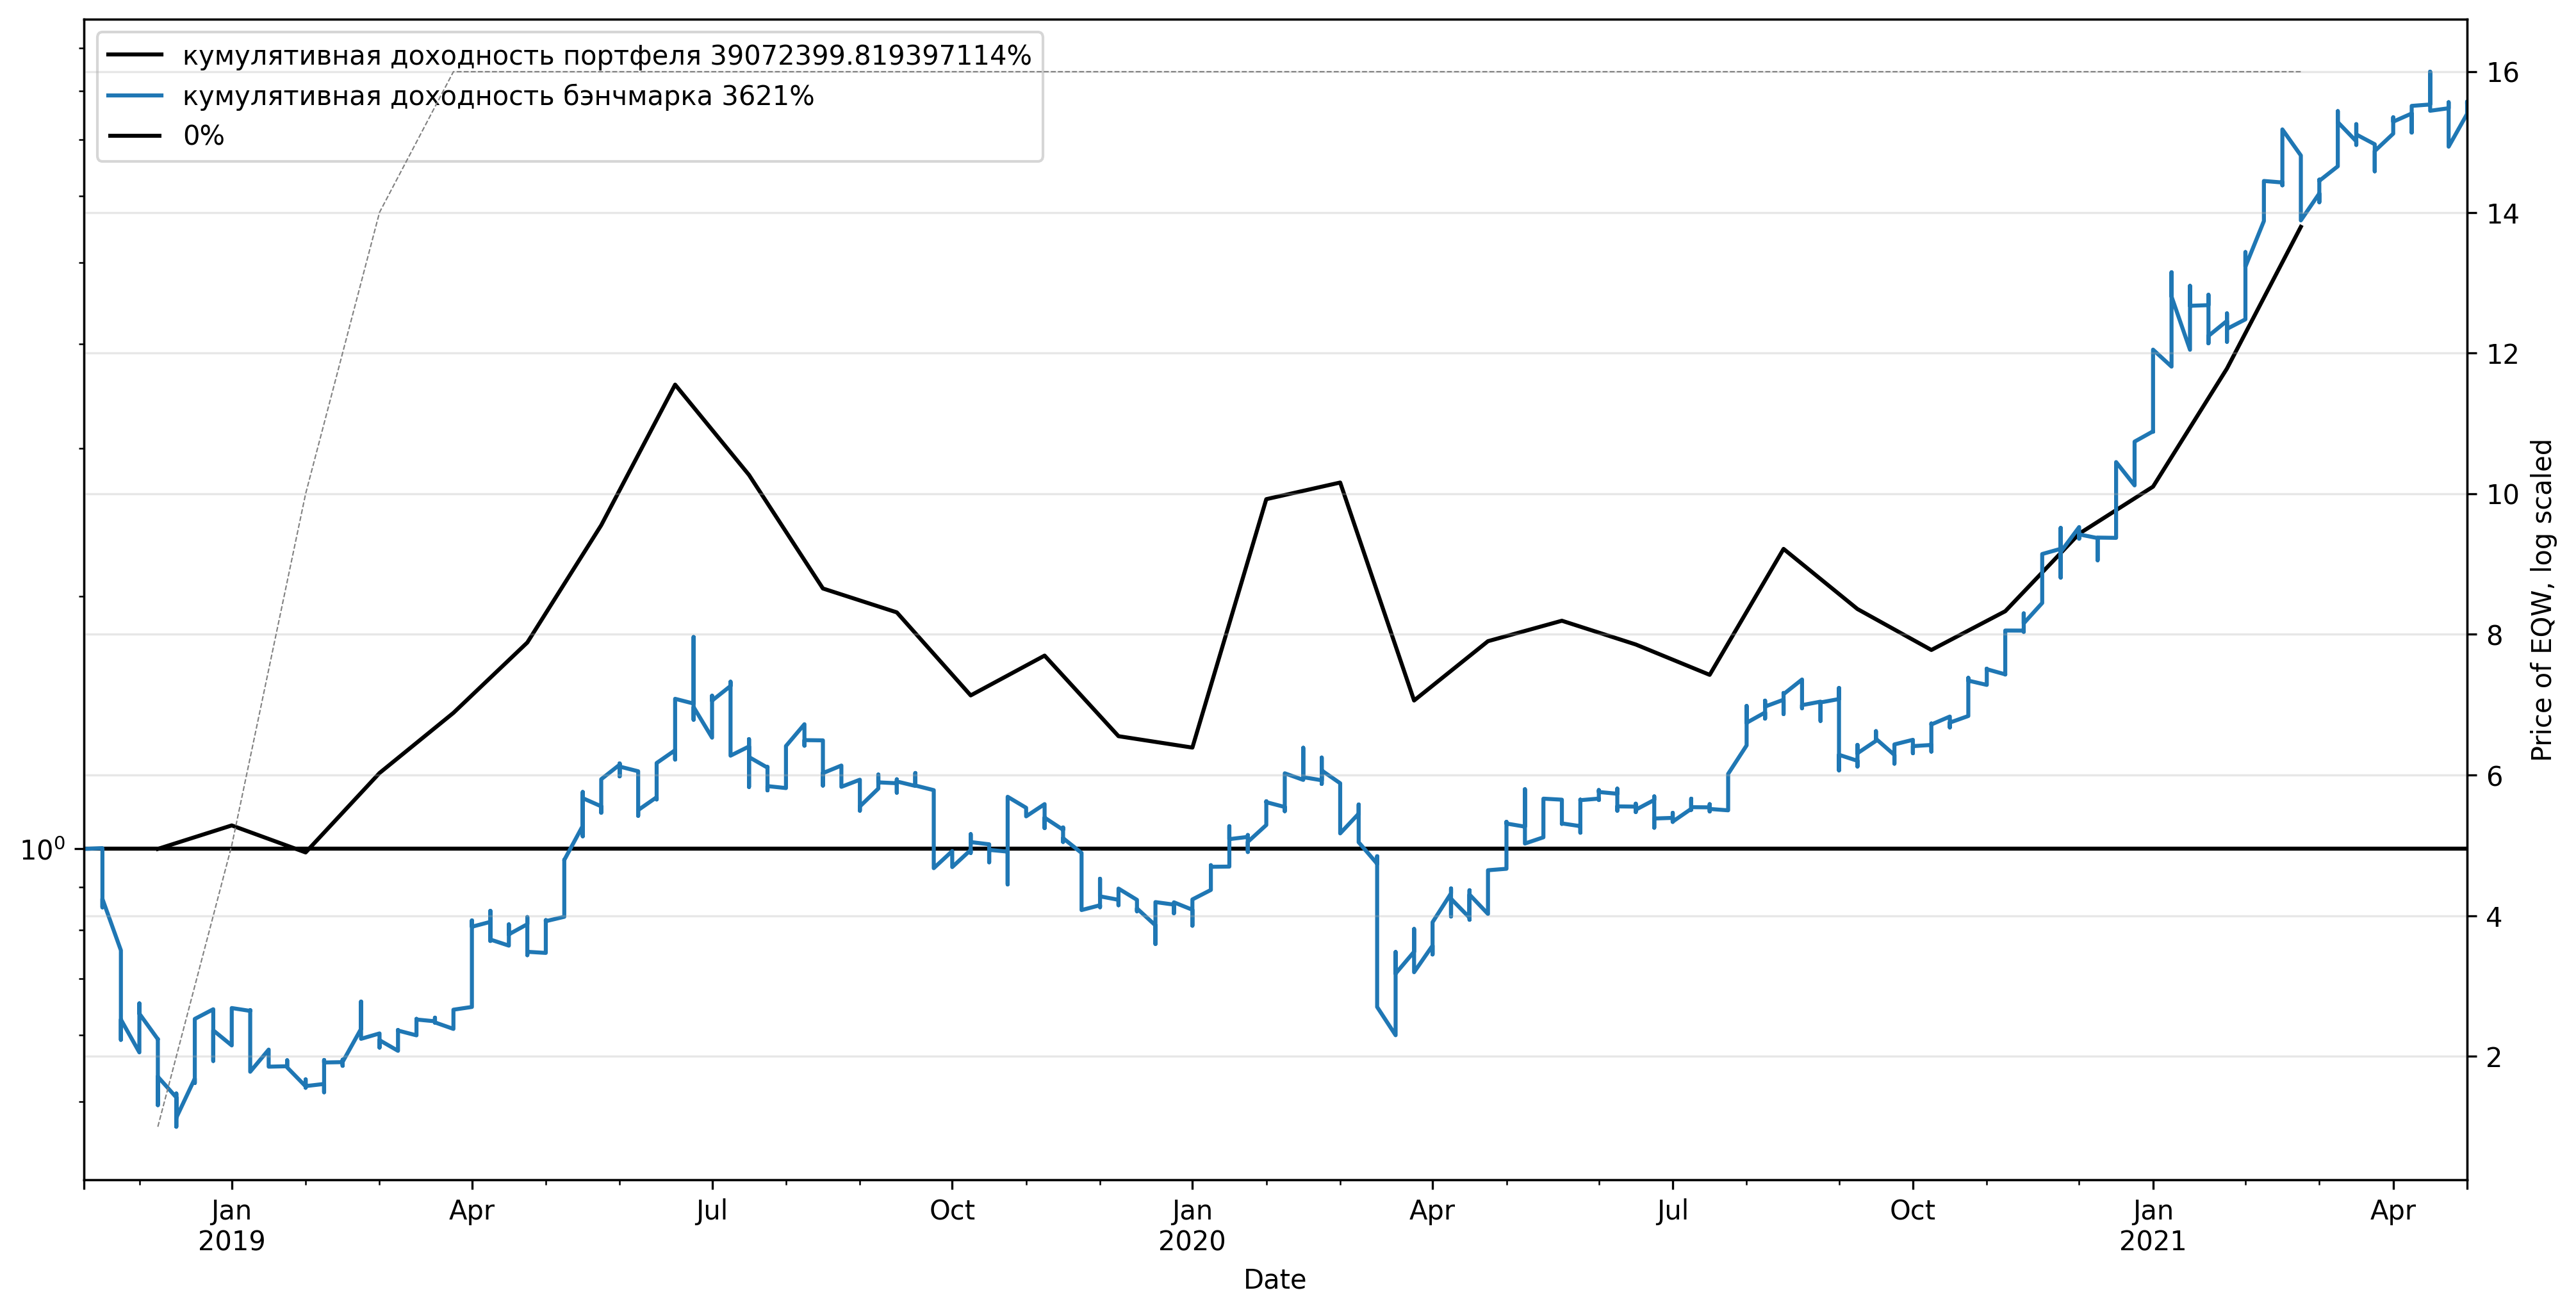

In [2033]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)

res = simulate_trades('week', 'w', 0.1, 4).reset_index()
bench_cum_return = (1 + ccmix_index['return'].loc['2018-11-11':]).cumprod() / (1 + ccmix_index['return'].loc['2018-11-11':]).cumprod().iloc[0]
ax2 = ax.twinx()

res.groupby('date_exit').count()['index'].plot(ax=ax2, lw=0.5, c='grey', ls='dashed')
((1 + res.groupby('date_exit').mean()['returns']).cumprod() / (1 + res.groupby('date_exit').mean()['returns']).cumprod().iloc[0]).plot(ax=ax,
                                                                                                                                         color='black',
                                                                                                                                         label=f'кумулятивная доходность портфеля {(1 + res["returns"]).prod()}%');
bench_cum_return.plot(ax=ax, label=f'кумулятивная доходность бэнчмарка {return_bench}%');
ax.hlines(1, xmin=bench_cum_return.index[0], xmax=bench_cum_return.index[-1], color='black', label='0%')
ax.set_yscale('log')
ax.legend()
plt.ylabel('Price of EQW, log scaled')
plt.grid(alpha=0.3)

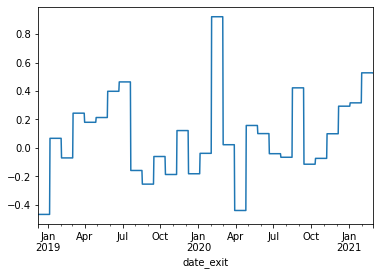

In [2037]:
res.groupby('date_exit').mean()['returns'].resample('1d').last().fillna(method='ffill').plot()

In [2035]:
results_list = []

for i in range(1, 11):
    K = i
    res = simulate_trades('week', 'w', 0.01, K).reset_index()

    results_list.append(
            (1 + res.groupby('date_exit').mean()['returns'].resample('1d').last().fillna(method='ffill')).cumprod()
    )

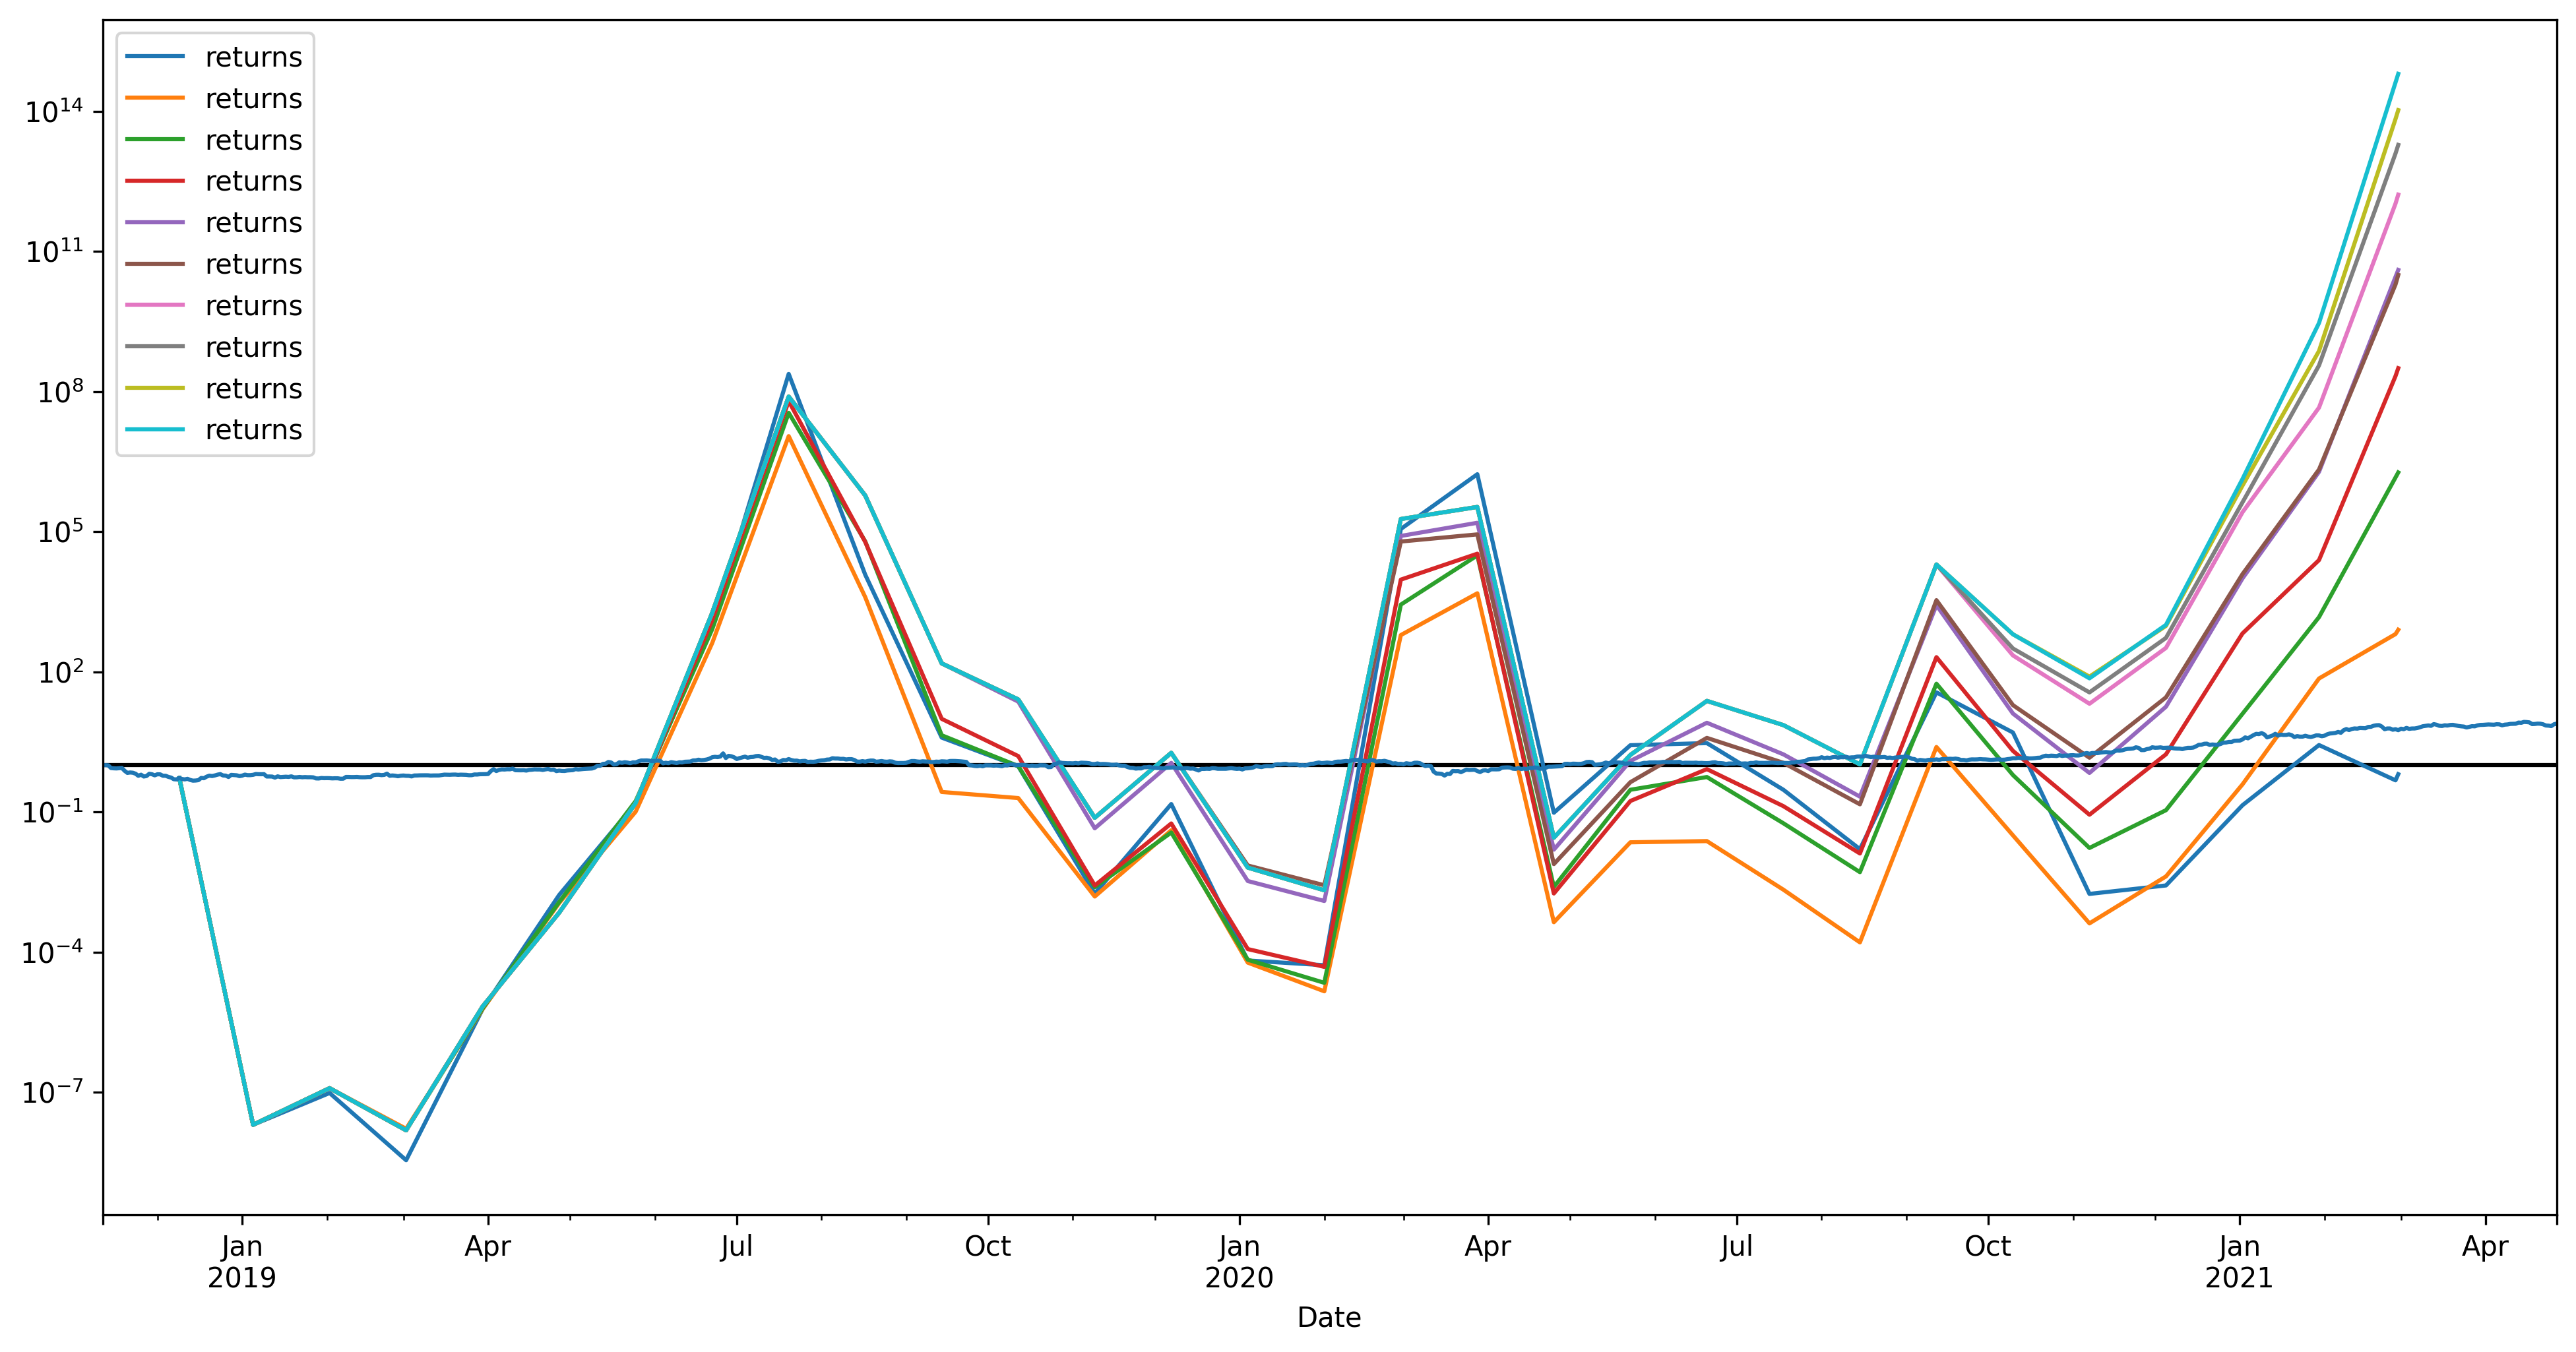

In [2036]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)
ax.set_yscale('log')
pd.DataFrame(results_list).T.plot(ax=ax)
plt.grid(alpha=0.4)
bench_cum_return.plot(ax=ax, label=f'кумулятивная доходность бэнчмарка {return_bench}%');
ax.hlines(1, xmin=bench_cum_return.index[0], xmax=bench_cum_return.index[-1], color='black', label='0%')

In [1583]:
list_of_results = []
REBALANCE = '1m'
for i in range(1, 4):
    NLARGEST = i
    res = simulate_trades('week', f'{i}w', 0.01, 4).reset_index()

    results_list.append(
            (1 + res.groupby('date_exit').mean()['returns'].resample('1d').last().fillna(method='ffill')).cumprod()
    )

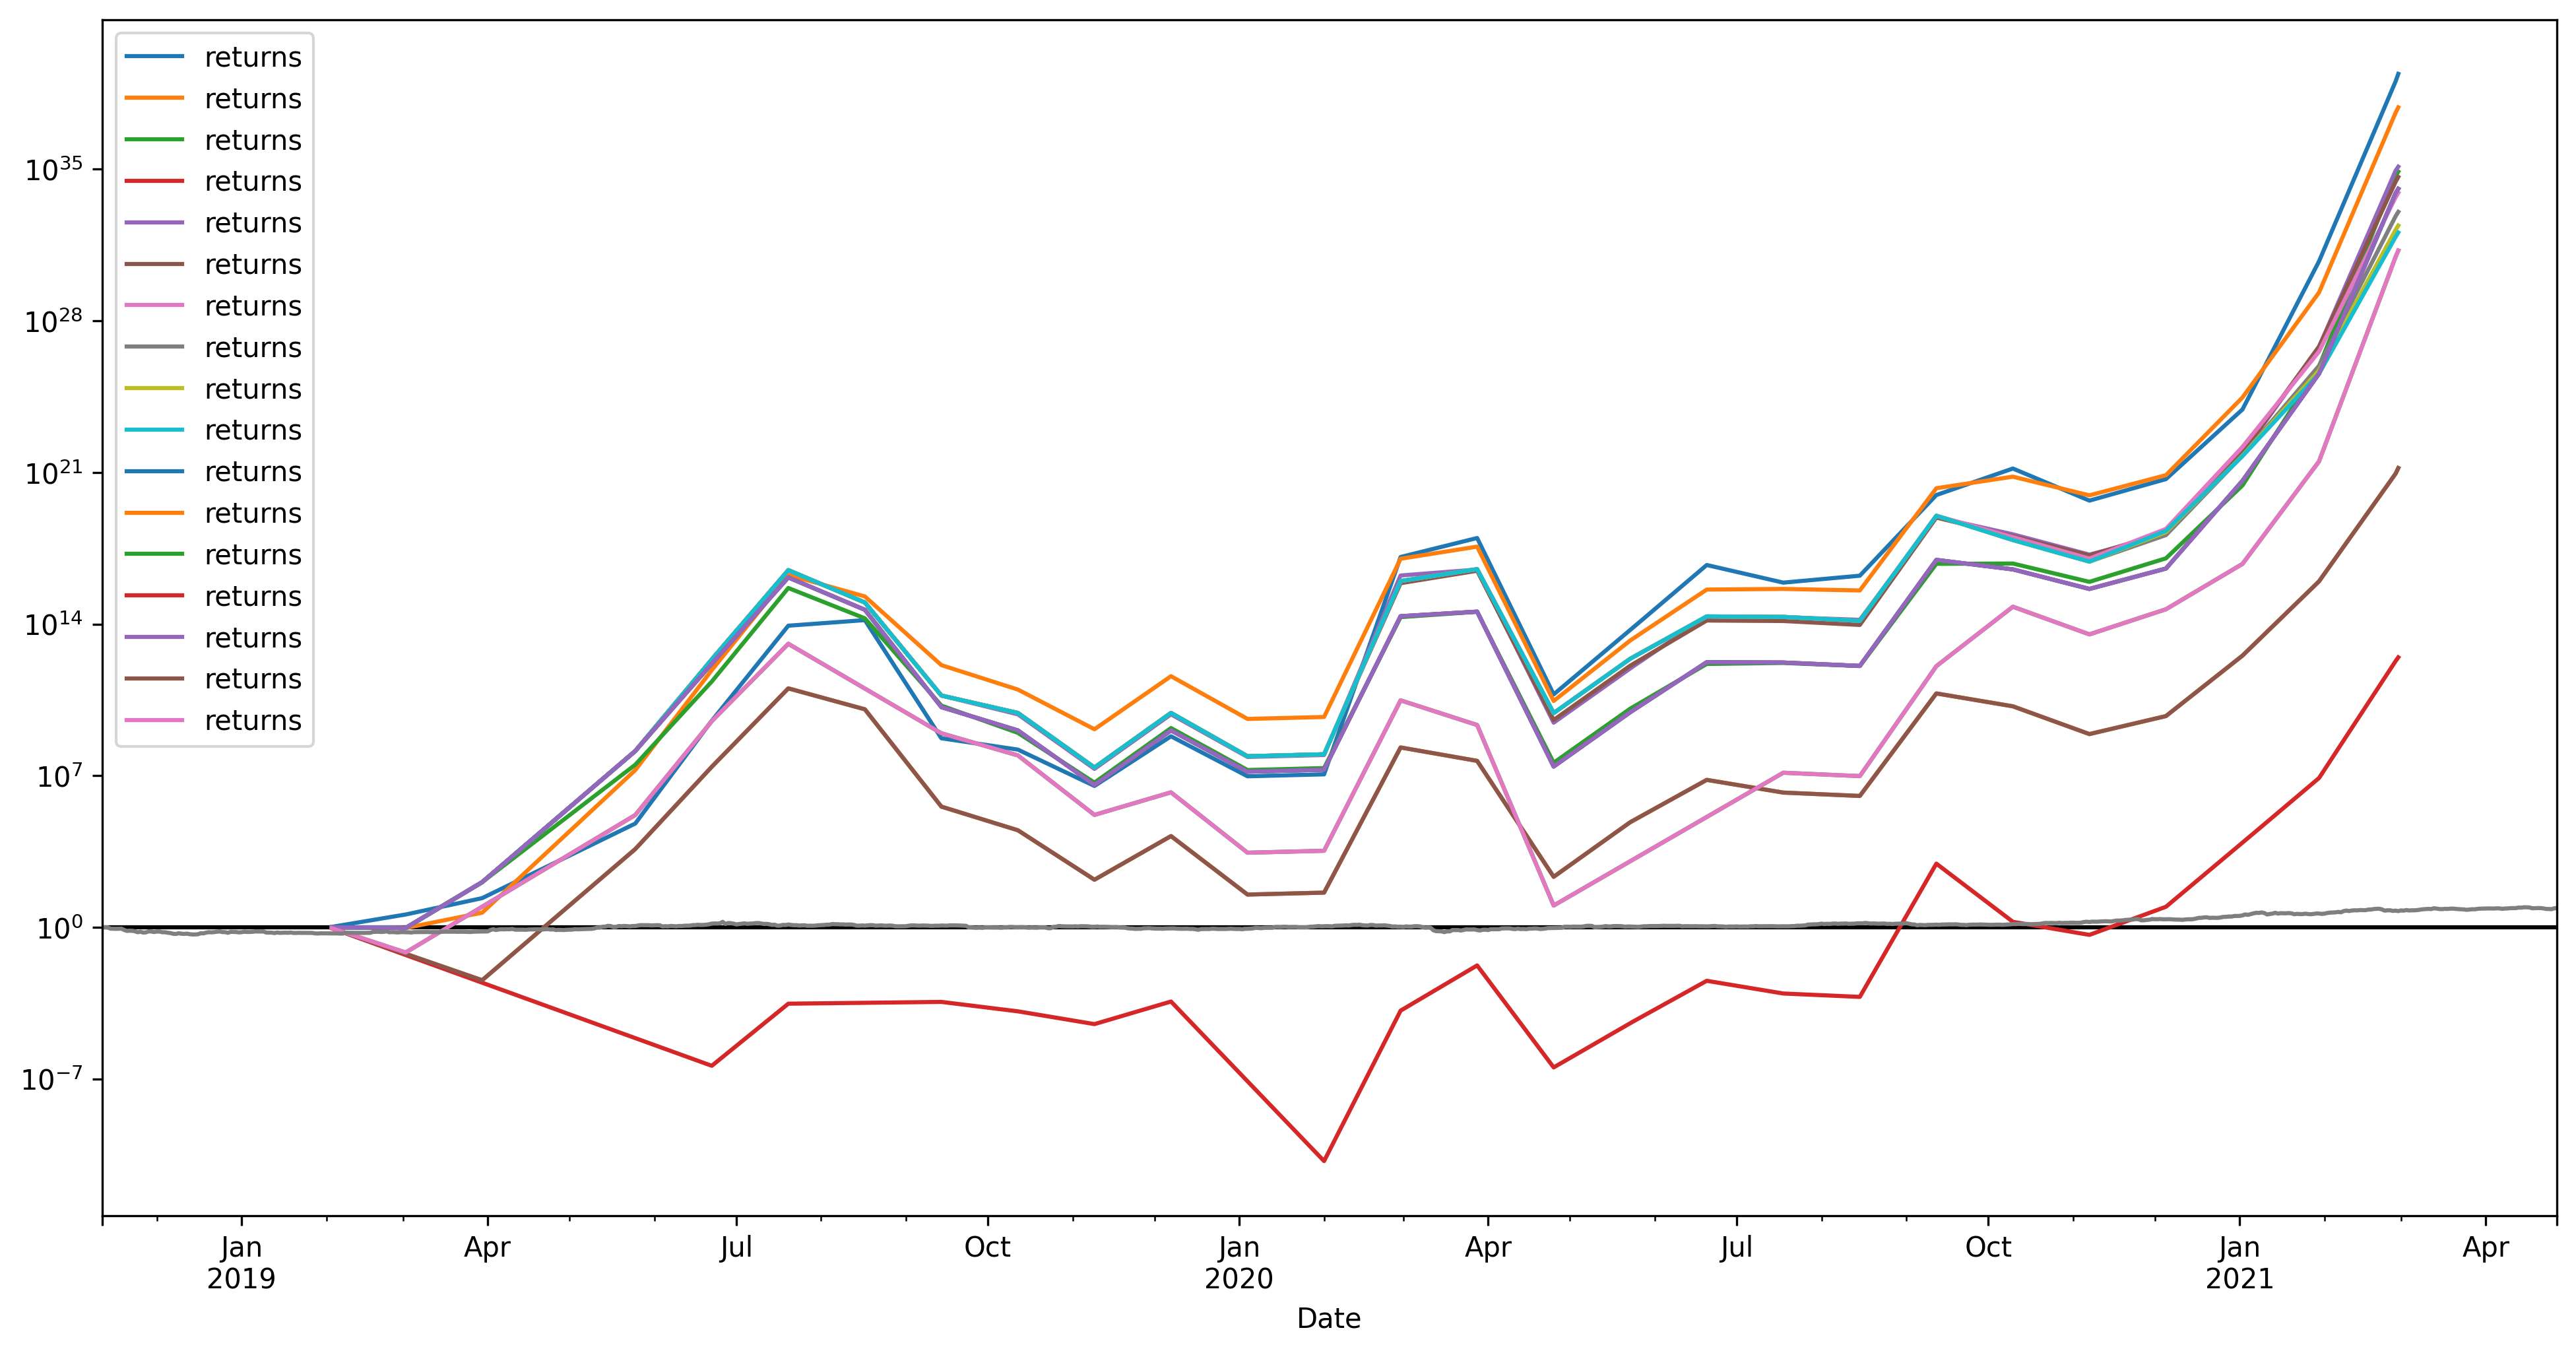

In [1590]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)
ax.set_yscale('log')
pd.DataFrame(results_list).T.plot(ax=ax)
bench_cum_return.plot(ax=ax, label=f'кумулятивная доходность бэнчмарка {return_bench}%');
ax.hlines(1, xmin=bench_cum_return.index[0], xmax=bench_cum_return.index[-1], color='black', label='0%')
# plt.grid(alpha=0.4)

In [2017]:
list_of_results = []
REBALANCE = '1m'

for i in range(1, 11):
    NLARGEST = i
    result_ = main(futures_huobi, NLARGEST, REBALANCE)
    mean_return = (result_['signals'].resample('1d').last().fillna(method='ffill') * pivot(spot, 'price').pct_change()).dropna(axis=1, how='all').dropna(axis=0, how='all').mean(axis=1)
    list_of_results.append({i: mean_return})    
    
all_data = pd.DataFrame(list_of_results[0])

(1 + pd.concat([pd.DataFrame(i) for i in list_of_results], join='outer', axis=1)).cumprod().plot(figsize=(16, 8))
plt.title('Top k leaders performance')
plt.grid(alpha=0.3)

TypeError: generate_orders() missing 2 required positional arguments: 'thresh_buy' and 'thresh_sell'

Что будет если менять длительность ребалансировки

IndexError: single positional indexer is out-of-bounds

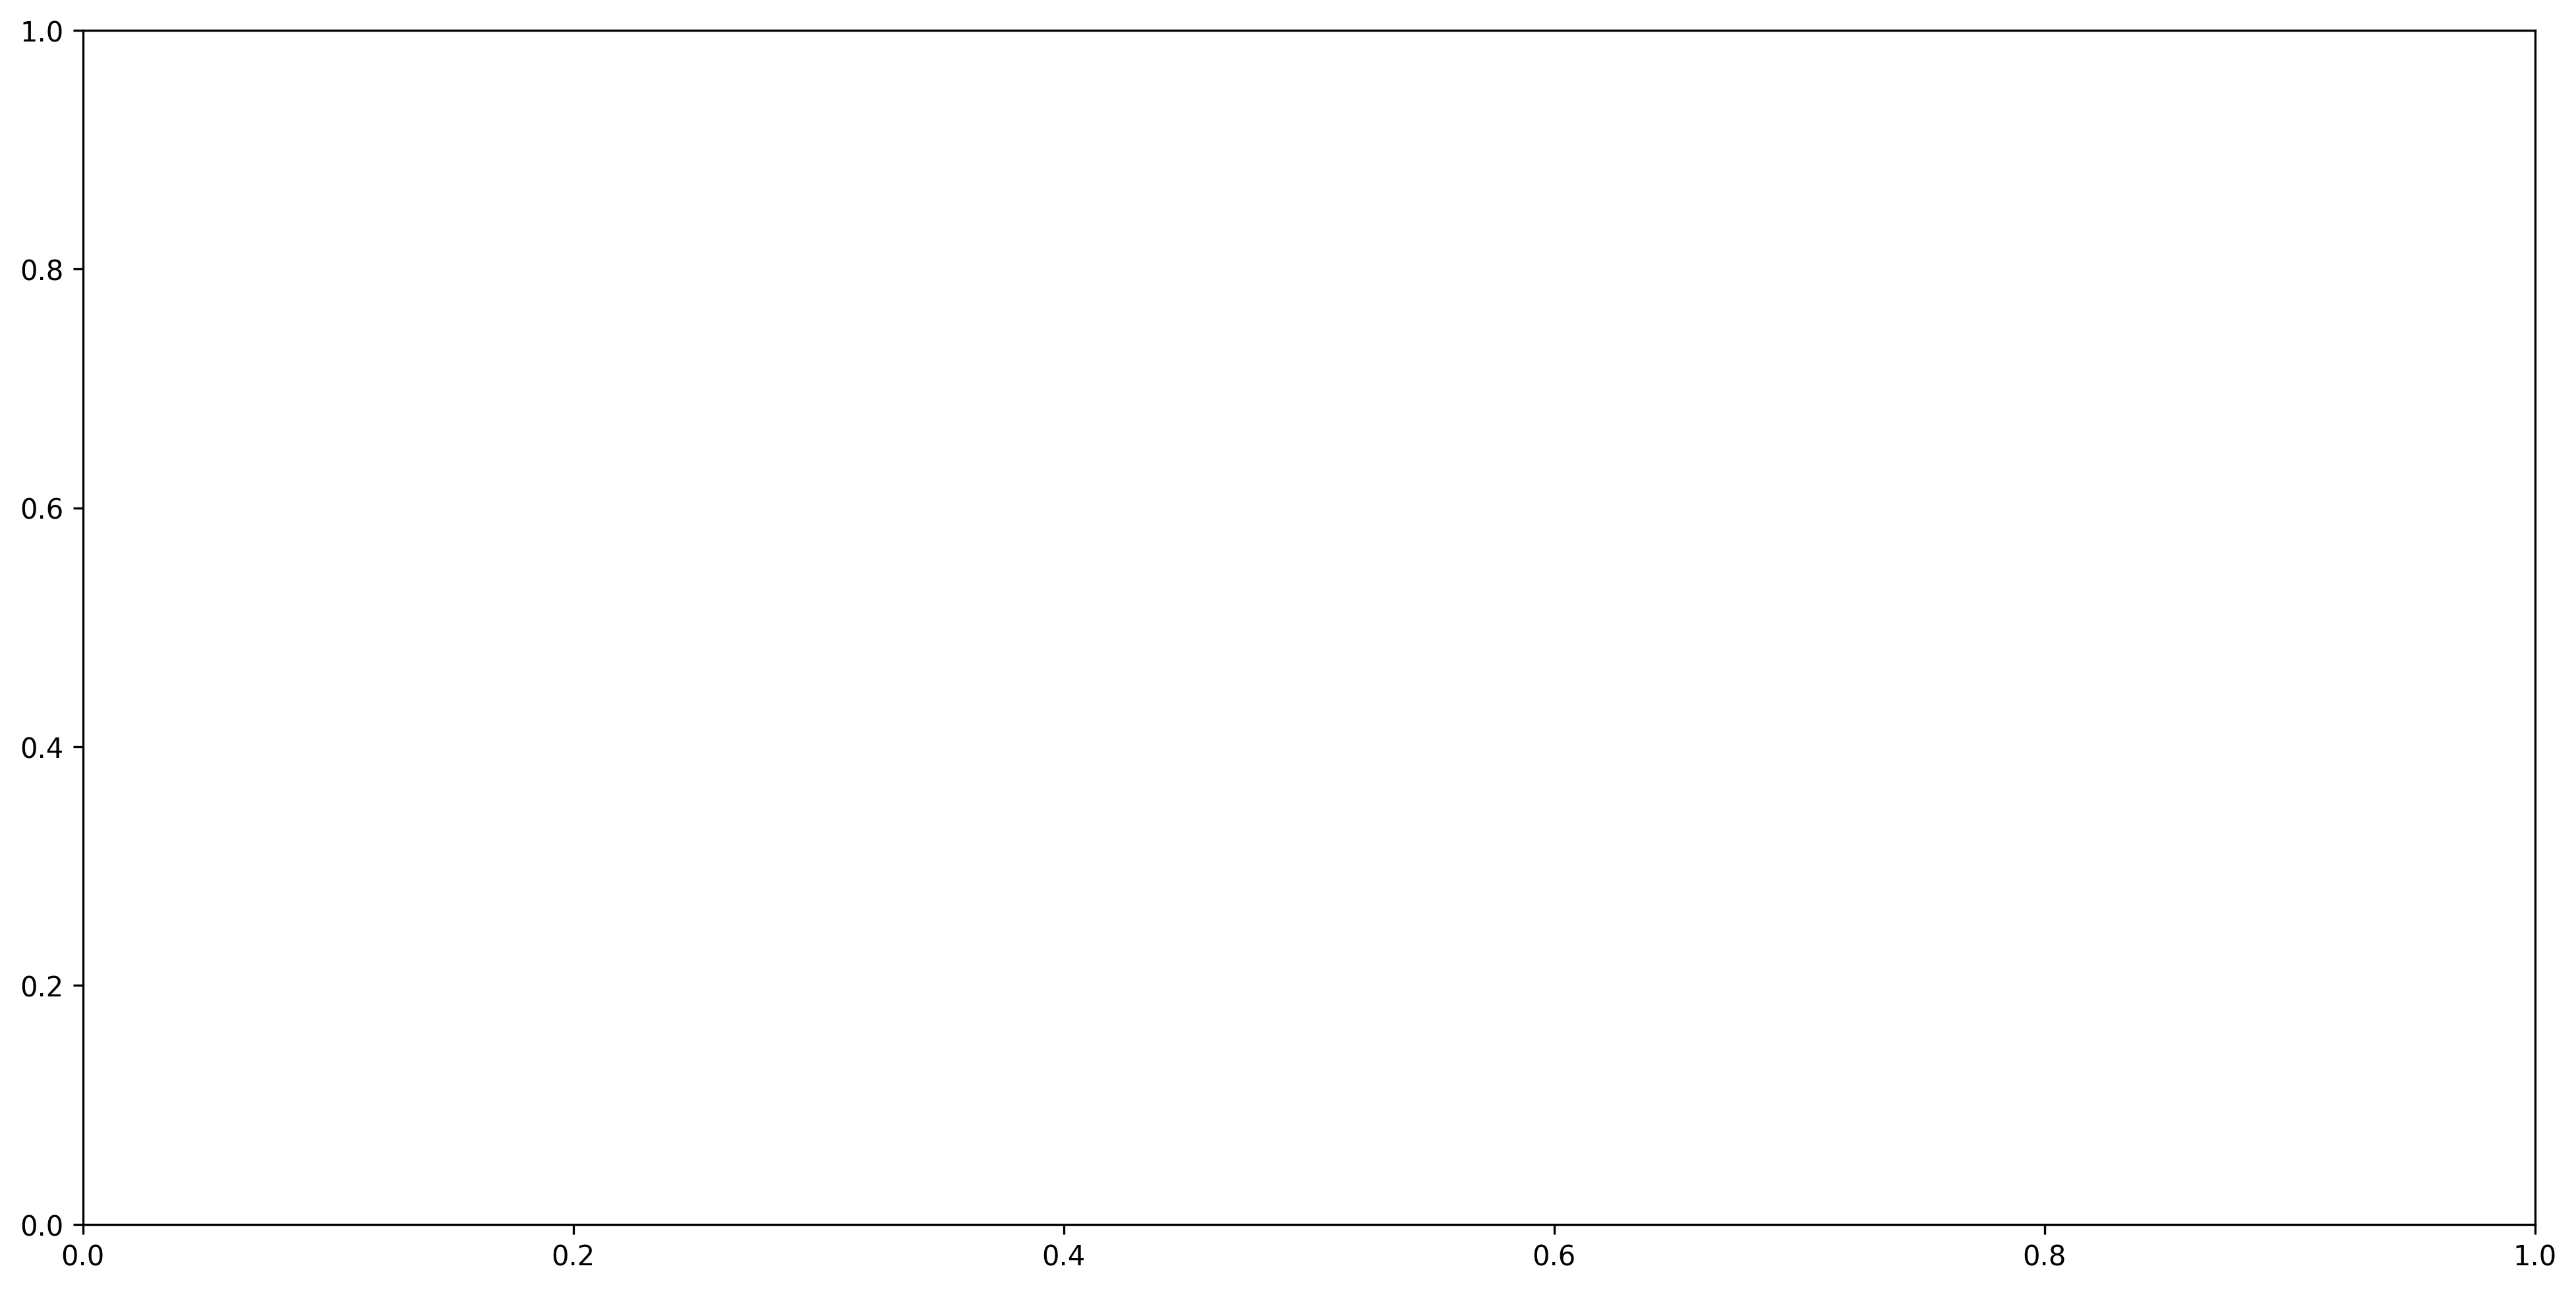

In [2032]:
list_of_results = []

f, ax = plt.subplots(figsize=(16, 8), dpi=300)

NLARGEST = 3
REBALANCE = '1m'
for i in range(1, 10):
    REBALANCE = f'{i}w'
    result_ = main(futures_huobi, NLARGEST, REBALANCE)
    mean_return = (result_['signals'].resample('1d').last().fillna(method='ffill') * pivot(spot, 'price').pct_change()).dropna(axis=1, how='all').dropna(axis=0, how='all').mean(axis=1)
    list_of_results.append({i: mean_return})  
    

all_data = pd.concat([pd.DataFrame(i) for i in list_of_results], join='outer', axis=1)

(1 + all_data).cumprod().plot(ax=ax)
plt.title('Rebalancing portfel each k weeks')
plt.grid(alpha=0.3)

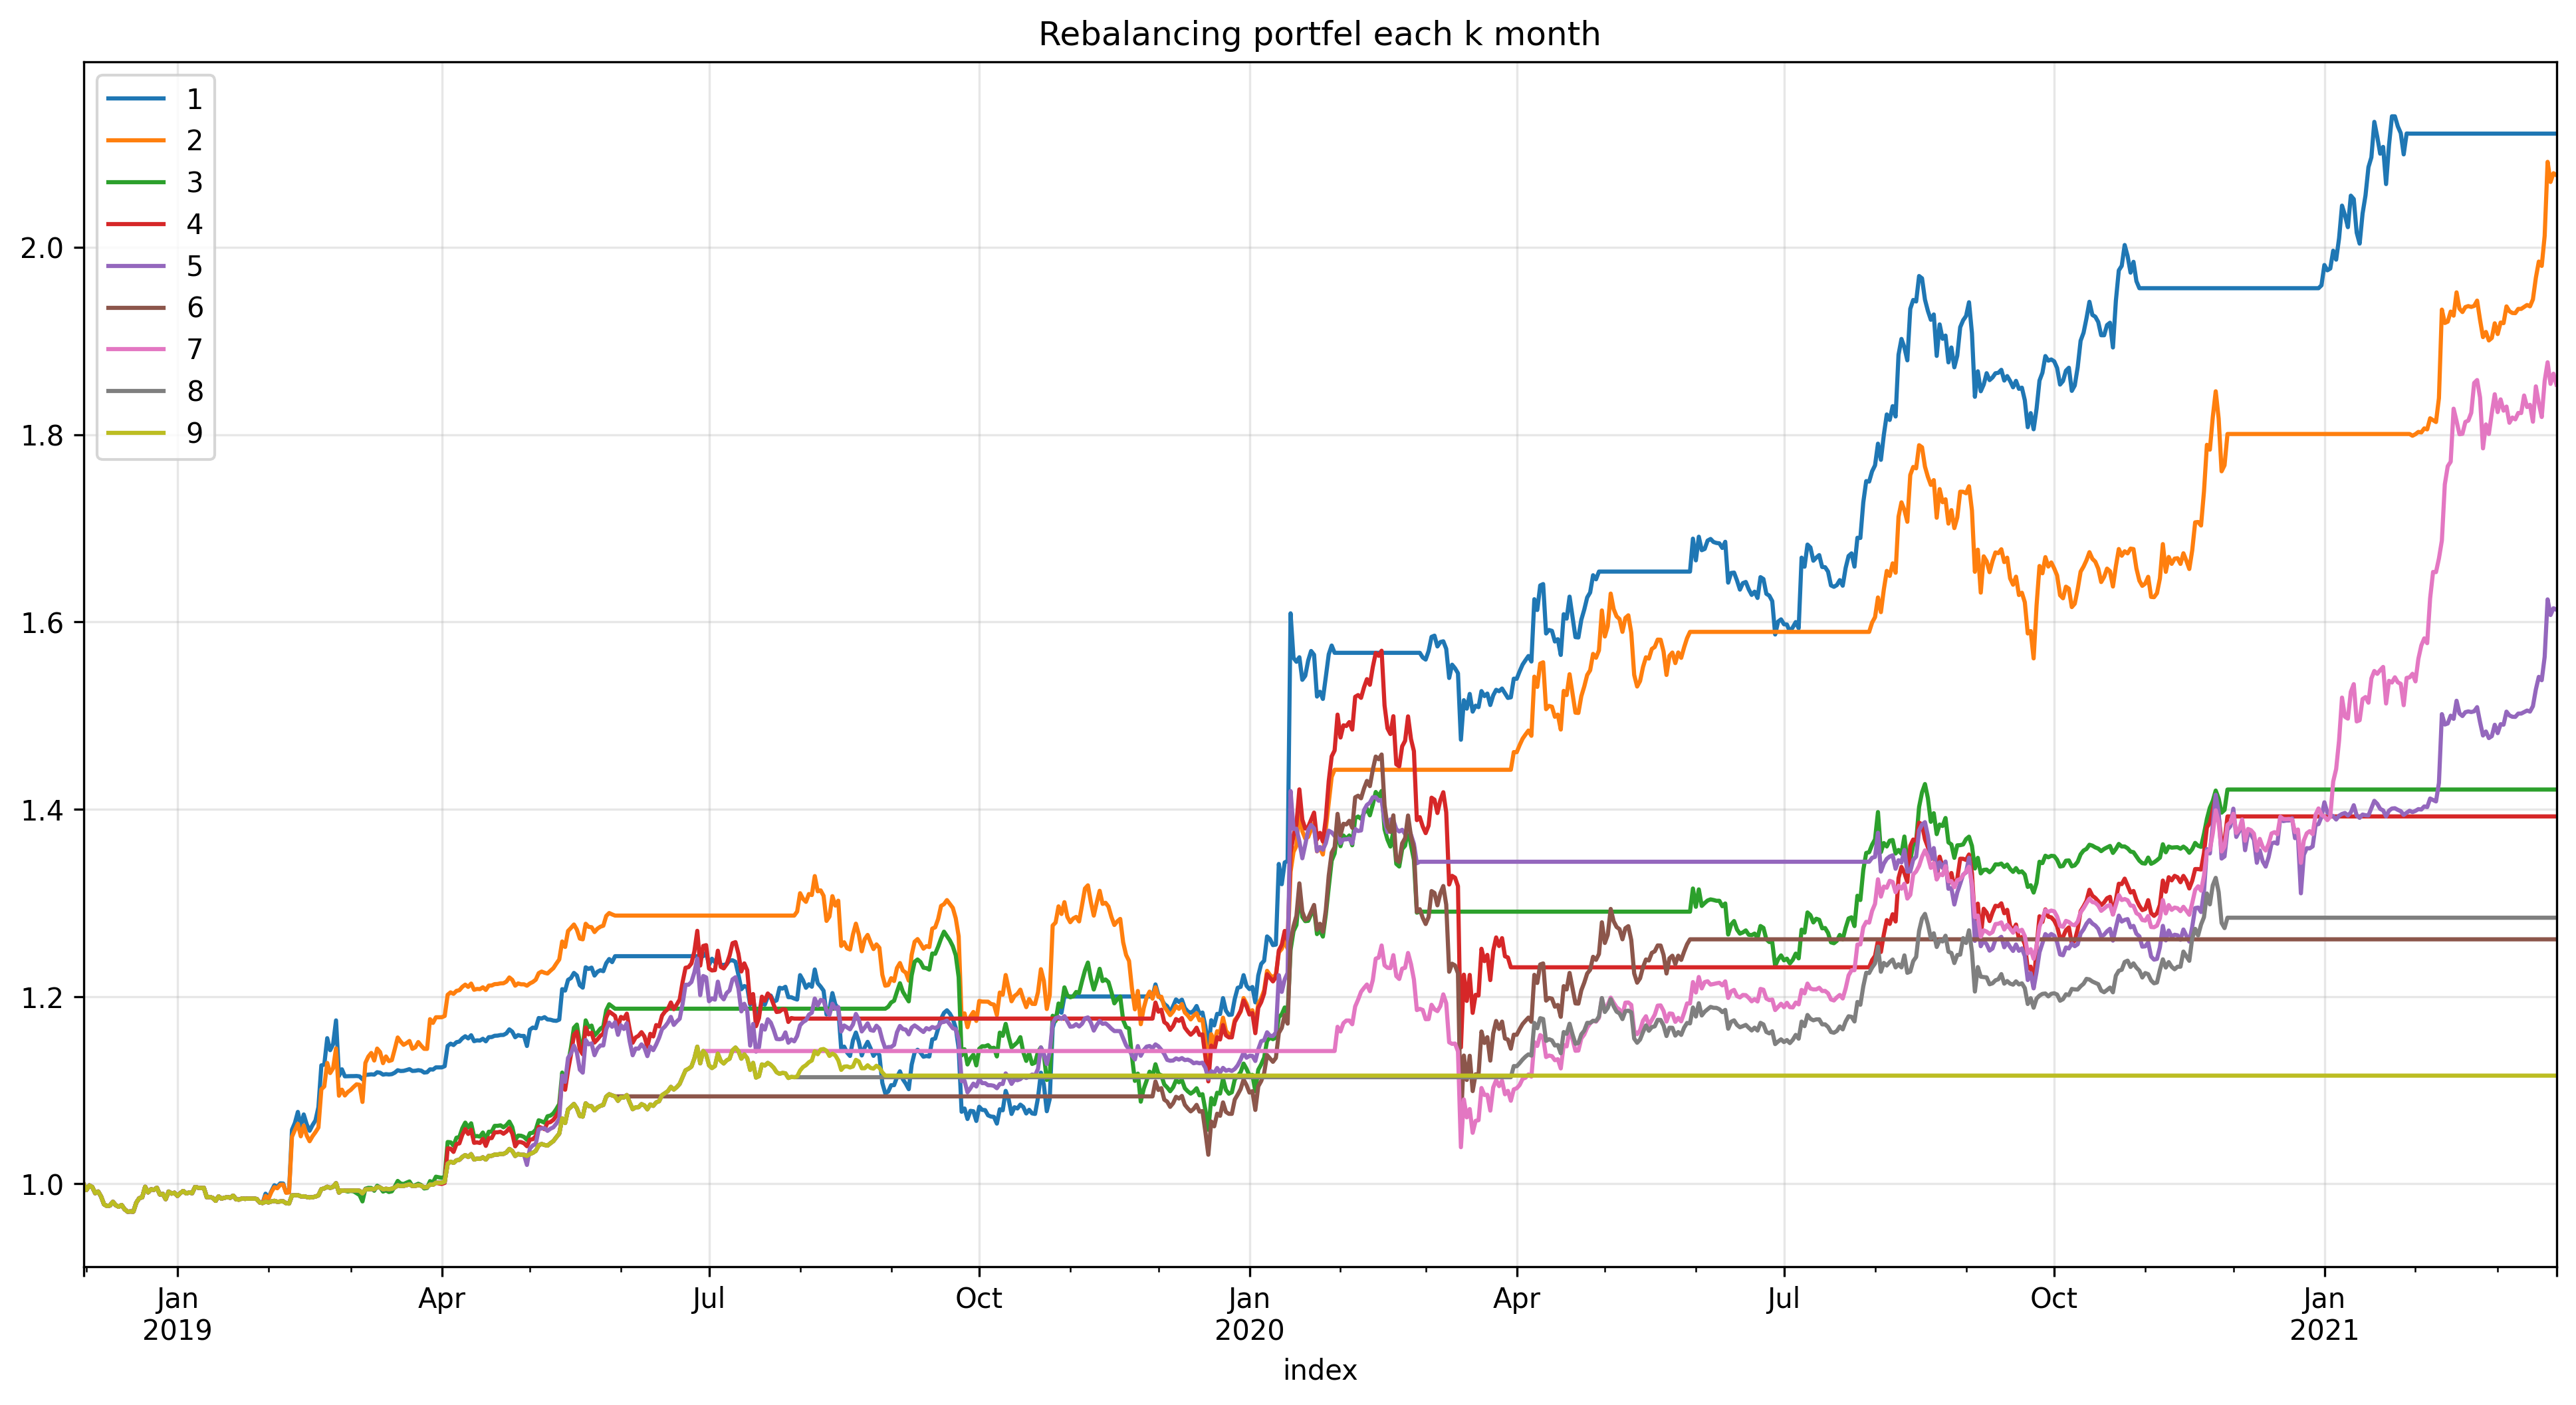

In [946]:
list_of_results = []

f, ax = plt.subplots(figsize=(16, 8), dpi=300)
NLARGEST = 3
REBALANCE = '1m'

for i in range(1, 10):
    REBALANCE = f'{i}m'
    result_ = main(futures_huobi, NLARGEST, REBALANCE)
    mean_return = (result_['signals'].resample('1d').last().fillna(method='ffill') * pivot(spot, 'price').pct_change()).dropna(axis=1, how='all').dropna(axis=0, how='all').mean(axis=1)
    list_of_results.append({i: mean_return})  
    

all_data = pd.concat([pd.DataFrame(i) for i in list_of_results], join='outer', axis=1)

(1 + all_data).cumprod().plot(ax=ax)
plt.title('Rebalancing portfel each k month')
plt.grid(alpha=0.3)

Выводы: визуально наиболее подходящее сочетание стратегии это 1 месяц, топ-3 бумаги

Теперь посмотрим на то, какие коины и какой вклад вносили в доходность портфеля каждый день

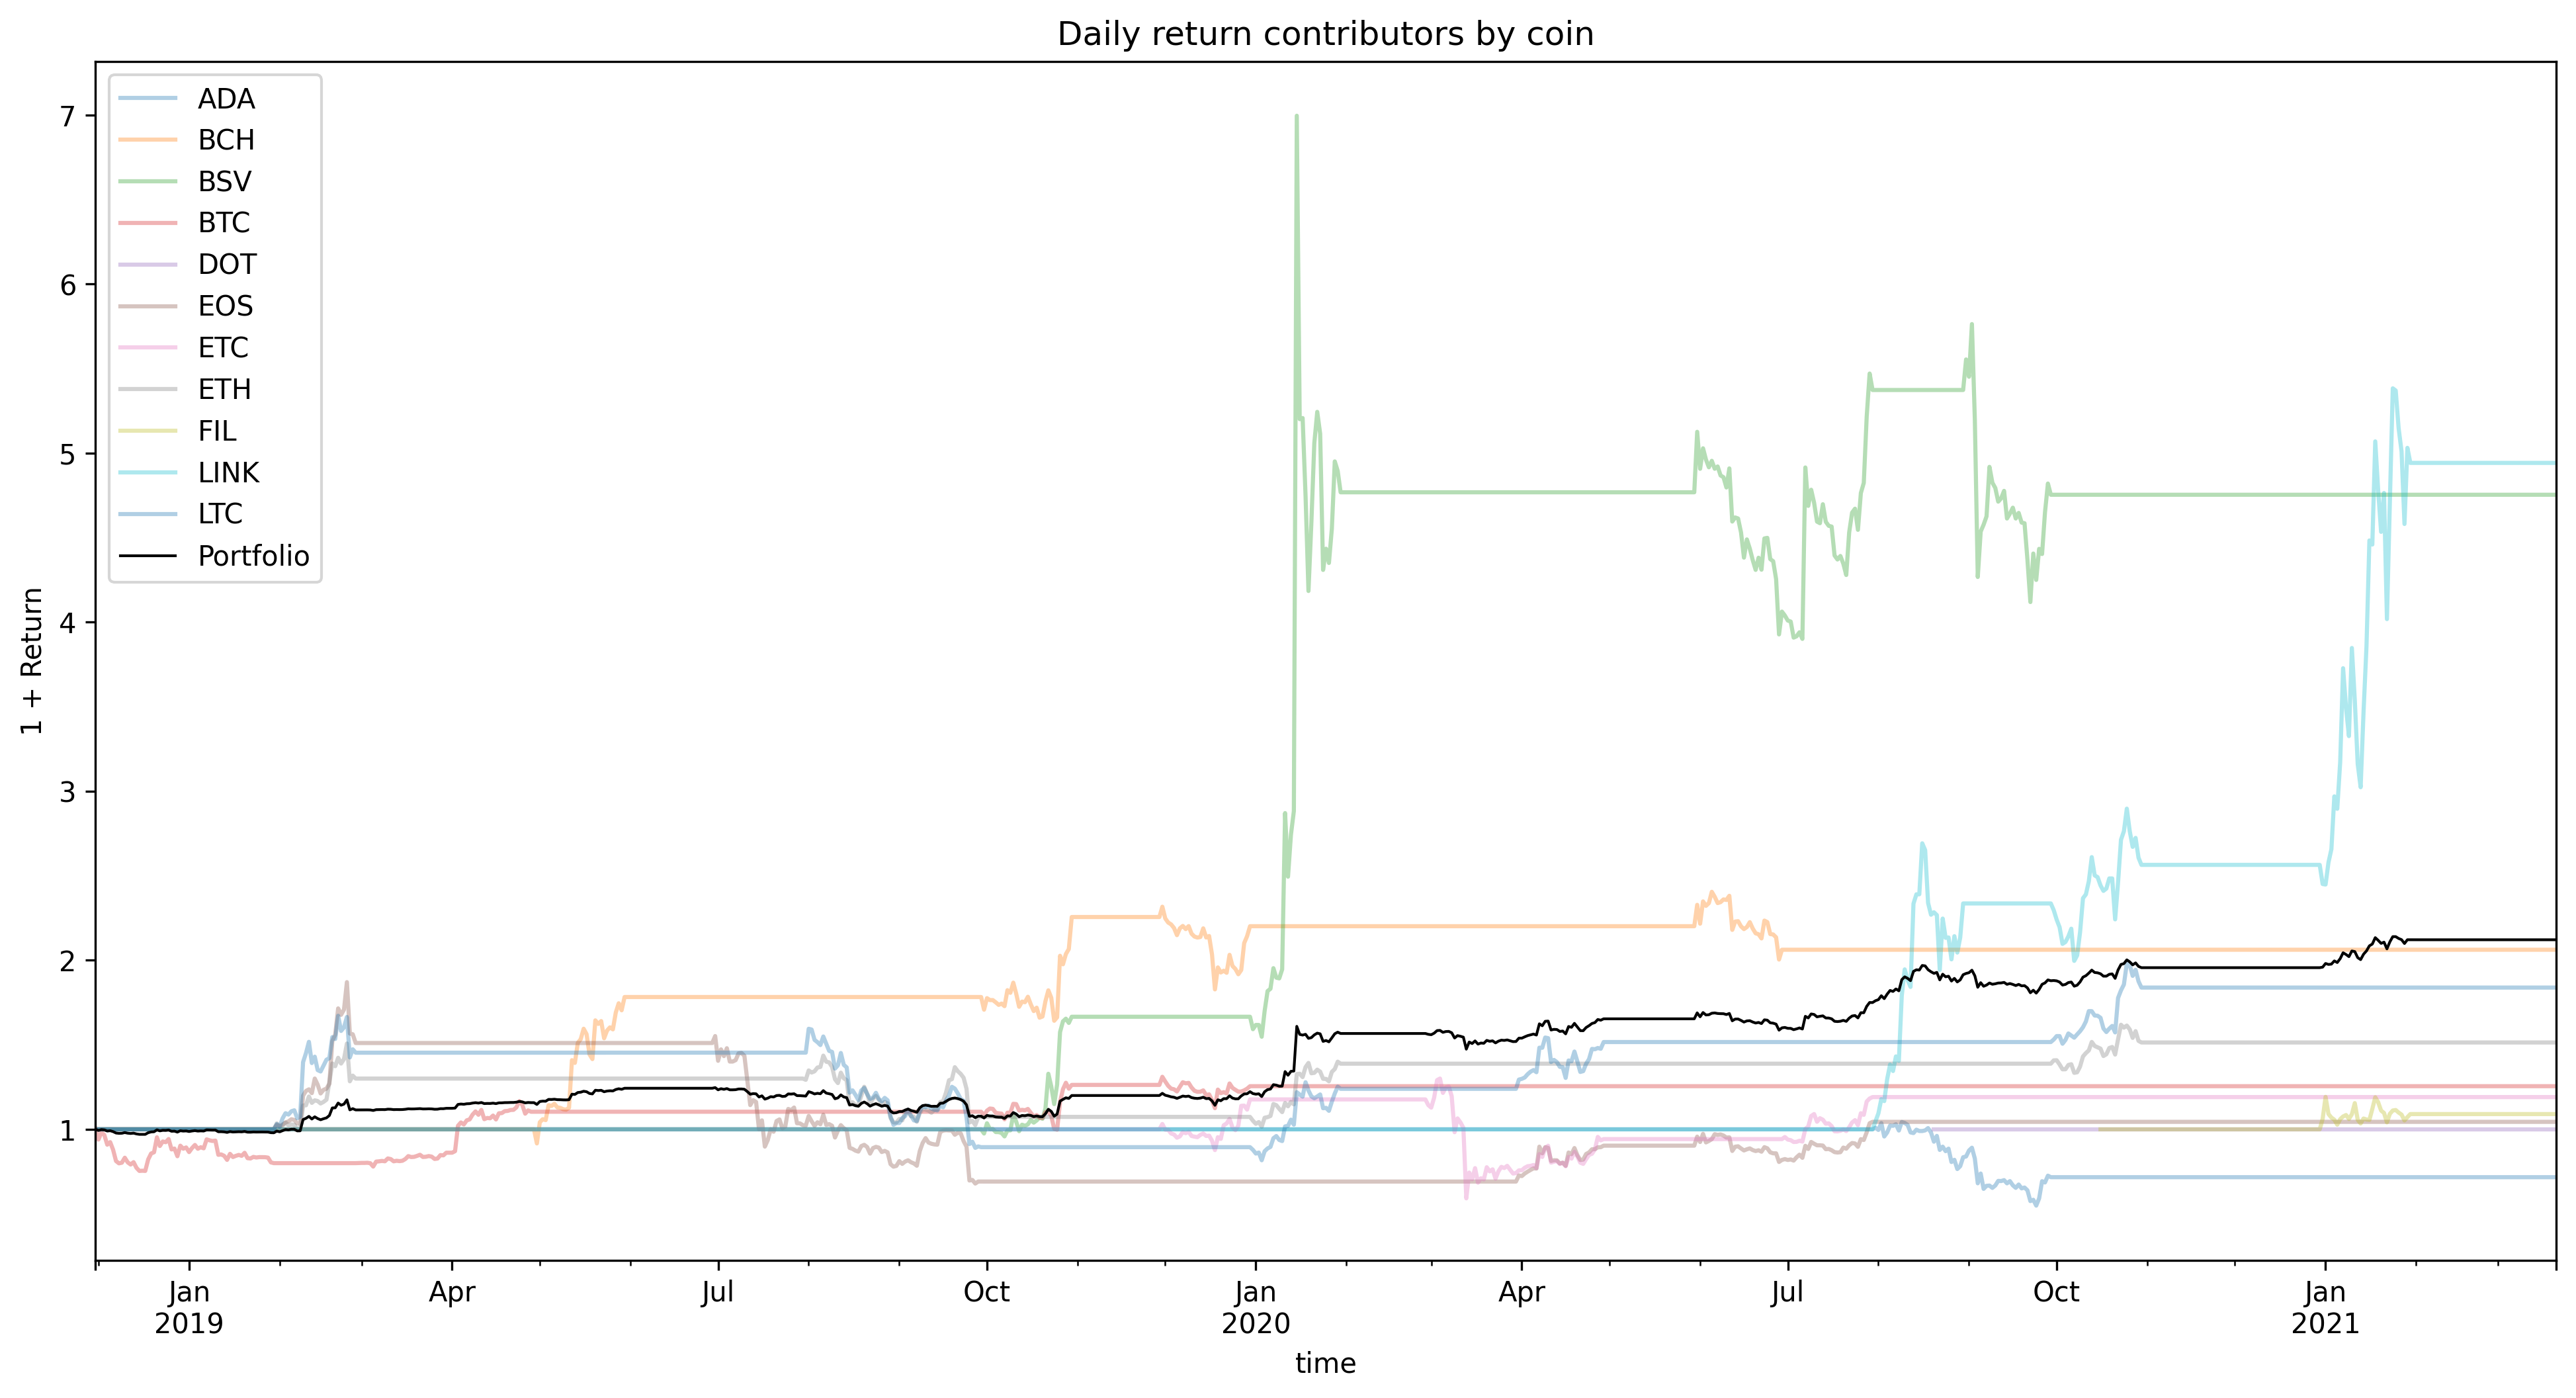

In [947]:
fig, ax = plt.subplots(figsize=(16,8),dpi=300)

ax.set_title('Daily return contributors by coin')

(1 + everyday_portfolio_value).cumprod().plot(ax=ax, alpha=0.35)
(1 + everyday_portfolio_value.mean(axis=1)).cumprod().plot(ax=ax, lw=1,
                                                           color='black',
                                                           xlabel='time',
                                                           ylabel='1 + Return',
                                                           label=f'Portfolio');

plt.legend()
fig.savefig('pdf/daily_return_of_portfolio.pdf')

In [948]:
everyday_portfolio_value.mean(axis=1).describe()

count    843.000000
mean       0.000958
std        0.011733
min       -0.059067
25%       -0.001845
50%        0.000000
75%        0.002515
max        0.196656
dtype: float64

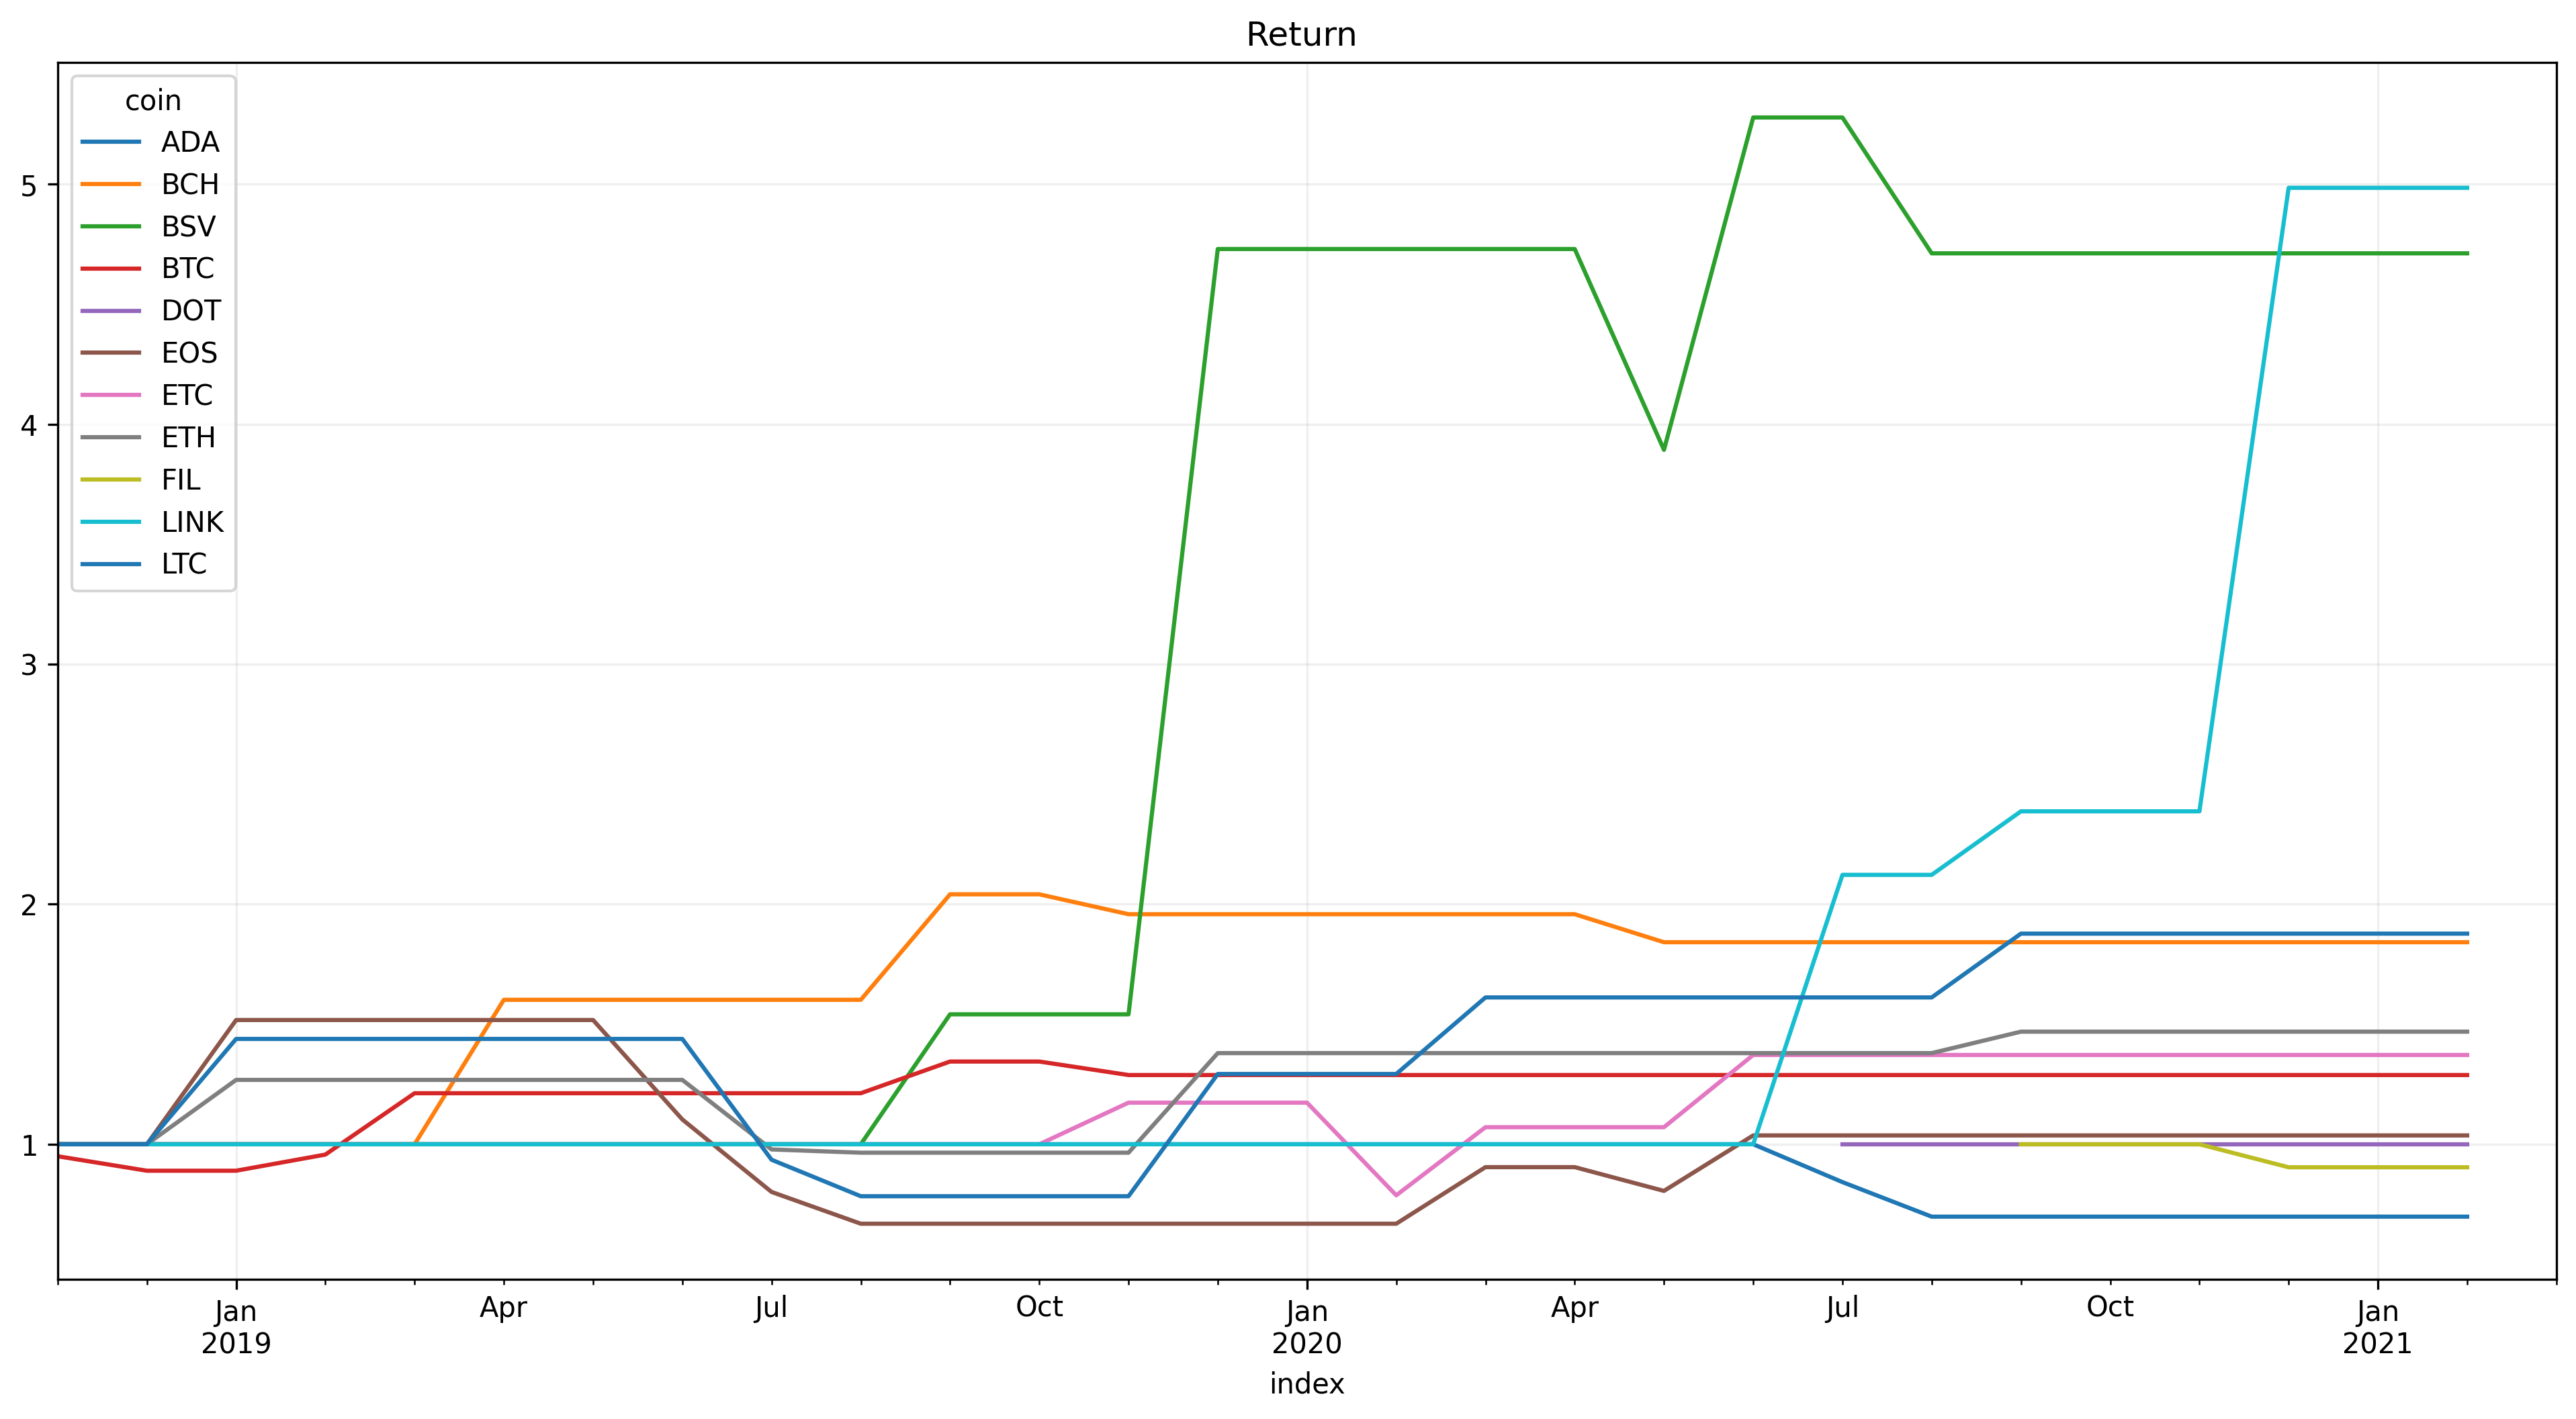

In [949]:
def check_how_increased(df):
    """Функция для подсчета доходности ребалансировки"""
    return (1 + df.pct_change()).cumprod().iloc[-1] - 1


monthly_price_increase = pivot(spot, 'price').resample('1m').apply(check_how_increased)
fig, ax = plt.subplots(figsize=(16,8),dpi=300)
(1 + result['signals'] * monthly_price_increase.reindex(index=result['signals'].index, columns=result['signals'].columns).shift(-1)).cumprod().plot(ax=ax);

plt.title('Return ')
plt.grid(alpha=0.2)

In [23]:
monthly_price_increase.mean(axis=1).describe()

count    96.000000
mean      0.230880
std       0.964580
min      -0.449624
25%      -0.129666
50%       0.023286
75%       0.285405
max       8.298030
dtype: float64

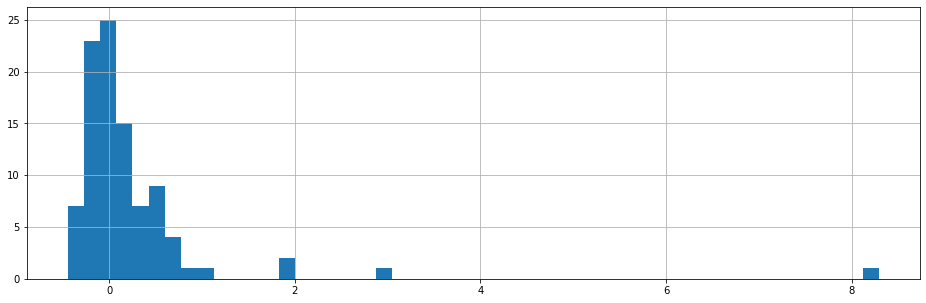

In [18]:
monthly_price_increase.mean(axis=1).hist(bins=50, figsize=(16, 5));


In [19]:

def plot_orders(symbol):

    fig, ax = plt.subplots(figsize=(16,8),dpi=300)

    ax2 = ax.twinx()

    # Цена закрытия
    ax.plot(pivot(spot, 'price')[symbol].iloc[-1300:], color='grey', label=f'Цена {symbol}')


    # Plot the buy signals
    ax.plot(result['orders'][symbol][result['orders'][symbol] == 1].index, 
             result['spot'][symbol][result['orders'][symbol] == 1],
             '^', markersize=10, color='green')

    # # Plot the sell signals
    ax.plot(result['orders'][symbol][result['orders'][symbol] == -1].index, 
             result['spot'][symbol][result['orders'][symbol] == -1],
             'v', markersize=10, color='red')

    ax2.plot((1 + everyday_portfolio_value[symbol]).cumprod(), alpha=0.2, label='Доходность портфеля из одной бумаги', color='green', ls='dashed')

    # # Show the plot
    plt.title(f'{symbol}')

#     ax2.set_yscale("log")
#     ax.set_yscale("log")

    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    ax.set_ylabel(f'price of {symbol}', color='grey', fontsize='xx-large')
    ax2.set_ylabel('return', color='green', fontsize='xx-large')

    plt.grid(alpha=0.3)
    plt.show();
    
    return fig

  0%|          | 0/11 [00:00<?, ?it/s]

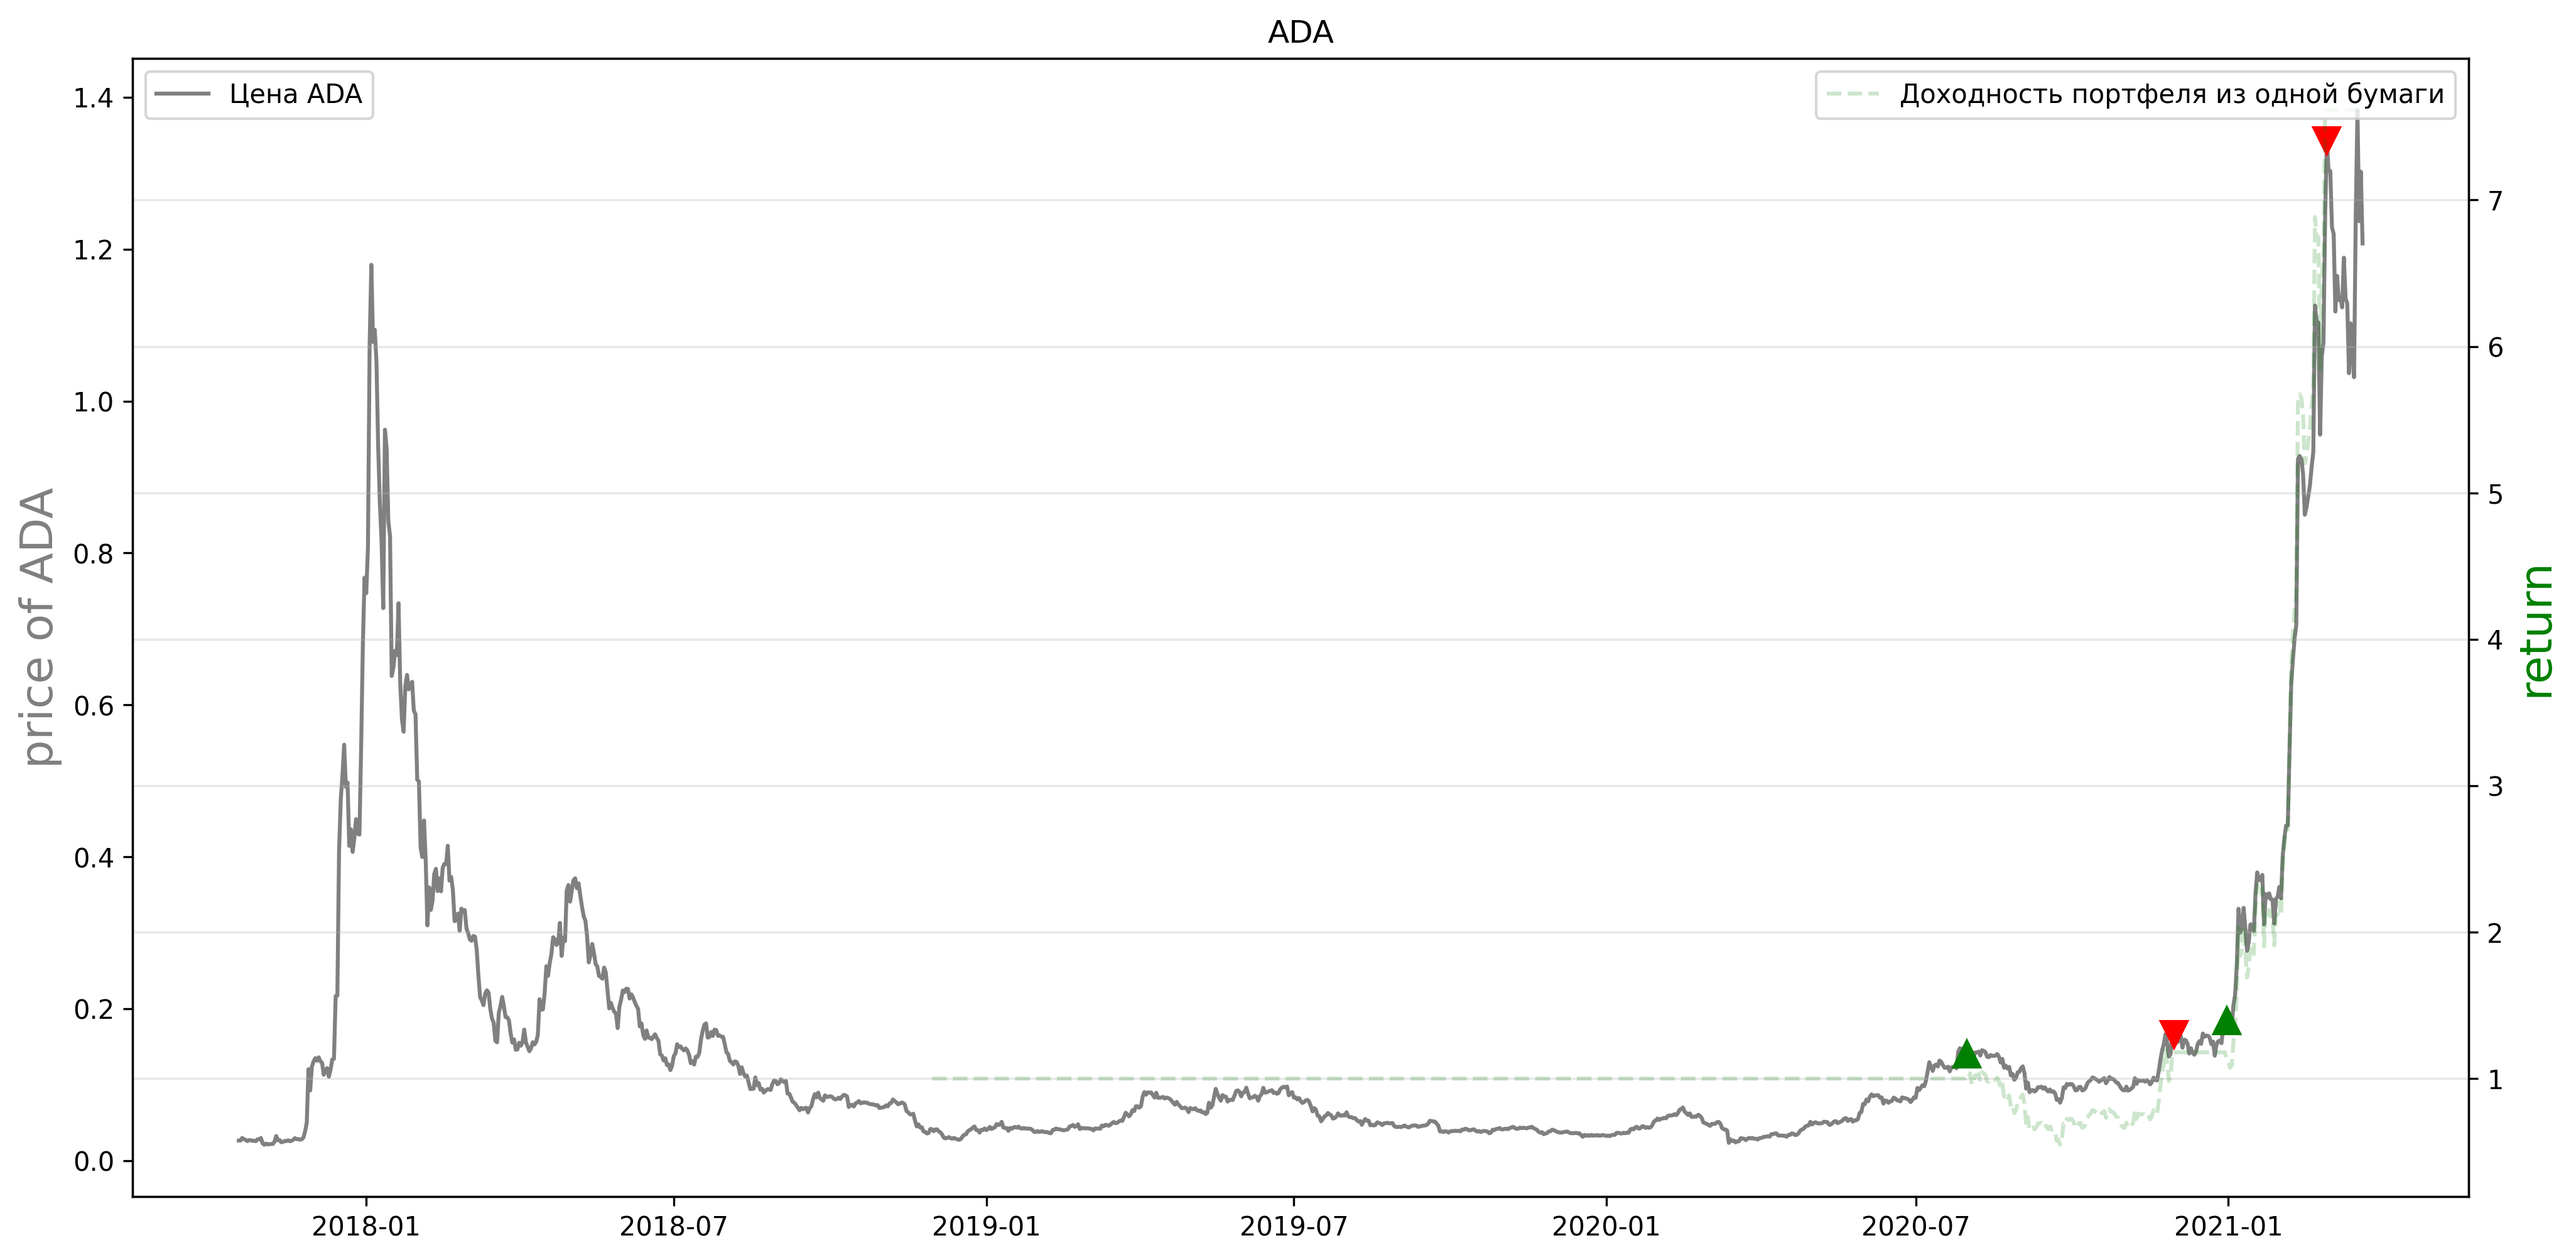

KeyboardInterrupt: 

In [20]:
symbol = result['results'].columns
for i in tqdm(symbol):
    fig = plot_orders(i)
    fig.savefig(f'pdf/{i}.pdf')

### Обзорная экскурсия по данным

Сначала посмотрим на корреляцию спотовых цен валют

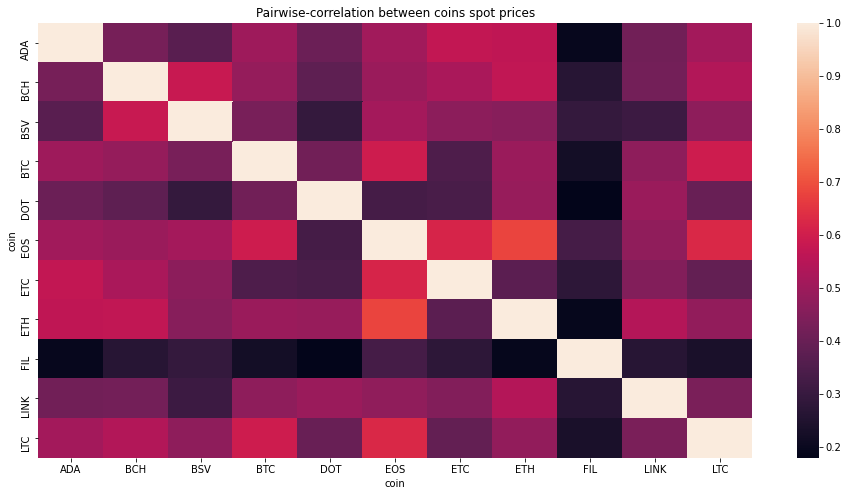

In [14]:
f, ax = plt.subplots(figsize=(16, 8))
REBALANCE = '1m'

spotp = pivot(spot, 'price')
corr = spotp[select_futures(futures_huobi, REBALANCE).columns].pct_change().corr()
# corr.style.background_gradient(cmap='coolwarm')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
plt.title('Pairwise-correlation between coins spot prices')
plt.show()

Основной вывод: криптовалюта очень скоррелирована. Посмотрим на изменение цен двух самых больших по корреляции пар:

In [1623]:
REBALANCE = '1m'

select_futures(futures_huobi, REBALANCE)[['ETH', 'EOS']].dropna().plot(figsize=(13, 2));

ValueError: zero-size array to reduction operation maximum which has no identity

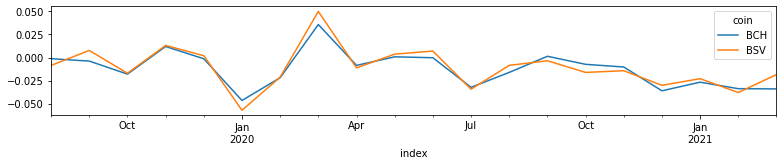

In [19]:
select_futures(futures_huobi, REBALANCE)[['BCH', 'BSV']].dropna().plot(figsize=(13, 2));

Будем строить стратегию, оперируя следующим фактором:
$$C_t= \frac{S_t - F_t}{F_t}$$


$S_t - \text{спотовая цена валюты в момент времени } t$

$F_t - \text{фьючерсная цена валюты в момент времени } t$

Теперь посмотрим на корреляцию керри фактора:

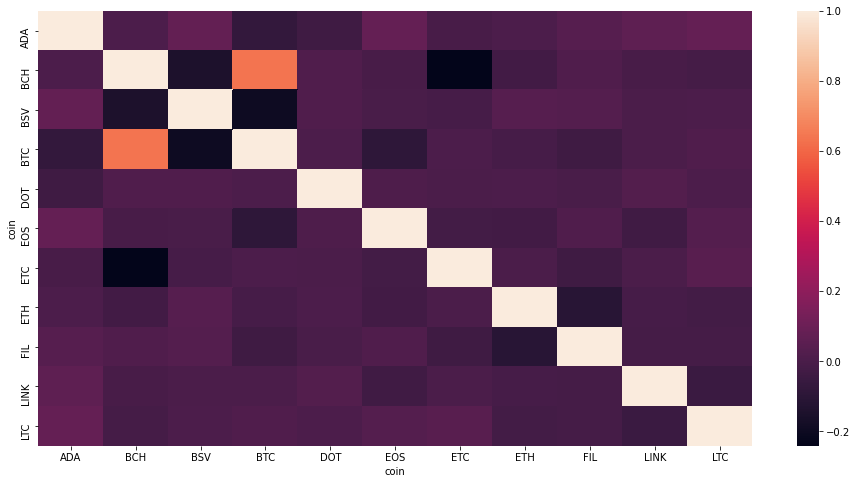

In [21]:
f, ax = plt.subplots(figsize=(16, 8))

corr = pivot(futures_huobi[futures_huobi['length'] == 'week']).pct_change().corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
plt.show()

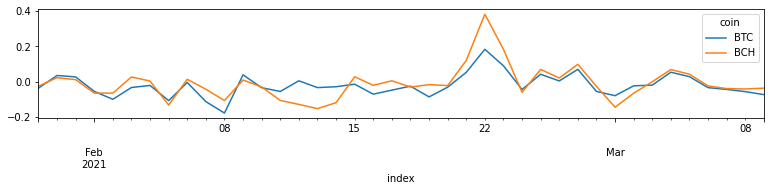

In [22]:
pivot(futures_huobi[futures_huobi['length'] == 'week'])[['BTC', 'BCH']].dropna().iloc[-40:, :].plot(figsize=(13, 2));

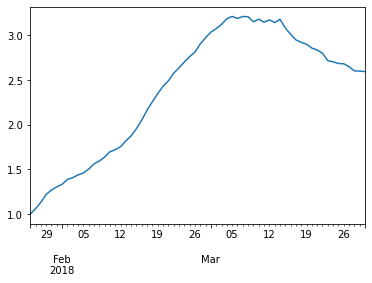

In [340]:
(1 + all_batches['XLMH18']['ar_carry'].loc['2018-01-01':'2018-05-01']).cumprod().plot()

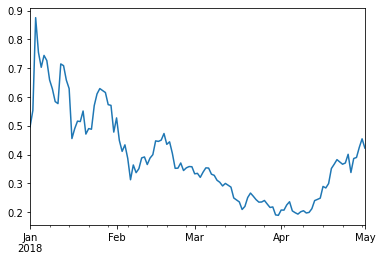

In [339]:
spot[spot['coin'] == 'XLM']['price'].loc['2018-01-01':'2018-05-01'].plot()

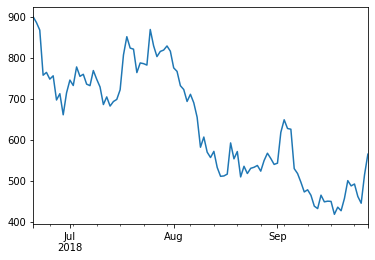

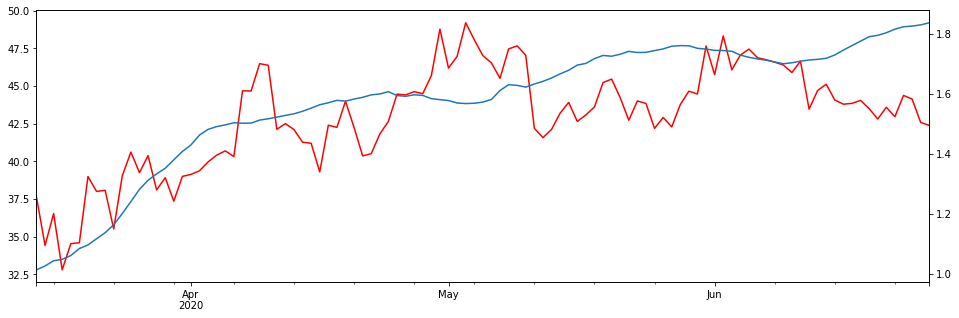

In [386]:
f, ax = plt.subplots(figsize=(16, 5))

symbol = 'LTCM20'

all_batches[symbol]['spot'].plot(ax=ax, c='r')
ax2 = ax.twinx()
(1 + all_batches[symbol]['carry']).cumprod().plot(ax=ax2)

In [361]:
all_batches.keys()

dict_keys(['BCHF18', 'ETHH18', 'LTCH18', 'XMRH18', 'ZECH18', 'ADAF18', 'XLMF18', 'ADAH18', 'BCHH18', 'XLMH18', 'NEOG18', 'NEOH18', 'ADAM18', 'BCHM18', 'ETHM18', 'LTCM18', 'EOSM18', 'ADAU18', 'BCHU18', 'EOSU18', 'ETHU18', 'LTCU18', 'ADAZ18', 'BCHZ18', 'EOSZ18', 'ETHZ18', 'LTCZ18', 'ADAH19', 'BCHH19', 'EOSH19', 'ETHH19', 'LTCH19', 'ADAM19', 'BCHM19', 'EOSM19', 'ETHM19', 'LTCM19', 'ADAU19', 'BCHU19', 'EOSU19', 'ETHU19', 'LTCU19', 'ADAZ19', 'BCHZ19', 'EOSZ19', 'ETHZ19', 'LTCZ19', 'ADAH20', 'BCHH20', 'EOSH20', 'ETHH20', 'LTCH20', 'ADAM20', 'BCHM20', 'EOSM20', 'ETHM20', 'LTCM20', 'ADAU20', 'BCHU20', 'EOSU20', 'ETHU20', 'LTCU20', 'ADAZ20', 'BCHZ20', 'EOSZ20', 'ETHZ20', 'LTCZ20', 'ADAH21', 'BCHH21', 'EOSH21', 'ETHH21', 'LTCH21', 'ZECZ16', 'XBCZ16', 'XBCH17', 'ZECH17', 'XBCM17', 'ZECM17', 'ETHJ17', 'XMRJ17', 'GNOM17', 'ETHM17', 'FCTM17', 'LTCM17', 'XMRM17', 'ETHU17', 'LTCU17', 'XMRU17', 'ZECU17', 'EOSN17', 'ETHZ17', 'LTCZ17', 'XMRZ17', 'ZECZ17', 'BCHX17', 'BCHZ17'])

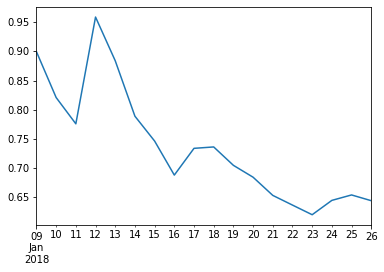

In [377]:
(1 + all_batches['ADAF18']['carry']).cumprod().plot()
all_batches['ADAF18']['spot'].plot()

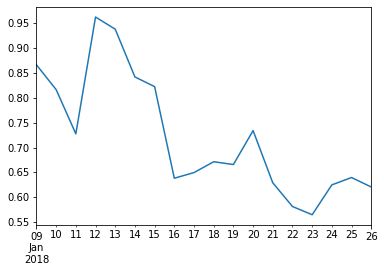